In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Input,InputLayer, Concatenate, concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from plot_keras_history import show_history, plot_history
import keras
import pydot
import graphviz

In [3]:
df = pd.read_csv('E:\\My files\\Dr Buzna\\trips\\NN\\NN-based_distance\\tripdf_hs_sphs.csv', index_col=0)
print(df.shape)
df.tail()

(16231, 9)


travel time  real travel time  euc_dist   distance  hour of day  \
16226         1700            1712.0  0.139091  22341.337            8   
16227         1337            1350.0  0.138997  21957.802           22   
16228         1240            1252.0  0.139205  22461.781            1   
16229         1266            1272.0  0.138397  22737.294            3   
16230         1216            1227.0  0.139646  22127.191           23   

           O lat      O lon      D lat      D lon  
16226  49.438772  18.772652  49.300220  18.784883  
16227  49.438643  18.772910  49.300166  18.784926  
16228  49.438858  18.772781  49.300188  18.784969  
16229  49.438043  18.772330  49.300220  18.784926  
16230  49.439362  18.772759  49.300241  18.784862

In [4]:
# df = pd.merge(df0,df3, on = ['travel time','distance','hour of day'])

df = df.drop(['travel time','euc_dist'],axis=1)
df.rename(columns = {'real travel time':'travel time'}, inplace = True)
df = pd.concat([df.iloc[:,-5:].reset_index(drop=True) , df.iloc[:,0:-5].reset_index(drop=True)] , axis=1)
df.head(2)
df.columns

Index(['hour of day', 'O lat', 'O lon', 'D lat', 'D lon', 'travel time',
       'distance'],
      dtype='object')

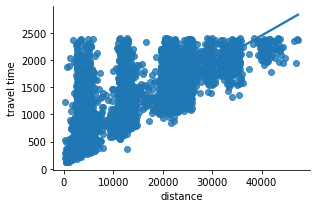

In [5]:
sns.lmplot(x='distance',y='travel time',data=df, height=3, aspect=1.5)

In [6]:
# outlier removal
from scipy import stats
df = df[(np.abs(stats.zscore(df['distance'])) < 3)]

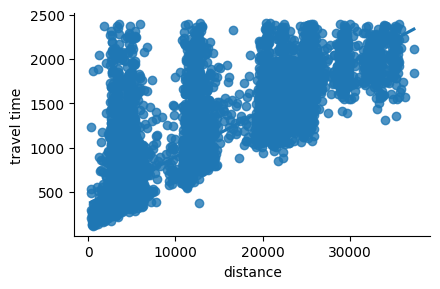

In [7]:
sns.lmplot(x='distance',y='travel time',data=df, height=3, aspect=1.5)

In [8]:
# Normalize using Min/Max Normalization.
normalized_Olat=(df['O lat']-df['O lat'].min())/(df['O lat'].max()-df['O lat'].min())
df['O lat'] = normalized_Olat
normalized_Dlat=(df['D lat']-df['D lat'].min())/(df['D lat'].max()-df['D lat'].min())
df['D lat'] = normalized_Dlat
normalized_Olon=(df['O lon']-df['O lon'].min())/(df['O lon'].max()-df['O lon'].min())
df['O lon'] = normalized_Olon
normalized_Dlon=(df['D lon']-df['D lon'].min())/(df['D lon'].max()-df['D lon'].min())
df['D lon'] = normalized_Dlon
normalized_Dist=(df['distance']-df['distance'].min())/(df['distance'].max()-df['distance'].min())
df['distance'] = normalized_Dist
df['hr_sin'] = np.sin(df['hour of day']*(2.*np.pi/24))
df['hr_cos'] = np.cos(df['hour of day']*(2.*np.pi/24))
df

hour of day     O lat     O lon     D lat     D lon  travel time  \
0               18  0.451980  0.344393  0.269550  0.695121       2232.0   
1               21  0.451780  0.344318  0.269459  0.695159        828.0   
2               19  0.449767  0.348013  0.269427  0.694811        755.0   
3               17  0.452324  0.344875  0.269396  0.695276        894.0   
4               17  0.452766  0.344925  0.269582  0.695082        882.0   
...            ...       ...       ...       ...       ...          ...   
16226            8  0.867312  0.374082  0.602618  0.554396       1712.0   
16227           22  0.867070  0.374387  0.602464  0.554473       1350.0   
16228            1  0.867474  0.374234  0.602527  0.554551       1252.0   
16229            3  0.865945  0.373703  0.602618  0.554473       1272.0   
16230           23  0.868419  0.374209  0.602679  0.554358       1227.0   

       distance    hr_sin        hr_cos  
0      0.288827 -1.000000 -1.836970e-16  
1      0.291979 -0.707107  7.071068e-01  
2      0.291246 -0.965926  2.588190e-01  
3      0.299914 -0.965926 -2.588190e-01  
4      0.310737 -0.965926 -2.588190e-01  
...         ...       ...           ...  
16226  0.595178  0.866025 -5.000000e-01  
16227  0.584843 -0.500000  8.660254e-01  
16228  0.598424  0.258819  9.659258e-01  
16229  0.605848  0.707107  7.071068e-01  
16230  0.589407 -0.258819  9.659258e-01  

[16138 rows x 9 columns]

In [9]:
# df['distance'] = df['distance']/1000 #in km
# df['travel time'] = df['travel time']/60 #in minutes
# df

# Functional API keras model

In [10]:
np.random.seed(7)

In [11]:
def nnmodel(*num_neuron,num_hlayers,Epoch):

    if num_hlayers == 1:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[1], activation='relu')(merge_two)
        second_dense = Dense(1, activation='relu',name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])
    elif num_hlayers == 2:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense  = Dense(num_neuron[1], activation='relu')(first_dense)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[2], activation='relu')(merge_two)
        second_dense = Dense(num_neuron[3], activation='relu')(second_dense)
        second_dense = Dense(1, activation='relu', name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])
    else:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense  = Dense(num_neuron[1], activation='relu')(first_dense)
        first_dense  = Dense(num_neuron[2], activation='relu')(first_dense)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[3], activation='relu')(merge_two)
        second_dense = Dense(num_neuron[4], activation='relu')(second_dense)
        second_dense = Dense(num_neuron[5], activation='relu')(second_dense)
        second_dense = Dense(1, activation='relu', name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])        

#     from keras.optimizers import SGD
#     opt = SGD(lr=0.01)
#     model.compile(loss = "categorical_crossentropy", optimizer = opt)       
        
    learning_rate = 0.05
    model.compile(optimizer='adam',
                  loss=[tf.keras.metrics.mean_squared_error,tf.keras.metrics.mean_squared_error],
                  loss_weights=[0.2,0.8],
                  metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#     model.compile(optimizer='adam',
#                   loss=tf.keras.metrics.mean_squared_error,
#                   metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    history = model.fit([X_train[:,0:4],X_train[:,4:]], [y_train[:,0],y_train[:,1]], verbose=1, epochs=Epoch,
                   validation_data=([X_test[:,0:4],X_test[:,4:]], [y_test[:,0],y_test[:,1]]))   
    
    print('minimum testing RMSE (distance): ',min(history.history['val_distance_layer_rmse'])/1000)
    print('minimum testing MAPE (distance): ',min(history.history['val_distance_layer_mape'])/100)
    print('-----------------')
    print('minimum testing ravel time): ',min(history.history['val_traveltime_layer_rmse'])/60)
    print('minimum testing MAPE (travel time): ',min(history.history['val_traveltime_layer_mape'])/100)
    
    return history

## sub-problem 1:     ******* input: [] *********

In [12]:
x = df.loc[:,['O lat','O lon','D lat','D lon']].values
y = df.loc[:,['distance','travel time']].values
# x

In [13]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [14]:
print(X_train.shape)
print(X_test.shape)
# X_train

(11296, 4)
(4842, 4)


In [15]:
def plotme(model):

    # Plot the training and validation accuracy and loss at each epoch
    loss1 = [f/60 for f in model.history['traveltime_layer_rmse']]
    val_loss1 = [f/60 for f in model.history['val_traveltime_layer_rmse']]
    loss2 = model.history['traveltime_layer_mape']
    val_loss2 = model.history['val_traveltime_layer_mape']
    val_loss2 = [x+1.8 for x in val_loss2]
    epochs = range(1, len(model.history['loss'])+1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, val_loss1, 'r', label='Validation rmse')
    plt.plot(epochs, loss1, 'y', label='Trainnig rmse')
    plt.plot(epochs, val_loss2, 'k', label='Validation mape')
    plt.plot(epochs, loss2, 'b', label='Trainnig mape')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    #plt.xlim(lims)
    yli = max(model.history['val_traveltime_layer_mape'])
    plt.ylim([-1, yli+10])
    plt.legend()
    plt.show()

In [16]:
# inputs: distance
model1_1 = nnmodel(5,5, num_hlayers=1,Epoch=500)
model1_1

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 900025.0000 - distance_layer_loss: 5.1961 - traveltime_layer_loss: 1125030.0000 - distance_layer_mape: 313295.0938 - distance_layer_rmse: 2.2795 - traveltime_layer_mape: 99.1259 - traveltime_layer_rmse: 1060.6743 - val_loss: 842634.1875 - val_distance_layer_loss: 27.3284 - val_traveltime_layer_loss: 1053285.8750 - val_distance_layer_mape: 3947.2966 - val_distance_layer_rmse: 5.2277 - val_traveltime_layer_mape: 96.5930 - val_traveltime_layer_rmse: 1026.2971
Epoch 2/500
353/353 [==============================] - 0s 980us/step - loss: 770886.5000 - distance_layer_loss: 165.3956 - traveltime_layer_loss: 963566.1250 - distance_layer_mape: 978503.6875 - distance_layer_rmse: 12.8606 - traveltime_layer_mape: 85.9025 - traveltime_layer_rmse: 981.6140 - val_loss: 588523.9375 - val_distance_layer_loss: 408.4213 - val_traveltime_layer_loss: 735553.1250 - val_distance_layer_mape: 14943.5342 - val_distance_layer_rmse: 20.2094

353/353 [==============================] - 0s 1ms/step - loss: 181309.2344 - distance_layer_loss: 1704.0072 - traveltime_layer_loss: 226210.5781 - distance_layer_mape: 3350996.0000 - distance_layer_rmse: 41.2796 - traveltime_layer_mape: 58.1513 - traveltime_layer_rmse: 475.6160 - val_loss: 177654.9219 - val_distance_layer_loss: 1677.4574 - val_traveltime_layer_loss: 221649.4219 - val_distance_layer_mape: 29345.4434 - val_distance_layer_rmse: 40.9568 - val_traveltime_layer_mape: 58.4564 - val_traveltime_layer_rmse: 470.7966
Epoch 32/500
353/353 [==============================] - 0s 989us/step - loss: 180902.5156 - distance_layer_loss: 1682.2300 - traveltime_layer_loss: 225707.4688 - distance_layer_mape: 3355531.2500 - distance_layer_rmse: 41.0150 - traveltime_layer_mape: 57.9651 - traveltime_layer_rmse: 475.0868 - val_loss: 177582.5469 - val_distance_layer_loss: 1675.0151 - val_traveltime_layer_loss: 221559.4531 - val_distance_layer_mape: 29296.6270 - val_distance_layer_rmse: 40.9269 - 

353/353 [==============================] - 0s 981us/step - loss: 171162.4688 - distance_layer_loss: 1025.1256 - traveltime_layer_loss: 213696.8594 - distance_layer_mape: 2481443.5000 - distance_layer_rmse: 32.0176 - traveltime_layer_mape: 54.0871 - traveltime_layer_rmse: 462.2736 - val_loss: 168242.8906 - val_distance_layer_loss: 1006.3242 - val_traveltime_layer_loss: 210052.0000 - val_distance_layer_mape: 21952.6836 - val_distance_layer_rmse: 31.7226 - val_traveltime_layer_mape: 54.6221 - val_traveltime_layer_rmse: 458.3143
Epoch 62/500
353/353 [==============================] - 0s 1ms/step - loss: 170848.6562 - distance_layer_loss: 1004.4536 - traveltime_layer_loss: 213309.7812 - distance_layer_mape: 2504142.7500 - distance_layer_rmse: 31.6931 - traveltime_layer_mape: 53.8838 - traveltime_layer_rmse: 461.8547 - val_loss: 168309.5781 - val_distance_layer_loss: 1001.1775 - val_traveltime_layer_loss: 210136.6562 - val_distance_layer_mape: 21876.5664 - val_distance_layer_rmse: 31.6414 - 

353/353 [==============================] - 0s 1ms/step - loss: 163759.0938 - distance_layer_loss: 573.6383 - traveltime_layer_loss: 204555.4062 - distance_layer_mape: 1796127.3750 - distance_layer_rmse: 23.9507 - traveltime_layer_mape: 49.7542 - traveltime_layer_rmse: 452.2780 - val_loss: 160116.9688 - val_distance_layer_loss: 545.4998 - val_traveltime_layer_loss: 200009.9062 - val_distance_layer_mape: 15374.4004 - val_distance_layer_rmse: 23.3559 - val_traveltime_layer_mape: 48.2422 - val_traveltime_layer_rmse: 447.2247
Epoch 92/500
353/353 [==============================] - 0s 1ms/step - loss: 163642.6250 - distance_layer_loss: 565.6051 - traveltime_layer_loss: 204411.8750 - distance_layer_mape: 1781898.7500 - distance_layer_rmse: 23.7825 - traveltime_layer_mape: 49.5931 - traveltime_layer_rmse: 452.1193 - val_loss: 160061.1562 - val_distance_layer_loss: 553.2058 - val_traveltime_layer_loss: 199938.0469 - val_distance_layer_mape: 15488.4873 - val_distance_layer_rmse: 23.5203 - val_tr

353/353 [==============================] - 0s 1ms/step - loss: 162748.6875 - distance_layer_loss: 485.7208 - traveltime_layer_loss: 203314.4531 - distance_layer_mape: 1624592.5000 - distance_layer_rmse: 22.0391 - traveltime_layer_mape: 48.8229 - traveltime_layer_rmse: 450.9041 - val_loss: 158994.7969 - val_distance_layer_loss: 486.4540 - val_traveltime_layer_loss: 198621.8125 - val_distance_layer_mape: 14380.0000 - val_distance_layer_rmse: 22.0557 - val_traveltime_layer_mape: 50.0532 - val_traveltime_layer_rmse: 445.6701
Epoch 122/500
353/353 [==============================] - 0s 1ms/step - loss: 162828.5938 - distance_layer_loss: 487.7852 - traveltime_layer_loss: 203413.7969 - distance_layer_mape: 1631539.0000 - distance_layer_rmse: 22.0859 - traveltime_layer_mape: 49.2184 - traveltime_layer_rmse: 451.0142 - val_loss: 158599.4062 - val_distance_layer_loss: 471.5106 - val_traveltime_layer_loss: 198131.3750 - val_distance_layer_mape: 14130.8223 - val_distance_layer_rmse: 21.7143 - val_t

353/353 [==============================] - 0s 1ms/step - loss: 162768.3906 - distance_layer_loss: 475.5501 - traveltime_layer_loss: 203341.5938 - distance_layer_mape: 1610579.2500 - distance_layer_rmse: 21.8071 - traveltime_layer_mape: 48.9111 - traveltime_layer_rmse: 450.9341 - val_loss: 158845.8125 - val_distance_layer_loss: 475.2112 - val_traveltime_layer_loss: 198438.4375 - val_distance_layer_mape: 14202.9082 - val_distance_layer_rmse: 21.7993 - val_traveltime_layer_mape: 49.9569 - val_traveltime_layer_rmse: 445.4643
Epoch 152/500
353/353 [==============================] - 0s 1ms/step - loss: 162788.5156 - distance_layer_loss: 476.9239 - traveltime_layer_loss: 203366.3750 - distance_layer_mape: 1612800.1250 - distance_layer_rmse: 21.8386 - traveltime_layer_mape: 49.1322 - traveltime_layer_rmse: 450.9616 - val_loss: 158627.5625 - val_distance_layer_loss: 469.0340 - val_traveltime_layer_loss: 198167.1562 - val_distance_layer_mape: 14099.3428 - val_distance_layer_rmse: 21.6572 - val_t

353/353 [==============================] - 0s 1ms/step - loss: 162813.2500 - distance_layer_loss: 473.4692 - traveltime_layer_loss: 203398.1875 - distance_layer_mape: 1604560.0000 - distance_layer_rmse: 21.7593 - traveltime_layer_mape: 49.1279 - traveltime_layer_rmse: 450.9969 - val_loss: 158585.7656 - val_distance_layer_loss: 464.1596 - val_traveltime_layer_loss: 198116.2188 - val_distance_layer_mape: 14024.4590 - val_distance_layer_rmse: 21.5444 - val_traveltime_layer_mape: 49.0646 - val_traveltime_layer_rmse: 445.1025
Epoch 182/500
353/353 [==============================] - 0s 1ms/step - loss: 162766.0156 - distance_layer_loss: 471.4344 - traveltime_layer_loss: 203339.7344 - distance_layer_mape: 1598024.0000 - distance_layer_rmse: 21.7125 - traveltime_layer_mape: 48.9627 - traveltime_layer_rmse: 450.9321 - val_loss: 158626.8750 - val_distance_layer_loss: 465.3757 - val_traveltime_layer_loss: 198167.3281 - val_distance_layer_mape: 14044.4150 - val_distance_layer_rmse: 21.5726 - val_t

353/353 [==============================] - 0s 1ms/step - loss: 162815.8906 - distance_layer_loss: 471.0281 - traveltime_layer_loss: 203402.2188 - distance_layer_mape: 1587372.3750 - distance_layer_rmse: 21.7032 - traveltime_layer_mape: 49.2220 - traveltime_layer_rmse: 451.0013 - val_loss: 158546.5469 - val_distance_layer_loss: 459.2107 - val_traveltime_layer_loss: 198068.2969 - val_distance_layer_mape: 13946.0303 - val_distance_layer_rmse: 21.4292 - val_traveltime_layer_mape: 48.8338 - val_traveltime_layer_rmse: 445.0486
Epoch 212/500
353/353 [==============================] - 0s 1ms/step - loss: 162786.7812 - distance_layer_loss: 467.0375 - traveltime_layer_loss: 203366.8281 - distance_layer_mape: 1574890.3750 - distance_layer_rmse: 21.6111 - traveltime_layer_mape: 48.8676 - traveltime_layer_rmse: 450.9621 - val_loss: 158729.4844 - val_distance_layer_loss: 465.4945 - val_traveltime_layer_loss: 198295.4844 - val_distance_layer_mape: 14052.6191 - val_distance_layer_rmse: 21.5753 - val_t

353/353 [==============================] - 0s 975us/step - loss: 162805.5625 - distance_layer_loss: 465.3748 - traveltime_layer_loss: 203390.5938 - distance_layer_mape: 1597532.5000 - distance_layer_rmse: 21.5725 - traveltime_layer_mape: 48.9214 - traveltime_layer_rmse: 450.9885 - val_loss: 158598.5469 - val_distance_layer_loss: 458.8209 - val_traveltime_layer_loss: 198133.5312 - val_distance_layer_mape: 13944.9736 - val_distance_layer_rmse: 21.4201 - val_traveltime_layer_mape: 49.1264 - val_traveltime_layer_rmse: 445.1219
Epoch 242/500
353/353 [==============================] - 0s 1ms/step - loss: 162826.3125 - distance_layer_loss: 466.9032 - traveltime_layer_loss: 203416.2344 - distance_layer_mape: 1579585.6250 - distance_layer_rmse: 21.6079 - traveltime_layer_mape: 49.1433 - traveltime_layer_rmse: 451.0169 - val_loss: 158640.0469 - val_distance_layer_loss: 460.2393 - val_traveltime_layer_loss: 198185.0938 - val_distance_layer_mape: 13968.0166 - val_distance_layer_rmse: 21.4532 - val

353/353 [==============================] - 0s 989us/step - loss: 162798.3750 - distance_layer_loss: 463.5148 - traveltime_layer_loss: 203382.1406 - distance_layer_mape: 1567605.1250 - distance_layer_rmse: 21.5294 - traveltime_layer_mape: 49.0419 - traveltime_layer_rmse: 450.9791 - val_loss: 158537.2656 - val_distance_layer_loss: 453.1056 - val_traveltime_layer_loss: 198058.2656 - val_distance_layer_mape: 13850.6436 - val_distance_layer_rmse: 21.2863 - val_traveltime_layer_mape: 48.7621 - val_traveltime_layer_rmse: 445.0374
Epoch 272/500
353/353 [==============================] - 0s 1ms/step - loss: 162777.6094 - distance_layer_loss: 462.9016 - traveltime_layer_loss: 203356.3438 - distance_layer_mape: 1591942.7500 - distance_layer_rmse: 21.5152 - traveltime_layer_mape: 48.9921 - traveltime_layer_rmse: 450.9505 - val_loss: 158679.6562 - val_distance_layer_loss: 458.1925 - val_traveltime_layer_loss: 198235.0781 - val_distance_layer_mape: 13938.6104 - val_distance_layer_rmse: 21.4054 - val

353/353 [==============================] - 0s 1ms/step - loss: 162792.6875 - distance_layer_loss: 460.6436 - traveltime_layer_loss: 203375.6562 - distance_layer_mape: 1570427.6250 - distance_layer_rmse: 21.4626 - traveltime_layer_mape: 49.1316 - traveltime_layer_rmse: 450.9719 - val_loss: 158493.2188 - val_distance_layer_loss: 446.9136 - val_traveltime_layer_loss: 198004.8438 - val_distance_layer_mape: 13748.7910 - val_distance_layer_rmse: 21.1403 - val_traveltime_layer_mape: 48.3745 - val_traveltime_layer_rmse: 444.9774
Epoch 302/500
353/353 [==============================] - 0s 959us/step - loss: 162825.5312 - distance_layer_loss: 459.5281 - traveltime_layer_loss: 203417.0625 - distance_layer_mape: 1562028.0000 - distance_layer_rmse: 21.4366 - traveltime_layer_mape: 48.9728 - traveltime_layer_rmse: 451.0178 - val_loss: 158516.0000 - val_distance_layer_loss: 449.0229 - val_traveltime_layer_loss: 198032.7656 - val_distance_layer_mape: 13785.9111 - val_distance_layer_rmse: 21.1902 - val

353/353 [==============================] - 0s 938us/step - loss: 162801.4844 - distance_layer_loss: 457.7740 - traveltime_layer_loss: 203387.3125 - distance_layer_mape: 1593219.7500 - distance_layer_rmse: 21.3957 - traveltime_layer_mape: 49.0901 - traveltime_layer_rmse: 450.9848 - val_loss: 158537.2656 - val_distance_layer_loss: 447.7101 - val_traveltime_layer_loss: 198059.6250 - val_distance_layer_mape: 13767.5137 - val_distance_layer_rmse: 21.1592 - val_traveltime_layer_mape: 48.7982 - val_traveltime_layer_rmse: 445.0389
Epoch 332/500
353/353 [==============================] - 0s 993us/step - loss: 162811.9688 - distance_layer_loss: 455.5376 - traveltime_layer_loss: 203401.0469 - distance_layer_mape: 1554047.6250 - distance_layer_rmse: 21.3433 - traveltime_layer_mape: 48.8892 - traveltime_layer_rmse: 451.0001 - val_loss: 158821.4688 - val_distance_layer_loss: 456.2104 - val_traveltime_layer_loss: 198412.7656 - val_distance_layer_mape: 13913.1172 - val_distance_layer_rmse: 21.3591 - v

353/353 [==============================] - 0s 1ms/step - loss: 162783.5625 - distance_layer_loss: 455.5872 - traveltime_layer_loss: 203365.4375 - distance_layer_mape: 1571368.2500 - distance_layer_rmse: 21.3445 - traveltime_layer_mape: 49.1177 - traveltime_layer_rmse: 450.9606 - val_loss: 158522.1094 - val_distance_layer_loss: 443.7821 - val_traveltime_layer_loss: 198041.7500 - val_distance_layer_mape: 13706.2988 - val_distance_layer_rmse: 21.0661 - val_traveltime_layer_mape: 48.6640 - val_traveltime_layer_rmse: 445.0188
Epoch 362/500
353/353 [==============================] - 0s 1ms/step - loss: 162773.3750 - distance_layer_loss: 455.5552 - traveltime_layer_loss: 203352.8125 - distance_layer_mape: 1563249.6250 - distance_layer_rmse: 21.3437 - traveltime_layer_mape: 49.1809 - traveltime_layer_rmse: 450.9466 - val_loss: 158483.5781 - val_distance_layer_loss: 437.9173 - val_traveltime_layer_loss: 197995.0156 - val_distance_layer_mape: 13603.8545 - val_distance_layer_rmse: 20.9265 - val_t

353/353 [==============================] - 0s 1ms/step - loss: 162831.8750 - distance_layer_loss: 454.3263 - traveltime_layer_loss: 203426.2188 - distance_layer_mape: 1557723.0000 - distance_layer_rmse: 21.3149 - traveltime_layer_mape: 49.3208 - traveltime_layer_rmse: 451.0280 - val_loss: 158479.9062 - val_distance_layer_loss: 436.2046 - val_traveltime_layer_loss: 197990.7812 - val_distance_layer_mape: 13578.0352 - val_distance_layer_rmse: 20.8855 - val_traveltime_layer_mape: 48.0136 - val_traveltime_layer_rmse: 444.9615
Epoch 392/500
353/353 [==============================] - 0s 963us/step - loss: 162758.4375 - distance_layer_loss: 450.0115 - traveltime_layer_loss: 203335.6562 - distance_layer_mape: 1557759.6250 - distance_layer_rmse: 21.2135 - traveltime_layer_mape: 48.7443 - traveltime_layer_rmse: 450.9276 - val_loss: 159198.0625 - val_distance_layer_loss: 457.0972 - val_traveltime_layer_loss: 198883.4531 - val_distance_layer_mape: 13939.8809 - val_distance_layer_rmse: 21.3798 - val

353/353 [==============================] - 0s 949us/step - loss: 162799.2188 - distance_layer_loss: 449.4487 - traveltime_layer_loss: 203386.4688 - distance_layer_mape: 1548088.3750 - distance_layer_rmse: 21.2002 - traveltime_layer_mape: 49.0882 - traveltime_layer_rmse: 450.9839 - val_loss: 158492.9531 - val_distance_layer_loss: 436.5018 - val_traveltime_layer_loss: 198007.1406 - val_distance_layer_mape: 13586.8398 - val_distance_layer_rmse: 20.8926 - val_traveltime_layer_mape: 48.4013 - val_traveltime_layer_rmse: 444.9799
Epoch 422/500
353/353 [==============================] - 0s 1ms/step - loss: 162801.7500 - distance_layer_loss: 449.5483 - traveltime_layer_loss: 203389.7969 - distance_layer_mape: 1550810.1250 - distance_layer_rmse: 21.2026 - traveltime_layer_mape: 49.0704 - traveltime_layer_rmse: 450.9876 - val_loss: 158614.7031 - val_distance_layer_loss: 442.7018 - val_traveltime_layer_loss: 198157.6875 - val_distance_layer_mape: 13694.8389 - val_distance_layer_rmse: 21.0405 - val

353/353 [==============================] - 0s 982us/step - loss: 162803.8906 - distance_layer_loss: 446.4186 - traveltime_layer_loss: 203393.2969 - distance_layer_mape: 1547309.1250 - distance_layer_rmse: 21.1286 - traveltime_layer_mape: 49.0545 - traveltime_layer_rmse: 450.9915 - val_loss: 158509.5938 - val_distance_layer_loss: 435.3277 - val_traveltime_layer_loss: 198028.2188 - val_distance_layer_mape: 13571.5146 - val_distance_layer_rmse: 20.8645 - val_traveltime_layer_mape: 48.5996 - val_traveltime_layer_rmse: 445.0036
Epoch 452/500
353/353 [==============================] - 0s 998us/step - loss: 162812.7188 - distance_layer_loss: 446.1227 - traveltime_layer_loss: 203404.3438 - distance_layer_mape: 1534042.2500 - distance_layer_rmse: 21.1216 - traveltime_layer_mape: 48.9402 - traveltime_layer_rmse: 451.0037 - val_loss: 158620.9688 - val_distance_layer_loss: 440.0851 - val_traveltime_layer_loss: 198166.1875 - val_distance_layer_mape: 13655.0947 - val_distance_layer_rmse: 20.9782 - v

353/353 [==============================] - 0s 1ms/step - loss: 162762.0312 - distance_layer_loss: 445.8204 - traveltime_layer_loss: 203340.9688 - distance_layer_mape: 1557974.5000 - distance_layer_rmse: 21.1145 - traveltime_layer_mape: 49.2805 - traveltime_layer_rmse: 450.9334 - val_loss: 158534.1406 - val_distance_layer_loss: 422.3404 - val_traveltime_layer_loss: 198062.1094 - val_distance_layer_mape: 13346.5547 - val_distance_layer_rmse: 20.5509 - val_traveltime_layer_mape: 47.2384 - val_traveltime_layer_rmse: 445.0417
Epoch 482/500
353/353 [==============================] - 0s 1ms/step - loss: 162806.4062 - distance_layer_loss: 441.7896 - traveltime_layer_loss: 203397.5781 - distance_layer_mape: 1553065.3750 - distance_layer_rmse: 21.0188 - traveltime_layer_mape: 48.8011 - traveltime_layer_rmse: 450.9962 - val_loss: 159020.4219 - val_distance_layer_loss: 446.2866 - val_traveltime_layer_loss: 198663.9375 - val_distance_layer_mape: 13769.1572 - val_distance_layer_rmse: 21.1255 - val_t

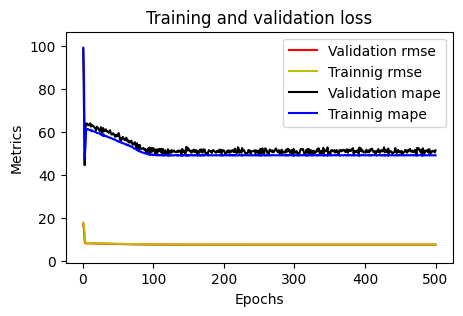

In [17]:
plotme(model1_1)

In [18]:
# inputs: distance
model1_3 = nnmodel(5,10, num_hlayers=1,Epoch=500)
model1_3

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 904938.0000 - distance_layer_loss: 0.3246 - traveltime_layer_loss: 1131172.3750 - distance_layer_mape: 131670.8281 - distance_layer_rmse: 0.5697 - traveltime_layer_mape: 99.5819 - traveltime_layer_rmse: 1063.5659 - val_loss: 860277.3750 - val_distance_layer_loss: 1.8184 - val_traveltime_layer_loss: 1075346.1250 - val_distance_layer_mape: 1113.3624 - val_distance_layer_rmse: 1.3485 - val_traveltime_layer_mape: 98.3385 - val_traveltime_layer_rmse: 1036.9890
Epoch 2/500
353/353 [==============================] - 0s 961us/step - loss: 836766.7500 - distance_layer_loss: 15.2706 - traveltime_layer_loss: 1045954.5625 - distance_layer_mape: 167731.4375 - distance_layer_rmse: 3.9078 - traveltime_layer_mape: 92.5693 - traveltime_layer_rmse: 1022.7192 - val_loss: 714546.7500 - val_distance_layer_loss: 40.9576 - val_traveltime_layer_loss: 893173.4375 - val_distance_layer_mape: 4871.8267 - val_distance_layer_rmse: 6.3998 - v

353/353 [==============================] - 0s 975us/step - loss: 183553.1719 - distance_layer_loss: 400.7583 - traveltime_layer_loss: 229341.3438 - distance_layer_mape: 1664524.3750 - distance_layer_rmse: 20.0189 - traveltime_layer_mape: 59.1869 - traveltime_layer_rmse: 478.8960 - val_loss: 179731.2344 - val_distance_layer_loss: 397.1078 - val_traveltime_layer_loss: 224564.6250 - val_distance_layer_mape: 14439.7441 - val_distance_layer_rmse: 19.9276 - val_traveltime_layer_mape: 59.7743 - val_traveltime_layer_rmse: 473.8825
Epoch 32/500
353/353 [==============================] - 0s 989us/step - loss: 183207.8594 - distance_layer_loss: 396.2092 - traveltime_layer_loss: 228910.7344 - distance_layer_mape: 1653950.3750 - distance_layer_rmse: 19.9050 - traveltime_layer_mape: 58.8194 - traveltime_layer_rmse: 478.4462 - val_loss: 179510.6875 - val_distance_layer_loss: 395.5654 - val_traveltime_layer_loss: 224289.5469 - val_distance_layer_mape: 14397.4756 - val_distance_layer_rmse: 19.8888 - va

353/353 [==============================] - 0s 1ms/step - loss: 173861.3594 - distance_layer_loss: 276.5981 - traveltime_layer_loss: 217257.5156 - distance_layer_mape: 1333113.6250 - distance_layer_rmse: 16.6312 - traveltime_layer_mape: 55.3775 - traveltime_layer_rmse: 466.1089 - val_loss: 170590.7969 - val_distance_layer_loss: 269.4568 - val_traveltime_layer_loss: 213171.1875 - val_distance_layer_mape: 11555.6357 - val_distance_layer_rmse: 16.4151 - val_traveltime_layer_mape: 55.1479 - val_traveltime_layer_rmse: 461.7047
Epoch 62/500
353/353 [==============================] - 0s 1ms/step - loss: 173536.9844 - distance_layer_loss: 272.3357 - traveltime_layer_loss: 216853.1250 - distance_layer_mape: 1323113.5000 - distance_layer_rmse: 16.5026 - traveltime_layer_mape: 55.2556 - traveltime_layer_rmse: 465.6749 - val_loss: 170380.2344 - val_distance_layer_loss: 266.3643 - val_traveltime_layer_loss: 212908.6719 - val_distance_layer_mape: 11477.6709 - val_distance_layer_rmse: 16.3207 - val_tr

353/353 [==============================] - 0s 951us/step - loss: 166787.3281 - distance_layer_loss: 169.7818 - traveltime_layer_loss: 208441.6719 - distance_layer_mape: 1010604.2500 - distance_layer_rmse: 13.0300 - traveltime_layer_mape: 51.3726 - traveltime_layer_rmse: 456.5541 - val_loss: 163955.5469 - val_distance_layer_loss: 168.2138 - val_traveltime_layer_loss: 204902.3906 - val_distance_layer_mape: 8840.1035 - val_distance_layer_rmse: 12.9697 - val_traveltime_layer_mape: 52.4524 - val_traveltime_layer_rmse: 452.6614
Epoch 92/500
353/353 [==============================] - 0s 992us/step - loss: 166597.7500 - distance_layer_loss: 167.7338 - traveltime_layer_loss: 208205.2500 - distance_layer_mape: 1017623.3125 - distance_layer_rmse: 12.9512 - traveltime_layer_mape: 51.6196 - traveltime_layer_rmse: 456.2951 - val_loss: 163444.9219 - val_distance_layer_loss: 162.3121 - val_traveltime_layer_loss: 204265.5469 - val_distance_layer_mape: 8665.8818 - val_distance_layer_rmse: 12.7402 - val_

353/353 [==============================] - 0s 995us/step - loss: 163028.5625 - distance_layer_loss: 118.7269 - traveltime_layer_loss: 203756.1406 - distance_layer_mape: 819647.7500 - distance_layer_rmse: 10.8962 - traveltime_layer_mape: 49.3109 - traveltime_layer_rmse: 451.3936 - val_loss: 159192.7500 - val_distance_layer_loss: 115.4061 - val_traveltime_layer_loss: 198962.0469 - val_distance_layer_mape: 7124.5708 - val_distance_layer_rmse: 10.7427 - val_traveltime_layer_mape: 48.7247 - val_traveltime_layer_rmse: 446.0516
Epoch 122/500
353/353 [==============================] - 0s 978us/step - loss: 163053.2812 - distance_layer_loss: 117.8434 - traveltime_layer_loss: 203787.1094 - distance_layer_mape: 824040.0000 - distance_layer_rmse: 10.8556 - traveltime_layer_mape: 49.1307 - traveltime_layer_rmse: 451.4279 - val_loss: 159180.4688 - val_distance_layer_loss: 115.3918 - val_traveltime_layer_loss: 198946.7812 - val_distance_layer_mape: 7123.3506 - val_distance_layer_rmse: 10.7421 - val_t

353/353 [==============================] - 0s 1ms/step - loss: 162721.5156 - distance_layer_loss: 109.9438 - traveltime_layer_loss: 203374.5312 - distance_layer_mape: 782978.7500 - distance_layer_rmse: 10.4854 - traveltime_layer_mape: 49.1141 - traveltime_layer_rmse: 450.9706 - val_loss: 158508.5938 - val_distance_layer_loss: 106.1225 - val_traveltime_layer_loss: 198109.2031 - val_distance_layer_mape: 6800.6367 - val_distance_layer_rmse: 10.3016 - val_traveltime_layer_mape: 48.0232 - val_traveltime_layer_rmse: 445.0946
Epoch 152/500
353/353 [==============================] - 0s 950us/step - loss: 162781.5312 - distance_layer_loss: 109.3732 - traveltime_layer_loss: 203449.5938 - distance_layer_mape: 785239.3750 - distance_layer_rmse: 10.4582 - traveltime_layer_mape: 48.8880 - traveltime_layer_rmse: 451.0539 - val_loss: 158643.2188 - val_distance_layer_loss: 108.1666 - val_traveltime_layer_loss: 198276.9844 - val_distance_layer_mape: 6873.7461 - val_distance_layer_rmse: 10.4003 - val_tra

353/353 [==============================] - 0s 979us/step - loss: 162743.3594 - distance_layer_loss: 108.2363 - traveltime_layer_loss: 203402.1094 - distance_layer_mape: 785728.0625 - distance_layer_rmse: 10.4037 - traveltime_layer_mape: 49.0562 - traveltime_layer_rmse: 451.0012 - val_loss: 158449.0781 - val_distance_layer_loss: 105.4482 - val_traveltime_layer_loss: 198035.0781 - val_distance_layer_mape: 6780.2798 - val_distance_layer_rmse: 10.2688 - val_traveltime_layer_mape: 48.4863 - val_traveltime_layer_rmse: 445.0113
Epoch 182/500
353/353 [==============================] - 0s 982us/step - loss: 162719.9844 - distance_layer_loss: 107.8596 - traveltime_layer_loss: 203373.0156 - distance_layer_mape: 780697.1250 - distance_layer_rmse: 10.3855 - traveltime_layer_mape: 48.9200 - traveltime_layer_rmse: 450.9690 - val_loss: 158838.3438 - val_distance_layer_loss: 108.2917 - val_traveltime_layer_loss: 198520.8281 - val_distance_layer_mape: 6881.4199 - val_distance_layer_rmse: 10.4063 - val_t

353/353 [==============================] - 0s 1ms/step - loss: 162728.3438 - distance_layer_loss: 107.9893 - traveltime_layer_loss: 203383.5312 - distance_layer_mape: 781274.0000 - distance_layer_rmse: 10.3918 - traveltime_layer_mape: 49.1460 - traveltime_layer_rmse: 450.9806 - val_loss: 158600.7969 - val_distance_layer_loss: 106.7519 - val_traveltime_layer_loss: 198224.2656 - val_distance_layer_mape: 6828.2988 - val_distance_layer_rmse: 10.3321 - val_traveltime_layer_mape: 49.4429 - val_traveltime_layer_rmse: 445.2238
Epoch 212/500
353/353 [==============================] - 0s 993us/step - loss: 162694.0938 - distance_layer_loss: 107.9827 - traveltime_layer_loss: 203340.5312 - distance_layer_mape: 781339.0000 - distance_layer_rmse: 10.3915 - traveltime_layer_mape: 49.1216 - traveltime_layer_rmse: 450.9330 - val_loss: 158488.5156 - val_distance_layer_loss: 105.8185 - val_traveltime_layer_loss: 198084.1562 - val_distance_layer_mape: 6794.8403 - val_distance_layer_rmse: 10.2868 - val_tra

353/353 [==============================] - 0s 998us/step - loss: 162725.8750 - distance_layer_loss: 107.6197 - traveltime_layer_loss: 203380.4844 - distance_layer_mape: 776369.1250 - distance_layer_rmse: 10.3740 - traveltime_layer_mape: 49.0735 - traveltime_layer_rmse: 450.9773 - val_loss: 158445.5469 - val_distance_layer_loss: 105.1141 - val_traveltime_layer_loss: 198030.6406 - val_distance_layer_mape: 6769.6260 - val_distance_layer_rmse: 10.2525 - val_traveltime_layer_mape: 48.5947 - val_traveltime_layer_rmse: 445.0063
Epoch 242/500
353/353 [==============================] - 0s 959us/step - loss: 162707.1875 - distance_layer_loss: 107.9952 - traveltime_layer_loss: 203356.8906 - distance_layer_mape: 781932.2500 - distance_layer_rmse: 10.3921 - traveltime_layer_mape: 49.2129 - traveltime_layer_rmse: 450.9511 - val_loss: 158426.2188 - val_distance_layer_loss: 103.6149 - val_traveltime_layer_loss: 198006.8281 - val_distance_layer_mape: 6716.5063 - val_distance_layer_rmse: 10.1791 - val_t

353/353 [==============================] - 0s 1ms/step - loss: 162749.0938 - distance_layer_loss: 107.6338 - traveltime_layer_loss: 203409.5156 - distance_layer_mape: 772737.8125 - distance_layer_rmse: 10.3747 - traveltime_layer_mape: 49.1480 - traveltime_layer_rmse: 451.0094 - val_loss: 158483.9375 - val_distance_layer_loss: 105.5559 - val_traveltime_layer_loss: 198078.5625 - val_distance_layer_mape: 6786.0239 - val_distance_layer_rmse: 10.2740 - val_traveltime_layer_mape: 48.8835 - val_traveltime_layer_rmse: 445.0602
Epoch 272/500
353/353 [==============================] - 0s 1ms/step - loss: 162686.4375 - distance_layer_loss: 107.6180 - traveltime_layer_loss: 203331.1250 - distance_layer_mape: 773507.4375 - distance_layer_rmse: 10.3739 - traveltime_layer_mape: 49.0895 - traveltime_layer_rmse: 450.9225 - val_loss: 158425.0938 - val_distance_layer_loss: 104.5986 - val_traveltime_layer_loss: 198005.2500 - val_distance_layer_mape: 6751.6235 - val_distance_layer_rmse: 10.2273 - val_trave

353/353 [==============================] - 0s 942us/step - loss: 162687.2188 - distance_layer_loss: 107.4498 - traveltime_layer_loss: 203332.1250 - distance_layer_mape: 776861.2500 - distance_layer_rmse: 10.3658 - traveltime_layer_mape: 49.0282 - traveltime_layer_rmse: 450.9236 - val_loss: 158807.5469 - val_distance_layer_loss: 107.4753 - val_traveltime_layer_loss: 198482.6094 - val_distance_layer_mape: 6854.8926 - val_distance_layer_rmse: 10.3670 - val_traveltime_layer_mape: 50.0858 - val_traveltime_layer_rmse: 445.5139
Epoch 302/500
353/353 [==============================] - 0s 997us/step - loss: 162667.2188 - distance_layer_loss: 107.2142 - traveltime_layer_loss: 203307.0625 - distance_layer_mape: 769921.7500 - distance_layer_rmse: 10.3544 - traveltime_layer_mape: 48.9234 - traveltime_layer_rmse: 450.8958 - val_loss: 159082.7656 - val_distance_layer_loss: 108.6304 - val_traveltime_layer_loss: 198826.1875 - val_distance_layer_mape: 6895.5532 - val_distance_layer_rmse: 10.4226 - val_t

353/353 [==============================] - 0s 981us/step - loss: 162709.4375 - distance_layer_loss: 107.5498 - traveltime_layer_loss: 203359.9531 - distance_layer_mape: 789812.1875 - distance_layer_rmse: 10.3706 - traveltime_layer_mape: 49.1082 - traveltime_layer_rmse: 450.9545 - val_loss: 158578.2812 - val_distance_layer_loss: 106.1029 - val_traveltime_layer_loss: 198196.3594 - val_distance_layer_mape: 6805.6113 - val_distance_layer_rmse: 10.3006 - val_traveltime_layer_mape: 49.3353 - val_traveltime_layer_rmse: 445.1925
Epoch 332/500
353/353 [==============================] - 0s 1ms/step - loss: 162694.7656 - distance_layer_loss: 107.5667 - traveltime_layer_loss: 203341.5469 - distance_layer_mape: 774190.2500 - distance_layer_rmse: 10.3714 - traveltime_layer_mape: 49.1222 - traveltime_layer_rmse: 450.9341 - val_loss: 158509.5000 - val_distance_layer_loss: 105.5583 - val_traveltime_layer_loss: 198110.5469 - val_distance_layer_mape: 6786.2534 - val_distance_layer_rmse: 10.2742 - val_tra

353/353 [==============================] - 0s 985us/step - loss: 162726.3906 - distance_layer_loss: 107.5770 - traveltime_layer_loss: 203381.1250 - distance_layer_mape: 773166.6250 - distance_layer_rmse: 10.3719 - traveltime_layer_mape: 49.1405 - traveltime_layer_rmse: 450.9780 - val_loss: 158632.4531 - val_distance_layer_loss: 106.4487 - val_traveltime_layer_loss: 198263.9062 - val_distance_layer_mape: 6818.6548 - val_distance_layer_rmse: 10.3174 - val_traveltime_layer_mape: 49.5393 - val_traveltime_layer_rmse: 445.2683
Epoch 362/500
353/353 [==============================] - 0s 997us/step - loss: 162729.0781 - distance_layer_loss: 107.4212 - traveltime_layer_loss: 203384.5000 - distance_layer_mape: 776029.6250 - distance_layer_rmse: 10.3644 - traveltime_layer_mape: 49.1301 - traveltime_layer_rmse: 450.9817 - val_loss: 158428.2656 - val_distance_layer_loss: 104.4492 - val_traveltime_layer_loss: 198009.2344 - val_distance_layer_mape: 6746.5679 - val_distance_layer_rmse: 10.2200 - val_t

353/353 [==============================] - 0s 1ms/step - loss: 162721.2812 - distance_layer_loss: 107.1230 - traveltime_layer_loss: 203374.7500 - distance_layer_mape: 779148.3125 - distance_layer_rmse: 10.3500 - traveltime_layer_mape: 49.0087 - traveltime_layer_rmse: 450.9709 - val_loss: 158548.3281 - val_distance_layer_loss: 105.7556 - val_traveltime_layer_loss: 198158.9219 - val_distance_layer_mape: 6793.8193 - val_distance_layer_rmse: 10.2838 - val_traveltime_layer_mape: 49.2055 - val_traveltime_layer_rmse: 445.1505
Epoch 392/500
353/353 [==============================] - 0s 977us/step - loss: 162746.4375 - distance_layer_loss: 107.3256 - traveltime_layer_loss: 203406.1406 - distance_layer_mape: 777369.0000 - distance_layer_rmse: 10.3598 - traveltime_layer_mape: 49.1700 - traveltime_layer_rmse: 451.0057 - val_loss: 158567.8750 - val_distance_layer_loss: 105.8858 - val_traveltime_layer_loss: 198183.3281 - val_distance_layer_mape: 6798.1089 - val_distance_layer_rmse: 10.2901 - val_tra

353/353 [==============================] - 0s 981us/step - loss: 162702.1719 - distance_layer_loss: 107.1676 - traveltime_layer_loss: 203351.0781 - distance_layer_mape: 779497.0625 - distance_layer_rmse: 10.3522 - traveltime_layer_mape: 49.0591 - traveltime_layer_rmse: 450.9446 - val_loss: 158417.6719 - val_distance_layer_loss: 103.5716 - val_traveltime_layer_loss: 197996.2656 - val_distance_layer_mape: 6715.5435 - val_distance_layer_rmse: 10.1770 - val_traveltime_layer_mape: 47.9893 - val_traveltime_layer_rmse: 444.9677
Epoch 422/500
353/353 [==============================] - 0s 1000us/step - loss: 162723.6406 - distance_layer_loss: 107.0569 - traveltime_layer_loss: 203377.7188 - distance_layer_mape: 779881.8750 - distance_layer_rmse: 10.3468 - traveltime_layer_mape: 49.0326 - traveltime_layer_rmse: 450.9742 - val_loss: 158480.4688 - val_distance_layer_loss: 104.9955 - val_traveltime_layer_loss: 198074.3125 - val_distance_layer_mape: 6766.2822 - val_distance_layer_rmse: 10.2467 - val_

353/353 [==============================] - 0s 1ms/step - loss: 162724.6406 - distance_layer_loss: 107.3099 - traveltime_layer_loss: 203379.0156 - distance_layer_mape: 781658.1875 - distance_layer_rmse: 10.3590 - traveltime_layer_mape: 49.2241 - traveltime_layer_rmse: 450.9756 - val_loss: 158478.9688 - val_distance_layer_loss: 104.8833 - val_traveltime_layer_loss: 198072.5625 - val_distance_layer_mape: 6763.2266 - val_distance_layer_rmse: 10.2413 - val_traveltime_layer_mape: 48.8201 - val_traveltime_layer_rmse: 445.0534
Epoch 452/500
353/353 [==============================] - 0s 996us/step - loss: 162708.1875 - distance_layer_loss: 106.5929 - traveltime_layer_loss: 203358.5312 - distance_layer_mape: 774186.0625 - distance_layer_rmse: 10.3244 - traveltime_layer_mape: 48.8401 - traveltime_layer_rmse: 450.9529 - val_loss: 158660.3125 - val_distance_layer_loss: 106.3273 - val_traveltime_layer_loss: 198298.7188 - val_distance_layer_mape: 6815.0425 - val_distance_layer_rmse: 10.3115 - val_tra

353/353 [==============================] - 0s 969us/step - loss: 162738.3281 - distance_layer_loss: 107.1020 - traveltime_layer_loss: 203396.0625 - distance_layer_mape: 778573.2500 - distance_layer_rmse: 10.3490 - traveltime_layer_mape: 49.1178 - traveltime_layer_rmse: 450.9945 - val_loss: 158472.6875 - val_distance_layer_loss: 104.8566 - val_traveltime_layer_loss: 198064.6719 - val_distance_layer_mape: 6761.4277 - val_distance_layer_rmse: 10.2400 - val_traveltime_layer_mape: 48.7939 - val_traveltime_layer_rmse: 445.0446
Epoch 482/500
353/353 [==============================] - 0s 1ms/step - loss: 162721.4062 - distance_layer_loss: 107.0787 - traveltime_layer_loss: 203374.9531 - distance_layer_mape: 779477.5625 - distance_layer_rmse: 10.3479 - traveltime_layer_mape: 49.0451 - traveltime_layer_rmse: 450.9711 - val_loss: 158495.6719 - val_distance_layer_loss: 105.1175 - val_traveltime_layer_loss: 198093.3594 - val_distance_layer_mape: 6770.9619 - val_distance_layer_rmse: 10.2527 - val_tra

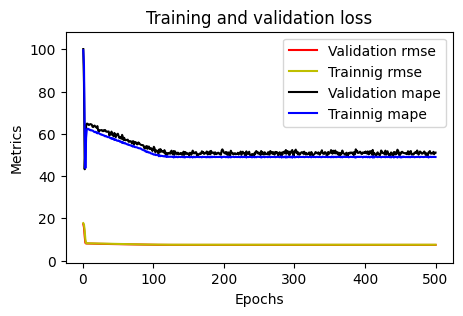

In [19]:
plotme(model1_3)
#val_loss2 = [x+1.8 for x in val_loss2]

In [20]:
# inputs: distance
model1_4 = nnmodel(10,10, num_hlayers=1,Epoch=500)
model1_4

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 909041.3125 - distance_layer_loss: 0.0741 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 24272.0059 - distance_layer_rmse: 0.2722 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0463 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 121.8264 - val_distance_layer_rmse: 0.2152 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 2/500
353/353 [==============================] - 0s 1ms/step - loss: 909041.9375 - distance_layer_loss: 0.0439 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 21077.7910 - distance_layer_rmse: 0.2094 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0392 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 120.9255 - val_distance_layer_rmse: 0.1979 - val_t

353/353 [==============================] - 0s 980us/step - loss: 909042.1250 - distance_layer_loss: 0.0069 - traveltime_layer_loss: 1136303.0000 - distance_layer_mape: 6537.4087 - distance_layer_rmse: 0.0829 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0070 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 21.4469 - val_distance_layer_rmse: 0.0836 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 32/500
353/353 [==============================] - 0s 1ms/step - loss: 909041.6875 - distance_layer_loss: 0.0069 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 4842.7964 - distance_layer_rmse: 0.0830 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0069 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 29.3933 - val_distance_layer_rmse: 0.0829 - val_traveltime_lay

353/353 [==============================] - 0s 996us/step - loss: 909041.8750 - distance_layer_loss: 0.0065 - traveltime_layer_loss: 1136303.1250 - distance_layer_mape: 6718.4214 - distance_layer_rmse: 0.0805 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9752 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0062 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 22.7493 - val_distance_layer_rmse: 0.0791 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 62/500
353/353 [==============================] - 0s 994us/step - loss: 909041.7500 - distance_layer_loss: 0.0064 - traveltime_layer_loss: 1136301.7500 - distance_layer_mape: 5912.3457 - distance_layer_rmse: 0.0803 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9746 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0062 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 23.2265 - val_distance_layer_rmse: 0.0789 - val_traveltime_l

353/353 [==============================] - 0s 1ms/step - loss: 909041.5625 - distance_layer_loss: 0.0062 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 4887.0884 - distance_layer_rmse: 0.0788 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0060 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 22.9939 - val_distance_layer_rmse: 0.0777 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 92/500
353/353 [==============================] - 0s 971us/step - loss: 909041.9375 - distance_layer_loss: 0.0062 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 4195.9233 - distance_layer_rmse: 0.0786 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0066 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 23.5336 - val_distance_layer_rmse: 0.0813 - val_traveltime_lay

353/353 [==============================] - 0s 1ms/step - loss: 909042.2500 - distance_layer_loss: 0.0060 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 5262.2285 - distance_layer_rmse: 0.0778 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0060 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 22.5250 - val_distance_layer_rmse: 0.0772 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 122/500
353/353 [==============================] - 0s 993us/step - loss: 909042.0625 - distance_layer_loss: 0.0061 - traveltime_layer_loss: 1136303.2500 - distance_layer_mape: 6074.7251 - distance_layer_rmse: 0.0780 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9752 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0060 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 21.5985 - val_distance_layer_rmse: 0.0776 - val_traveltime_la

353/353 [==============================] - 0s 1ms/step - loss: 909041.7500 - distance_layer_loss: 0.0060 - traveltime_layer_loss: 1136301.7500 - distance_layer_mape: 5640.5054 - distance_layer_rmse: 0.0777 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9746 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0059 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 24.6802 - val_distance_layer_rmse: 0.0770 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 152/500
353/353 [==============================] - 0s 1ms/step - loss: 909042.1250 - distance_layer_loss: 0.0060 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 5006.2471 - distance_layer_rmse: 0.0772 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0059 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 23.8515 - val_distance_layer_rmse: 0.0765 - val_traveltime_laye

353/353 [==============================] - 0s 988us/step - loss: 909041.9375 - distance_layer_loss: 0.0059 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 4882.1777 - distance_layer_rmse: 0.0769 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0060 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 26.4837 - val_distance_layer_rmse: 0.0774 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 182/500
353/353 [==============================] - 0s 980us/step - loss: 909041.8750 - distance_layer_loss: 0.0059 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 5080.7817 - distance_layer_rmse: 0.0770 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0059 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 23.6223 - val_distance_layer_rmse: 0.0765 - val_traveltime_

353/353 [==============================] - 0s 1ms/step - loss: 909042.0625 - distance_layer_loss: 0.0059 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 4185.6611 - distance_layer_rmse: 0.0770 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 24.1424 - val_distance_layer_rmse: 0.0761 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 212/500
353/353 [==============================] - 0s 1ms/step - loss: 909041.6875 - distance_layer_loss: 0.0059 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 3939.1731 - distance_layer_rmse: 0.0770 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 24.5543 - val_distance_layer_rmse: 0.0763 - val_traveltime_laye

353/353 [==============================] - 0s 990us/step - loss: 909041.7500 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.8750 - distance_layer_mape: 4919.4971 - distance_layer_rmse: 0.0764 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0060 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 23.5826 - val_distance_layer_rmse: 0.0773 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 242/500
353/353 [==============================] - 0s 986us/step - loss: 909041.8750 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.8750 - distance_layer_mape: 5930.5410 - distance_layer_rmse: 0.0765 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 25.0303 - val_distance_layer_rmse: 0.0763 - val_traveltime_

353/353 [==============================] - 0s 1ms/step - loss: 909041.8750 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 5602.2578 - distance_layer_rmse: 0.0764 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 21.4823 - val_distance_layer_rmse: 0.0760 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 272/500
353/353 [==============================] - 0s 1ms/step - loss: 909042.5625 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.7500 - distance_layer_mape: 5812.7402 - distance_layer_rmse: 0.0763 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0057 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 21.8287 - val_distance_layer_rmse: 0.0758 - val_traveltime_laye

353/353 [==============================] - 0s 1ms/step - loss: 909042.3750 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.7500 - distance_layer_mape: 5300.2852 - distance_layer_rmse: 0.0763 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 25.3642 - val_distance_layer_rmse: 0.0763 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 302/500
353/353 [==============================] - 0s 990us/step - loss: 909042.1250 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 3885.9419 - distance_layer_rmse: 0.0763 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 24.2224 - val_distance_layer_rmse: 0.0762 - val_traveltime_la

353/353 [==============================] - 0s 994us/step - loss: 909041.9375 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 5237.7573 - distance_layer_rmse: 0.0765 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 24.3691 - val_distance_layer_rmse: 0.0761 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 332/500
353/353 [==============================] - 0s 990us/step - loss: 909041.5000 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 5664.5356 - distance_layer_rmse: 0.0761 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 21.6700 - val_distance_layer_rmse: 0.0762 - val_traveltime_

353/353 [==============================] - 0s 1ms/step - loss: 909041.7500 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 5465.0518 - distance_layer_rmse: 0.0763 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 24.2145 - val_distance_layer_rmse: 0.0760 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 362/500
353/353 [==============================] - 0s 1ms/step - loss: 909042.5000 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6190.3584 - distance_layer_rmse: 0.0759 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0057 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 22.6957 - val_distance_layer_rmse: 0.0758 - val_traveltime_laye

353/353 [==============================] - 0s 1ms/step - loss: 909042.0625 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.7500 - distance_layer_mape: 5588.1772 - distance_layer_rmse: 0.0759 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0060 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 23.6538 - val_distance_layer_rmse: 0.0777 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 392/500
353/353 [==============================] - 0s 1ms/step - loss: 909042.1250 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 4633.6943 - distance_layer_rmse: 0.0759 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 22.2979 - val_distance_layer_rmse: 0.0760 - val_traveltime_laye

353/353 [==============================] - 0s 1ms/step - loss: 909042.3125 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 5080.2788 - distance_layer_rmse: 0.0758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 23.6533 - val_distance_layer_rmse: 0.0761 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 422/500
353/353 [==============================] - 0s 972us/step - loss: 909041.8750 - distance_layer_loss: 0.0058 - traveltime_layer_loss: 1136301.6250 - distance_layer_mape: 4592.5342 - distance_layer_rmse: 0.0761 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9745 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0060 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 22.3069 - val_distance_layer_rmse: 0.0773 - val_traveltime_la

353/353 [==============================] - 0s 976us/step - loss: 909041.3750 - distance_layer_loss: 0.0057 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 4316.1973 - distance_layer_rmse: 0.0757 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0060 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 22.4050 - val_distance_layer_rmse: 0.0773 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 452/500
353/353 [==============================] - 0s 1ms/step - loss: 909041.7500 - distance_layer_loss: 0.0057 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 4607.4233 - distance_layer_rmse: 0.0758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0059 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 25.2452 - val_distance_layer_rmse: 0.0765 - val_traveltime_la

353/353 [==============================] - 0s 976us/step - loss: 909041.9375 - distance_layer_loss: 0.0057 - traveltime_layer_loss: 1136303.0000 - distance_layer_mape: 4866.4121 - distance_layer_rmse: 0.0757 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 21.8587 - val_distance_layer_rmse: 0.0763 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 482/500
353/353 [==============================] - 0s 970us/step - loss: 909042.5000 - distance_layer_loss: 0.0057 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 3680.5913 - distance_layer_rmse: 0.0755 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 22.6512 - val_distance_layer_rmse: 0.0764 - val_traveltime_

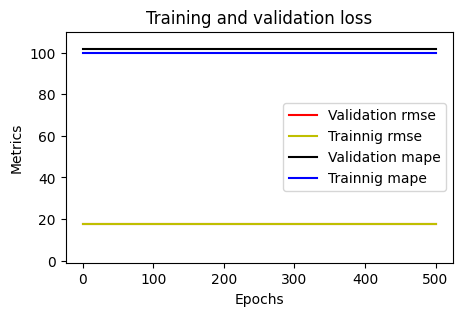

In [21]:
plotme(model1_4)

In [22]:
# inputs: distance
model1_44 = nnmodel(10,20, num_hlayers=1,Epoch=500)
model1_44

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 909041.7500 - distance_layer_loss: 0.0317 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 29260.0020 - distance_layer_rmse: 0.1780 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0234 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 87.9667 - val_distance_layer_rmse: 0.1529 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 2/500
353/353 [==============================] - 0s 963us/step - loss: 909042.3125 - distance_layer_loss: 0.0194 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 15920.8027 - distance_layer_rmse: 0.1393 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0142 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 65.8501 - val_distance_layer_rmse: 0.1193 - val_t

353/353 [==============================] - 0s 969us/step - loss: 909041.9375 - distance_layer_loss: 7.4406e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6817.4639 - distance_layer_rmse: 0.0273 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 7.5736e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 17.0599 - val_distance_layer_rmse: 0.0275 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 32/500
353/353 [==============================] - 0s 957us/step - loss: 909042.2500 - distance_layer_loss: 7.1826e-04 - traveltime_layer_loss: 1136302.7500 - distance_layer_mape: 6618.7817 - distance_layer_rmse: 0.0268 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 6.7709e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 14.2952 - val_distance_layer_rmse: 0.0260 - 

353/353 [==============================] - 0s 972us/step - loss: 909041.7500 - distance_layer_loss: 4.7852e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6385.8369 - distance_layer_rmse: 0.0219 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 4.5461e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.4319 - val_distance_layer_rmse: 0.0213 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 62/500
353/353 [==============================] - 0s 959us/step - loss: 909042.0625 - distance_layer_loss: 4.7136e-04 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 6456.9941 - distance_layer_rmse: 0.0217 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 5.3806e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 14.6501 - val_distance_layer_rmse: 0.0232 - 

353/353 [==============================] - 0s 969us/step - loss: 909042.2500 - distance_layer_loss: 4.5793e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6905.0752 - distance_layer_rmse: 0.0214 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 5.0357e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 14.6122 - val_distance_layer_rmse: 0.0224 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 92/500
353/353 [==============================] - 0s 962us/step - loss: 909041.7500 - distance_layer_loss: 4.5590e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6500.2324 - distance_layer_rmse: 0.0214 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.9286e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 13.0550 - val_distance_layer_rmse: 0.0222 - 

353/353 [==============================] - 0s 969us/step - loss: 909042.2500 - distance_layer_loss: 4.4672e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6213.2891 - distance_layer_rmse: 0.0211 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 4.6448e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 13.5284 - val_distance_layer_rmse: 0.0216 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 122/500
353/353 [==============================] - 0s 975us/step - loss: 909041.7500 - distance_layer_loss: 4.4478e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6338.3730 - distance_layer_rmse: 0.0211 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 4.6138e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.6007 - val_distance_layer_rmse: 0.0215 -

353/353 [==============================] - 0s 967us/step - loss: 909042.0625 - distance_layer_loss: 4.4945e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6582.7686 - distance_layer_rmse: 0.0212 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.3134e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.7911 - val_distance_layer_rmse: 0.0208 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 152/500
353/353 [==============================] - 0s 967us/step - loss: 909042.5000 - distance_layer_loss: 4.4978e-04 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 5161.4492 - distance_layer_rmse: 0.0212 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.4292e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 9.7823 - val_distance_layer_rmse: 0.0210 - 

353/353 [==============================] - 0s 968us/step - loss: 909042.3125 - distance_layer_loss: 4.5428e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6386.1011 - distance_layer_rmse: 0.0213 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 4.3690e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.1110 - val_distance_layer_rmse: 0.0209 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 182/500
353/353 [==============================] - 0s 950us/step - loss: 909042.0625 - distance_layer_loss: 4.4970e-04 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 6507.9297 - distance_layer_rmse: 0.0212 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.6642e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.4264 - val_distance_layer_rmse: 0.0216 -

353/353 [==============================] - 0s 1ms/step - loss: 909042.3750 - distance_layer_loss: 4.5266e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6573.1558 - distance_layer_rmse: 0.0213 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.2307e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.5573 - val_distance_layer_rmse: 0.0206 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 212/500
353/353 [==============================] - 0s 1ms/step - loss: 909042.1250 - distance_layer_loss: 4.5778e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6155.8682 - distance_layer_rmse: 0.0214 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 5.8711e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 15.2293 - val_distance_layer_rmse: 0.0242 - val

353/353 [==============================] - 0s 967us/step - loss: 909041.7500 - distance_layer_loss: 4.3367e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6561.7715 - distance_layer_rmse: 0.0208 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.0452e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.6379 - val_distance_layer_rmse: 0.0201 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 242/500
353/353 [==============================] - 0s 982us/step - loss: 909042.3125 - distance_layer_loss: 4.2626e-04 - traveltime_layer_loss: 1136303.0000 - distance_layer_mape: 6960.6929 - distance_layer_rmse: 0.0206 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 4.1676e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.9601 - val_distance_layer_rmse: 0.0204 -

353/353 [==============================] - 0s 1ms/step - loss: 909042.1250 - distance_layer_loss: 4.3180e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 5556.2290 - distance_layer_rmse: 0.0208 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.2381e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.0075 - val_distance_layer_rmse: 0.0206 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 272/500
353/353 [==============================] - 0s 987us/step - loss: 909041.7500 - distance_layer_loss: 4.3060e-04 - traveltime_layer_loss: 1136302.7500 - distance_layer_mape: 5792.0562 - distance_layer_rmse: 0.0208 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.0354e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.1687 - val_distance_layer_rmse: 0.0201 - v

353/353 [==============================] - 0s 970us/step - loss: 909041.6875 - distance_layer_loss: 4.2664e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 5175.8525 - distance_layer_rmse: 0.0207 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.9157e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.7472 - val_distance_layer_rmse: 0.0198 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 302/500
353/353 [==============================] - 0s 987us/step - loss: 909042.3125 - distance_layer_loss: 4.2022e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 5600.1089 - distance_layer_rmse: 0.0205 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.2369e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.5402 - val_distance_layer_rmse: 0.0206 -

353/353 [==============================] - 0s 1ms/step - loss: 909041.8750 - distance_layer_loss: 4.1716e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 5753.0957 - distance_layer_rmse: 0.0204 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.9201e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.0766 - val_distance_layer_rmse: 0.0198 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 332/500
353/353 [==============================] - 0s 964us/step - loss: 909042.0625 - distance_layer_loss: 4.2374e-04 - traveltime_layer_loss: 1136303.1250 - distance_layer_mape: 4954.0693 - distance_layer_rmse: 0.0206 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9752 - val_loss: 876251.4375 - val_distance_layer_loss: 4.2479e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.5898 - val_distance_layer_rmse: 0.0206 - v

353/353 [==============================] - 0s 982us/step - loss: 909041.8750 - distance_layer_loss: 4.1600e-04 - traveltime_layer_loss: 1136303.0000 - distance_layer_mape: 6206.1240 - distance_layer_rmse: 0.0204 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 4.1672e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 9.6273 - val_distance_layer_rmse: 0.0204 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 362/500
353/353 [==============================] - 0s 972us/step - loss: 909042.3750 - distance_layer_loss: 4.1523e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 5777.2983 - distance_layer_rmse: 0.0204 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.9785e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.4358 - val_distance_layer_rmse: 0.0199 - 

353/353 [==============================] - 0s 966us/step - loss: 909042.2500 - distance_layer_loss: 4.1665e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 5419.1489 - distance_layer_rmse: 0.0204 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.2116e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.0927 - val_distance_layer_rmse: 0.0205 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 392/500
353/353 [==============================] - 0s 954us/step - loss: 909042.3750 - distance_layer_loss: 4.1884e-04 - traveltime_layer_loss: 1136301.8750 - distance_layer_mape: 6526.3994 - distance_layer_rmse: 0.0205 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9746 - val_loss: 876251.4375 - val_distance_layer_loss: 3.8666e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 9.8034 - val_distance_layer_rmse: 0.0197 - 

353/353 [==============================] - 0s 992us/step - loss: 909041.7500 - distance_layer_loss: 4.1783e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 5213.4248 - distance_layer_rmse: 0.0204 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.8927e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.0755 - val_distance_layer_rmse: 0.0197 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 422/500
353/353 [==============================] - 0s 976us/step - loss: 909041.7500 - distance_layer_loss: 4.1854e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6011.6797 - distance_layer_rmse: 0.0205 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.9614e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.3385 - val_distance_layer_rmse: 0.0199 -

353/353 [==============================] - 0s 979us/step - loss: 909041.9375 - distance_layer_loss: 4.1505e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 5431.0581 - distance_layer_rmse: 0.0204 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.8838e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 9.6898 - val_distance_layer_rmse: 0.0197 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 452/500
353/353 [==============================] - 0s 954us/step - loss: 909042.3125 - distance_layer_loss: 4.1761e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 4835.1948 - distance_layer_rmse: 0.0204 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.9523e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 9.6303 - val_distance_layer_rmse: 0.0199 - v

353/353 [==============================] - 0s 948us/step - loss: 909041.8750 - distance_layer_loss: 4.2007e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 4808.4614 - distance_layer_rmse: 0.0205 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.8525e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.1944 - val_distance_layer_rmse: 0.0196 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 482/500
353/353 [==============================] - 0s 976us/step - loss: 909042.2500 - distance_layer_loss: 4.1821e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 5700.3867 - distance_layer_rmse: 0.0205 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.8640e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.9469 - val_distance_layer_rmse: 0.0197 -

In [23]:
# inputs: distance
model1_5 = nnmodel(20,30, num_hlayers=1,Epoch=500)
model1_5

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 909041.6875 - distance_layer_loss: 0.0249 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 16819.7656 - distance_layer_rmse: 0.1579 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0161 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 63.3506 - val_distance_layer_rmse: 0.1269 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 2/500
353/353 [==============================] - 0s 1ms/step - loss: 909041.9375 - distance_layer_loss: 0.0131 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 11208.4629 - distance_layer_rmse: 0.1145 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0095 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 38.0102 - val_distance_layer_rmse: 0.0973 - val_tra

353/353 [==============================] - 0s 972us/step - loss: 909042.0625 - distance_layer_loss: 4.5589e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 6788.8301 - distance_layer_rmse: 0.0214 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.7554e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.6471 - val_distance_layer_rmse: 0.0218 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 32/500
353/353 [==============================] - 0s 976us/step - loss: 909042.0625 - distance_layer_loss: 4.5408e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 7057.6387 - distance_layer_rmse: 0.0213 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.3592e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.2724 - val_distance_layer_rmse: 0.0209 - 

353/353 [==============================] - 0s 979us/step - loss: 909041.6875 - distance_layer_loss: 3.9334e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6386.9604 - distance_layer_rmse: 0.0198 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.4920e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.8717 - val_distance_layer_rmse: 0.0187 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 62/500
353/353 [==============================] - 0s 959us/step - loss: 909042.3750 - distance_layer_loss: 3.8834e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 6649.5430 - distance_layer_rmse: 0.0197 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.0733e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.7748 - val_distance_layer_rmse: 0.0202 - 

353/353 [==============================] - 0s 972us/step - loss: 909042.0625 - distance_layer_loss: 3.8535e-04 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 6442.8301 - distance_layer_rmse: 0.0196 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.7881e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.0214 - val_distance_layer_rmse: 0.0195 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 92/500
353/353 [==============================] - 0s 988us/step - loss: 909041.8750 - distance_layer_loss: 3.8235e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 7319.0454 - distance_layer_rmse: 0.0196 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.4699e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.7163 - val_distance_layer_rmse: 0.0186 - 

353/353 [==============================] - 0s 976us/step - loss: 909041.3125 - distance_layer_loss: 3.7398e-04 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 6576.9775 - distance_layer_rmse: 0.0193 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.7121e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.8657 - val_distance_layer_rmse: 0.0193 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 122/500
353/353 [==============================] - 0s 975us/step - loss: 909041.6875 - distance_layer_loss: 3.8288e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6576.7842 - distance_layer_rmse: 0.0196 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.4845e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.7159 - val_distance_layer_rmse: 0.0187 -

353/353 [==============================] - 0s 970us/step - loss: 909042.5000 - distance_layer_loss: 3.7307e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 7411.8267 - distance_layer_rmse: 0.0193 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.3709e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.6635 - val_distance_layer_rmse: 0.0184 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 152/500
353/353 [==============================] - 0s 969us/step - loss: 909041.9375 - distance_layer_loss: 3.7166e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 7136.7246 - distance_layer_rmse: 0.0193 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.3925e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.8317 - val_distance_layer_rmse: 0.0184 -

353/353 [==============================] - 0s 966us/step - loss: 909041.5000 - distance_layer_loss: 3.8085e-04 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 6596.1699 - distance_layer_rmse: 0.0195 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.4873e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 9.8473 - val_distance_layer_rmse: 0.0187 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 182/500
353/353 [==============================] - 0s 966us/step - loss: 909042.2500 - distance_layer_loss: 3.8054e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 7510.8369 - distance_layer_rmse: 0.0195 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.3422e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.4193 - val_distance_layer_rmse: 0.0183 - 

353/353 [==============================] - 0s 973us/step - loss: 909041.5625 - distance_layer_loss: 3.7098e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 6511.4888 - distance_layer_rmse: 0.0193 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.2755e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.0176 - val_distance_layer_rmse: 0.0181 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 212/500
353/353 [==============================] - 0s 963us/step - loss: 909042.0625 - distance_layer_loss: 3.7143e-04 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 5552.0010 - distance_layer_rmse: 0.0193 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.2190e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.0669 - val_distance_layer_rmse: 0.0179 -

353/353 [==============================] - 0s 990us/step - loss: 909041.7500 - distance_layer_loss: 3.6495e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6523.5356 - distance_layer_rmse: 0.0191 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.3688e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.9979 - val_distance_layer_rmse: 0.0184 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 242/500
353/353 [==============================] - 0s 970us/step - loss: 909041.6875 - distance_layer_loss: 3.7054e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 7965.8037 - distance_layer_rmse: 0.0192 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.7296e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.6716 - val_distance_layer_rmse: 0.0193 -

353/353 [==============================] - 0s 974us/step - loss: 909042.0625 - distance_layer_loss: 3.7040e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6524.2183 - distance_layer_rmse: 0.0192 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.7438e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.0149 - val_distance_layer_rmse: 0.0193 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 272/500
353/353 [==============================] - 0s 963us/step - loss: 909042.2500 - distance_layer_loss: 3.6550e-04 - traveltime_layer_loss: 1136303.0000 - distance_layer_mape: 6171.8677 - distance_layer_rmse: 0.0191 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 3.2708e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.5960 - val_distance_layer_rmse: 0.0181 -

353/353 [==============================] - 0s 1ms/step - loss: 909042.1250 - distance_layer_loss: 3.6639e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6500.3809 - distance_layer_rmse: 0.0191 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.2844e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.8627 - val_distance_layer_rmse: 0.0181 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 302/500
353/353 [==============================] - 0s 1ms/step - loss: 909042.0625 - distance_layer_loss: 3.6574e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6870.4531 - distance_layer_rmse: 0.0191 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.3649e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.1686 - val_distance_layer_rmse: 0.0183 - val

353/353 [==============================] - 0s 982us/step - loss: 909042.0625 - distance_layer_loss: 3.6807e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6893.0459 - distance_layer_rmse: 0.0192 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.5851e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.8941 - val_distance_layer_rmse: 0.0189 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 332/500
353/353 [==============================] - 0s 964us/step - loss: 909041.7500 - distance_layer_loss: 3.7223e-04 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 7813.1182 - distance_layer_rmse: 0.0193 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.3798e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 9.9190 - val_distance_layer_rmse: 0.0184 - 

353/353 [==============================] - 0s 966us/step - loss: 909042.1250 - distance_layer_loss: 3.6693e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 6651.1382 - distance_layer_rmse: 0.0192 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.2502e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.1910 - val_distance_layer_rmse: 0.0180 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 362/500
353/353 [==============================] - 0s 970us/step - loss: 909041.5000 - distance_layer_loss: 3.6389e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 7352.8618 - distance_layer_rmse: 0.0191 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.1488e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.4646 - val_distance_layer_rmse: 0.0177 -

353/353 [==============================] - 0s 963us/step - loss: 909042.0625 - distance_layer_loss: 3.6112e-04 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 6704.5845 - distance_layer_rmse: 0.0190 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.4618e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 9.6588 - val_distance_layer_rmse: 0.0186 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 392/500
353/353 [==============================] - 0s 962us/step - loss: 909041.5625 - distance_layer_loss: 3.6346e-04 - traveltime_layer_loss: 1136303.0000 - distance_layer_mape: 6124.1606 - distance_layer_rmse: 0.0191 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 3.2020e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.3903 - val_distance_layer_rmse: 0.0179 - 

353/353 [==============================] - 0s 963us/step - loss: 909041.8750 - distance_layer_loss: 3.7197e-04 - traveltime_layer_loss: 1136303.0000 - distance_layer_mape: 6707.7095 - distance_layer_rmse: 0.0193 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 3.3176e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.3604 - val_distance_layer_rmse: 0.0182 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 422/500
353/353 [==============================] - 0s 985us/step - loss: 909041.7500 - distance_layer_loss: 3.6737e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 7624.3281 - distance_layer_rmse: 0.0192 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.2305e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.8144 - val_distance_layer_rmse: 0.0180 -

353/353 [==============================] - 0s 981us/step - loss: 909042.3125 - distance_layer_loss: 3.5517e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 6968.6982 - distance_layer_rmse: 0.0188 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.3774e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.2024 - val_distance_layer_rmse: 0.0184 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 452/500
353/353 [==============================] - 0s 983us/step - loss: 909041.6875 - distance_layer_loss: 3.5808e-04 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 6684.3486 - distance_layer_rmse: 0.0189 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.7959e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 13.7229 - val_distance_layer_rmse: 0.0195 -

353/353 [==============================] - 0s 969us/step - loss: 909042.2500 - distance_layer_loss: 3.6027e-04 - traveltime_layer_loss: 1136302.8750 - distance_layer_mape: 7382.1270 - distance_layer_rmse: 0.0190 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 3.6707e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.8654 - val_distance_layer_rmse: 0.0192 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 482/500
353/353 [==============================] - 0s 988us/step - loss: 909042.1250 - distance_layer_loss: 3.6704e-04 - traveltime_layer_loss: 1136302.8750 - distance_layer_mape: 7302.2549 - distance_layer_rmse: 0.0192 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 3.1558e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.8172 - val_distance_layer_rmse: 0.0178 -

In [24]:
# inputs: distance
model1_6 = nnmodel(20,40, num_hlayers=1,Epoch=500)
model1_6

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 909042.3125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 2/500
353/353 [==============================] - 0s 972us/step - loss: 909042.1250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_travelt

353/353 [==============================] - 0s 975us/step - loss: 909042.1250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 32/500
353/353 [==============================] - 0s 983us/step - loss: 909042.1250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer

353/353 [==============================] - 0s 997us/step - loss: 909042.0625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 62/500
353/353 [==============================] - 0s 1ms/step - loss: 909041.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_m

353/353 [==============================] - 0s 977us/step - loss: 909041.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 92/500
353/353 [==============================] - 0s 981us/step - loss: 909041.8750 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer

353/353 [==============================] - 0s 977us/step - loss: 909042.2500 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 122/500
353/353 [==============================] - 0s 986us/step - loss: 909042.3125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

353/353 [==============================] - 0s 978us/step - loss: 909041.8750 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 152/500
353/353 [==============================] - 0s 969us/step - loss: 909042.0625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

353/353 [==============================] - 0s 981us/step - loss: 909041.8750 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 182/500
353/353 [==============================] - 0s 994us/step - loss: 909041.8750 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136301.7500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9746 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

353/353 [==============================] - 0s 978us/step - loss: 909041.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 212/500
353/353 [==============================] - 0s 978us/step - loss: 909041.7500 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

353/353 [==============================] - 0s 979us/step - loss: 909042.1250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136303.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9753 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 242/500
353/353 [==============================] - 0s 973us/step - loss: 909042.5625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

353/353 [==============================] - 0s 1ms/step - loss: 909041.6875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 272/500
353/353 [==============================] - 0s 994us/step - loss: 909041.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136303.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_

353/353 [==============================] - 0s 1ms/step - loss: 909041.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 302/500
353/353 [==============================] - 0s 971us/step - loss: 909042.1250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_

353/353 [==============================] - 0s 970us/step - loss: 909041.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 332/500
353/353 [==============================] - 0s 964us/step - loss: 909042.3125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

353/353 [==============================] - 0s 991us/step - loss: 909041.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 362/500
353/353 [==============================] - 0s 979us/step - loss: 909041.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

353/353 [==============================] - 0s 970us/step - loss: 909042.0625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 392/500
353/353 [==============================] - 0s 973us/step - loss: 909042.1250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

353/353 [==============================] - 0s 975us/step - loss: 909042.2500 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 422/500
353/353 [==============================] - 0s 970us/step - loss: 909042.1250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

353/353 [==============================] - 0s 975us/step - loss: 909042.3125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.8750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 452/500
353/353 [==============================] - 0s 986us/step - loss: 909042.3125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

353/353 [==============================] - 0s 995us/step - loss: 909041.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 482/500
353/353 [==============================] - 0s 971us/step - loss: 909041.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 99.9994 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

In [26]:
# inputs: distance
model1_8 = nnmodel(20,60, num_hlayers=1,Epoch=500)
model1_8

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 832008.6875 - distance_layer_loss: 57.9545 - traveltime_layer_loss: 1039995.8125 - distance_layer_mape: 265013.6875 - distance_layer_rmse: 7.6128 - traveltime_layer_mape: 92.0406 - traveltime_layer_rmse: 1019.8019 - val_loss: 546639.1250 - val_distance_layer_loss: 285.5804 - val_traveltime_layer_loss: 683227.3750 - val_distance_layer_mape: 12496.7080 - val_distance_layer_rmse: 16.8991 - val_traveltime_layer_mape: 62.2098 - val_traveltime_layer_rmse: 826.5757
Epoch 2/500
353/353 [==============================] - 0s 1ms/step - loss: 269054.7500 - distance_layer_loss: 837.1111 - traveltime_layer_loss: 336109.2188 - distance_layer_mape: 2012037.5000 - distance_layer_rmse: 28.9329 - traveltime_layer_mape: 52.3991 - traveltime_layer_rmse: 579.7493 - val_loss: 186429.0938 - val_distance_layer_loss: 1075.2178 - val_traveltime_layer_loss: 232767.6094 - val_distance_layer_mape: 24128.2734 - val_distance_layer_rmse: 32.79

353/353 [==============================] - 0s 972us/step - loss: 170863.8594 - distance_layer_loss: 548.5301 - traveltime_layer_loss: 213442.7812 - distance_layer_mape: 1843287.7500 - distance_layer_rmse: 23.4207 - traveltime_layer_mape: 54.0100 - traveltime_layer_rmse: 461.9987 - val_loss: 167708.1875 - val_distance_layer_loss: 530.3872 - val_traveltime_layer_loss: 209502.5469 - val_distance_layer_mape: 15936.5879 - val_distance_layer_rmse: 23.0301 - val_traveltime_layer_mape: 54.0991 - val_traveltime_layer_rmse: 457.7145
Epoch 32/500
353/353 [==============================] - 0s 981us/step - loss: 170319.4688 - distance_layer_loss: 529.3671 - traveltime_layer_loss: 212766.9375 - distance_layer_mape: 1823711.1250 - distance_layer_rmse: 23.0080 - traveltime_layer_mape: 53.8617 - traveltime_layer_rmse: 461.2667 - val_loss: 167107.3438 - val_distance_layer_loss: 503.3819 - val_traveltime_layer_loss: 208758.3281 - val_distance_layer_mape: 15479.4502 - val_distance_layer_rmse: 22.4362 - va

353/353 [==============================] - 0s 978us/step - loss: 162757.9531 - distance_layer_loss: 263.0876 - traveltime_layer_loss: 203381.5781 - distance_layer_mape: 1182451.5000 - distance_layer_rmse: 16.2200 - traveltime_layer_mape: 49.1413 - traveltime_layer_rmse: 450.9785 - val_loss: 158514.0938 - val_distance_layer_loss: 257.4996 - val_traveltime_layer_loss: 198078.2344 - val_distance_layer_mape: 10497.8516 - val_distance_layer_rmse: 16.0468 - val_traveltime_layer_mape: 49.1175 - val_traveltime_layer_rmse: 445.0598
Epoch 62/500
353/353 [==============================] - 0s 983us/step - loss: 162760.3594 - distance_layer_loss: 260.8286 - traveltime_layer_loss: 203385.2188 - distance_layer_mape: 1188086.3750 - distance_layer_rmse: 16.1502 - traveltime_layer_mape: 48.9941 - traveltime_layer_rmse: 450.9825 - val_loss: 158443.4531 - val_distance_layer_loss: 255.8511 - val_traveltime_layer_loss: 197990.3906 - val_distance_layer_mape: 10459.8584 - val_distance_layer_rmse: 15.9953 - va

353/353 [==============================] - 0s 990us/step - loss: 102757.3594 - distance_layer_loss: 91.7171 - traveltime_layer_loss: 128423.7500 - distance_layer_mape: 603673.0000 - distance_layer_rmse: 9.5769 - traveltime_layer_mape: 33.9509 - traveltime_layer_rmse: 358.3626 - val_loss: 100086.4531 - val_distance_layer_loss: 85.9255 - val_traveltime_layer_loss: 125086.5703 - val_distance_layer_mape: 5277.0713 - val_distance_layer_rmse: 9.2696 - val_traveltime_layer_mape: 32.3773 - val_traveltime_layer_rmse: 353.6758
Epoch 92/500
353/353 [==============================] - 0s 1ms/step - loss: 101411.5391 - distance_layer_loss: 89.8788 - traveltime_layer_loss: 126741.8906 - distance_layer_mape: 591808.0625 - distance_layer_rmse: 9.4804 - traveltime_layer_mape: 33.5231 - traveltime_layer_rmse: 356.0083 - val_loss: 99024.7188 - val_distance_layer_loss: 83.8291 - val_traveltime_layer_loss: 123759.8906 - val_distance_layer_mape: 5178.8232 - val_distance_layer_rmse: 9.1558 - val_traveltime_la

353/353 [==============================] - 0s 977us/step - loss: 82985.6641 - distance_layer_loss: 68.3593 - traveltime_layer_loss: 103715.0000 - distance_layer_mape: 471308.4688 - distance_layer_rmse: 8.2680 - traveltime_layer_mape: 28.6969 - traveltime_layer_rmse: 322.0481 - val_loss: 82839.3984 - val_distance_layer_loss: 66.4594 - val_traveltime_layer_loss: 103532.6406 - val_distance_layer_mape: 4393.7412 - val_distance_layer_rmse: 8.1523 - val_traveltime_layer_mape: 28.9817 - val_traveltime_layer_rmse: 321.7649
Epoch 122/500
353/353 [==============================] - 0s 979us/step - loss: 82656.2109 - distance_layer_loss: 67.8578 - traveltime_layer_loss: 103303.3125 - distance_layer_mape: 457635.0000 - distance_layer_rmse: 8.2376 - traveltime_layer_mape: 28.5791 - traveltime_layer_rmse: 321.4083 - val_loss: 82535.3594 - val_distance_layer_loss: 66.3030 - val_traveltime_layer_loss: 103152.6250 - val_distance_layer_mape: 4389.9185 - val_distance_layer_rmse: 8.1427 - val_traveltime_la

353/353 [==============================] - 0s 983us/step - loss: 73009.8438 - distance_layer_loss: 54.8487 - traveltime_layer_loss: 91248.5859 - distance_layer_mape: 390005.1562 - distance_layer_rmse: 7.4060 - traveltime_layer_mape: 27.1347 - traveltime_layer_rmse: 302.0738 - val_loss: 73795.1016 - val_distance_layer_loss: 51.8536 - val_traveltime_layer_loss: 92230.9297 - val_distance_layer_mape: 3783.9480 - val_distance_layer_rmse: 7.2009 - val_traveltime_layer_mape: 26.5379 - val_traveltime_layer_rmse: 303.6955
Epoch 152/500
353/353 [==============================] - 0s 983us/step - loss: 72743.8125 - distance_layer_loss: 54.5949 - traveltime_layer_loss: 90916.0625 - distance_layer_mape: 389272.6875 - distance_layer_rmse: 7.3888 - traveltime_layer_mape: 27.1546 - traveltime_layer_rmse: 301.5229 - val_loss: 73518.3516 - val_distance_layer_loss: 52.1429 - val_traveltime_layer_loss: 91884.9297 - val_distance_layer_mape: 3809.2830 - val_distance_layer_rmse: 7.2210 - val_traveltime_layer_

353/353 [==============================] - 0s 973us/step - loss: 69156.5859 - distance_layer_loss: 49.9425 - traveltime_layer_loss: 86433.2109 - distance_layer_mape: 361358.5938 - distance_layer_rmse: 7.0670 - traveltime_layer_mape: 26.6750 - traveltime_layer_rmse: 293.9953 - val_loss: 69691.4297 - val_distance_layer_loss: 48.1107 - val_traveltime_layer_loss: 87102.2422 - val_distance_layer_mape: 3603.4097 - val_distance_layer_rmse: 6.9362 - val_traveltime_layer_mape: 26.6619 - val_traveltime_layer_rmse: 295.1309
Epoch 182/500
353/353 [==============================] - 0s 987us/step - loss: 69132.3125 - distance_layer_loss: 49.8013 - traveltime_layer_loss: 86402.9375 - distance_layer_mape: 357239.7188 - distance_layer_rmse: 7.0570 - traveltime_layer_mape: 26.6396 - traveltime_layer_rmse: 293.9438 - val_loss: 69850.5234 - val_distance_layer_loss: 47.0943 - val_traveltime_layer_loss: 87301.3828 - val_distance_layer_mape: 3564.6113 - val_distance_layer_rmse: 6.8625 - val_traveltime_layer_

353/353 [==============================] - 0s 994us/step - loss: 68160.1641 - distance_layer_loss: 49.4390 - traveltime_layer_loss: 85187.7969 - distance_layer_mape: 354493.3125 - distance_layer_rmse: 7.0313 - traveltime_layer_mape: 26.5226 - traveltime_layer_rmse: 291.8695 - val_loss: 68451.5391 - val_distance_layer_loss: 47.2969 - val_traveltime_layer_loss: 85552.5859 - val_distance_layer_mape: 3542.5051 - val_distance_layer_rmse: 6.8773 - val_traveltime_layer_mape: 26.1447 - val_traveltime_layer_rmse: 292.4937
Epoch 212/500
353/353 [==============================] - 0s 985us/step - loss: 68166.4609 - distance_layer_loss: 49.4870 - traveltime_layer_loss: 85195.6953 - distance_layer_mape: 356273.7812 - distance_layer_rmse: 7.0347 - traveltime_layer_mape: 26.4001 - traveltime_layer_rmse: 291.8830 - val_loss: 68403.5781 - val_distance_layer_loss: 47.5716 - val_traveltime_layer_loss: 85492.6016 - val_distance_layer_mape: 3555.1487 - val_distance_layer_rmse: 6.8972 - val_traveltime_layer_

353/353 [==============================] - 0s 1ms/step - loss: 67529.0000 - distance_layer_loss: 49.2855 - traveltime_layer_loss: 84398.9453 - distance_layer_mape: 349515.9688 - distance_layer_rmse: 7.0204 - traveltime_layer_mape: 26.3433 - traveltime_layer_rmse: 290.5150 - val_loss: 67864.1875 - val_distance_layer_loss: 47.0165 - val_traveltime_layer_loss: 84818.5000 - val_distance_layer_mape: 3533.7046 - val_distance_layer_rmse: 6.8569 - val_traveltime_layer_mape: 26.5032 - val_traveltime_layer_rmse: 291.2361
Epoch 242/500
353/353 [==============================] - 0s 983us/step - loss: 67561.1562 - distance_layer_loss: 49.2417 - traveltime_layer_loss: 84439.1719 - distance_layer_mape: 342950.8438 - distance_layer_rmse: 7.0172 - traveltime_layer_mape: 26.3775 - traveltime_layer_rmse: 290.5842 - val_loss: 67672.0156 - val_distance_layer_loss: 46.6742 - val_traveltime_layer_loss: 84578.3516 - val_distance_layer_mape: 3501.8306 - val_distance_layer_rmse: 6.8319 - val_traveltime_layer_ma

353/353 [==============================] - 0s 969us/step - loss: 67322.0938 - distance_layer_loss: 48.4096 - traveltime_layer_loss: 84140.5312 - distance_layer_mape: 340536.1562 - distance_layer_rmse: 6.9577 - traveltime_layer_mape: 26.3861 - traveltime_layer_rmse: 290.0699 - val_loss: 67115.6016 - val_distance_layer_loss: 46.3570 - val_traveltime_layer_loss: 83882.9062 - val_distance_layer_mape: 3468.1147 - val_distance_layer_rmse: 6.8086 - val_traveltime_layer_mape: 26.0275 - val_traveltime_layer_rmse: 289.6255
Epoch 272/500
353/353 [==============================] - 0s 996us/step - loss: 67237.5625 - distance_layer_loss: 48.4026 - traveltime_layer_loss: 84034.8359 - distance_layer_mape: 335084.4688 - distance_layer_rmse: 6.9572 - traveltime_layer_mape: 26.1903 - traveltime_layer_rmse: 289.8876 - val_loss: 67144.6953 - val_distance_layer_loss: 47.4178 - val_traveltime_layer_loss: 83919.0391 - val_distance_layer_mape: 3524.2192 - val_distance_layer_rmse: 6.8861 - val_traveltime_layer_

353/353 [==============================] - 0s 993us/step - loss: 66964.3359 - distance_layer_loss: 47.2552 - traveltime_layer_loss: 83693.6484 - distance_layer_mape: 331320.2500 - distance_layer_rmse: 6.8742 - traveltime_layer_mape: 26.2500 - traveltime_layer_rmse: 289.2986 - val_loss: 66651.3750 - val_distance_layer_loss: 46.1849 - val_traveltime_layer_loss: 83302.6250 - val_distance_layer_mape: 3458.7283 - val_distance_layer_rmse: 6.7959 - val_traveltime_layer_mape: 26.8481 - val_traveltime_layer_rmse: 288.6219
Epoch 302/500
353/353 [==============================] - 0s 997us/step - loss: 66919.9297 - distance_layer_loss: 47.4324 - traveltime_layer_loss: 83638.0391 - distance_layer_mape: 338673.8750 - distance_layer_rmse: 6.8871 - traveltime_layer_mape: 26.3598 - traveltime_layer_rmse: 289.2024 - val_loss: 66614.6016 - val_distance_layer_loss: 45.4173 - val_traveltime_layer_loss: 83256.8672 - val_distance_layer_mape: 3418.7258 - val_distance_layer_rmse: 6.7392 - val_traveltime_layer_

353/353 [==============================] - 0s 976us/step - loss: 65951.0391 - distance_layer_loss: 43.8572 - traveltime_layer_loss: 82427.8281 - distance_layer_mape: 313119.8750 - distance_layer_rmse: 6.6225 - traveltime_layer_mape: 26.1354 - traveltime_layer_rmse: 287.1025 - val_loss: 65330.9023 - val_distance_layer_loss: 42.3741 - val_traveltime_layer_loss: 81653.0391 - val_distance_layer_mape: 3286.4255 - val_distance_layer_rmse: 6.5095 - val_traveltime_layer_mape: 26.1766 - val_traveltime_layer_rmse: 285.7500
Epoch 332/500
353/353 [==============================] - 0s 985us/step - loss: 65866.2578 - distance_layer_loss: 43.7365 - traveltime_layer_loss: 82321.8672 - distance_layer_mape: 323687.9688 - distance_layer_rmse: 6.6134 - traveltime_layer_mape: 26.1063 - traveltime_layer_rmse: 286.9179 - val_loss: 65350.0156 - val_distance_layer_loss: 42.0781 - val_traveltime_layer_loss: 81677.0078 - val_distance_layer_mape: 3283.5417 - val_distance_layer_rmse: 6.4868 - val_traveltime_layer_

353/353 [==============================] - 0s 1ms/step - loss: 65057.5430 - distance_layer_loss: 38.5625 - traveltime_layer_loss: 81312.3438 - distance_layer_mape: 292424.7812 - distance_layer_rmse: 6.2099 - traveltime_layer_mape: 25.9831 - traveltime_layer_rmse: 285.1532 - val_loss: 64372.1953 - val_distance_layer_loss: 37.6398 - val_traveltime_layer_loss: 80455.8672 - val_distance_layer_mape: 3105.7263 - val_distance_layer_rmse: 6.1351 - val_traveltime_layer_mape: 26.3595 - val_traveltime_layer_rmse: 283.6474
Epoch 362/500
353/353 [==============================] - 0s 1ms/step - loss: 65013.4570 - distance_layer_loss: 38.6118 - traveltime_layer_loss: 81257.1562 - distance_layer_mape: 289484.2500 - distance_layer_rmse: 6.2138 - traveltime_layer_mape: 25.8882 - traveltime_layer_rmse: 285.0564 - val_loss: 64346.7383 - val_distance_layer_loss: 37.2128 - val_traveltime_layer_loss: 80424.1016 - val_distance_layer_mape: 3088.8237 - val_distance_layer_rmse: 6.1002 - val_traveltime_layer_mape

353/353 [==============================] - 0s 978us/step - loss: 64700.1484 - distance_layer_loss: 35.9296 - traveltime_layer_loss: 80866.1797 - distance_layer_mape: 292215.3125 - distance_layer_rmse: 5.9941 - traveltime_layer_mape: 25.8895 - traveltime_layer_rmse: 284.3698 - val_loss: 64218.1523 - val_distance_layer_loss: 35.6419 - val_traveltime_layer_loss: 80263.7500 - val_distance_layer_mape: 3050.6580 - val_distance_layer_rmse: 5.9701 - val_traveltime_layer_mape: 27.4670 - val_traveltime_layer_rmse: 283.3086
Epoch 392/500
353/353 [==============================] - 0s 1ms/step - loss: 64770.3750 - distance_layer_loss: 35.8616 - traveltime_layer_loss: 80954.0078 - distance_layer_mape: 287741.0312 - distance_layer_rmse: 5.9885 - traveltime_layer_mape: 25.9568 - traveltime_layer_rmse: 284.5242 - val_loss: 63924.5469 - val_distance_layer_loss: 34.9548 - val_traveltime_layer_loss: 79896.9453 - val_distance_layer_mape: 3002.8086 - val_distance_layer_rmse: 5.9123 - val_traveltime_layer_ma

353/353 [==============================] - 0s 1ms/step - loss: 64476.1758 - distance_layer_loss: 34.7724 - traveltime_layer_loss: 80586.5234 - distance_layer_mape: 275975.7188 - distance_layer_rmse: 5.8968 - traveltime_layer_mape: 25.8268 - traveltime_layer_rmse: 283.8777 - val_loss: 63752.5664 - val_distance_layer_loss: 34.0479 - val_traveltime_layer_loss: 79682.1875 - val_distance_layer_mape: 2979.7454 - val_distance_layer_rmse: 5.8351 - val_traveltime_layer_mape: 26.7770 - val_traveltime_layer_rmse: 282.2803
Epoch 422/500
353/353 [==============================] - 0s 1ms/step - loss: 64432.9844 - distance_layer_loss: 34.6873 - traveltime_layer_loss: 80532.5469 - distance_layer_mape: 288882.8438 - distance_layer_rmse: 5.8896 - traveltime_layer_mape: 25.7642 - traveltime_layer_rmse: 283.7826 - val_loss: 63610.3750 - val_distance_layer_loss: 33.6776 - val_traveltime_layer_loss: 79504.5625 - val_distance_layer_mape: 2950.2390 - val_distance_layer_rmse: 5.8032 - val_traveltime_layer_mape

353/353 [==============================] - 0s 993us/step - loss: 63876.6250 - distance_layer_loss: 34.6638 - traveltime_layer_loss: 79837.0859 - distance_layer_mape: 277413.2500 - distance_layer_rmse: 5.8876 - traveltime_layer_mape: 25.6228 - traveltime_layer_rmse: 282.5546 - val_loss: 63127.3750 - val_distance_layer_loss: 33.4163 - val_traveltime_layer_loss: 78900.8672 - val_distance_layer_mape: 2917.5842 - val_distance_layer_rmse: 5.7807 - val_traveltime_layer_mape: 25.5670 - val_traveltime_layer_rmse: 280.8930
Epoch 452/500
353/353 [==============================] - 0s 982us/step - loss: 63801.2305 - distance_layer_loss: 34.7307 - traveltime_layer_loss: 79742.9375 - distance_layer_mape: 277405.3125 - distance_layer_rmse: 5.8933 - traveltime_layer_mape: 25.5386 - traveltime_layer_rmse: 282.3879 - val_loss: 63052.1406 - val_distance_layer_loss: 33.5904 - val_traveltime_layer_loss: 78806.8047 - val_distance_layer_mape: 2923.5647 - val_distance_layer_rmse: 5.7957 - val_traveltime_layer_

353/353 [==============================] - 0s 1ms/step - loss: 62639.2969 - distance_layer_loss: 34.4413 - traveltime_layer_loss: 78290.5469 - distance_layer_mape: 275749.4375 - distance_layer_rmse: 5.8687 - traveltime_layer_mape: 25.2327 - traveltime_layer_rmse: 279.8045 - val_loss: 62163.3242 - val_distance_layer_loss: 33.0526 - val_traveltime_layer_loss: 77695.8672 - val_distance_layer_mape: 2872.1292 - val_distance_layer_rmse: 5.7491 - val_traveltime_layer_mape: 24.8626 - val_traveltime_layer_rmse: 278.7398
Epoch 482/500
353/353 [==============================] - 0s 997us/step - loss: 62482.2734 - distance_layer_loss: 34.4284 - traveltime_layer_loss: 78094.2344 - distance_layer_mape: 278025.7812 - distance_layer_rmse: 5.8676 - traveltime_layer_mape: 25.1901 - traveltime_layer_rmse: 279.4535 - val_loss: 62123.6719 - val_distance_layer_loss: 33.4146 - val_traveltime_layer_loss: 77646.2188 - val_distance_layer_mape: 2909.1626 - val_distance_layer_rmse: 5.7805 - val_traveltime_layer_ma

In [28]:
# inputs: distance
model1_10 = nnmodel(5,10,10,15, num_hlayers=2,Epoch=500)
model1_10

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 790138.7500 - distance_layer_loss: 186.1494 - traveltime_layer_loss: 987627.4375 - distance_layer_mape: 1066902.5000 - distance_layer_rmse: 13.6437 - traveltime_layer_mape: 86.7477 - traveltime_layer_rmse: 993.7945 - val_loss: 268100.6250 - val_distance_layer_loss: 1257.2041 - val_traveltime_layer_loss: 334811.5625 - val_distance_layer_mape: 26303.2754 - val_distance_layer_rmse: 35.4571 - val_traveltime_layer_mape: 40.6809 - val_traveltime_layer_rmse: 578.6290
Epoch 2/500
353/353 [==============================] - 0s 1ms/step - loss: 195160.7500 - distance_layer_loss: 1970.3621 - traveltime_layer_loss: 243458.4219 - distance_layer_mape: 3795638.7500 - distance_layer_rmse: 44.3888 - traveltime_layer_mape: 60.1711 - traveltime_layer_rmse: 493.4151 - val_loss: 188508.6562 - val_distance_layer_loss: 2097.6082 - val_traveltime_layer_loss: 235111.3906 - val_distance_layer_mape: 33828.8633 - val_distance_layer_rmse: 45

353/353 [==============================] - 0s 1ms/step - loss: 148144.9844 - distance_layer_loss: 474.8394 - traveltime_layer_loss: 185062.5781 - distance_layer_mape: 1465161.8750 - distance_layer_rmse: 21.7908 - traveltime_layer_mape: 45.3039 - traveltime_layer_rmse: 430.1890 - val_loss: 143380.0312 - val_distance_layer_loss: 441.9949 - val_traveltime_layer_loss: 179114.5625 - val_distance_layer_mape: 13049.3701 - val_distance_layer_rmse: 21.0237 - val_traveltime_layer_mape: 43.1283 - val_traveltime_layer_rmse: 423.2193
Epoch 32/500
353/353 [==============================] - 0s 1ms/step - loss: 145779.3125 - distance_layer_loss: 454.2516 - traveltime_layer_loss: 182110.5000 - distance_layer_mape: 1429787.1250 - distance_layer_rmse: 21.3132 - traveltime_layer_mape: 44.4428 - traveltime_layer_rmse: 426.7441 - val_loss: 140955.6719 - val_distance_layer_loss: 441.4733 - val_traveltime_layer_loss: 176084.2500 - val_distance_layer_mape: 12977.1787 - val_distance_layer_rmse: 21.0113 - val_tr

353/353 [==============================] - 0s 1ms/step - loss: 95024.1094 - distance_layer_loss: 252.0973 - traveltime_layer_loss: 118717.0625 - distance_layer_mape: 865580.6250 - distance_layer_rmse: 15.8776 - traveltime_layer_mape: 32.9737 - traveltime_layer_rmse: 344.5534 - val_loss: 92685.9219 - val_distance_layer_loss: 242.6176 - val_traveltime_layer_loss: 115796.7656 - val_distance_layer_mape: 8413.8340 - val_distance_layer_rmse: 15.5762 - val_traveltime_layer_mape: 32.2322 - val_traveltime_layer_rmse: 340.2892
Epoch 62/500
353/353 [==============================] - 0s 1ms/step - loss: 94381.5547 - distance_layer_loss: 252.0772 - traveltime_layer_loss: 117913.9453 - distance_layer_mape: 852407.8125 - distance_layer_rmse: 15.8769 - traveltime_layer_mape: 32.5008 - traveltime_layer_rmse: 343.3860 - val_loss: 92495.9375 - val_distance_layer_loss: 250.3755 - val_traveltime_layer_loss: 115557.3125 - val_distance_layer_mape: 8666.2969 - val_distance_layer_rmse: 15.8233 - val_traveltime

353/353 [==============================] - 0s 1ms/step - loss: 75565.0859 - distance_layer_loss: 179.0000 - traveltime_layer_loss: 94411.6172 - distance_layer_mape: 646629.1875 - distance_layer_rmse: 13.3791 - traveltime_layer_mape: 28.0097 - traveltime_layer_rmse: 307.2647 - val_loss: 73818.0000 - val_distance_layer_loss: 171.2688 - val_traveltime_layer_loss: 92229.6875 - val_distance_layer_mape: 6851.3755 - val_distance_layer_rmse: 13.0870 - val_traveltime_layer_mape: 28.2630 - val_traveltime_layer_rmse: 303.6934
Epoch 92/500
353/353 [==============================] - 0s 1ms/step - loss: 75216.6562 - distance_layer_loss: 178.0000 - traveltime_layer_loss: 93976.3359 - distance_layer_mape: 654744.5625 - distance_layer_rmse: 13.3417 - traveltime_layer_mape: 28.1622 - traveltime_layer_rmse: 306.5556 - val_loss: 73743.4375 - val_distance_layer_loss: 176.7532 - val_traveltime_layer_loss: 92135.0938 - val_distance_layer_mape: 6954.0977 - val_distance_layer_rmse: 13.2949 - val_traveltime_lay

353/353 [==============================] - 0s 1ms/step - loss: 69150.7344 - distance_layer_loss: 150.9260 - traveltime_layer_loss: 86400.6406 - distance_layer_mape: 583796.5000 - distance_layer_rmse: 12.2852 - traveltime_layer_mape: 27.1619 - traveltime_layer_rmse: 293.9398 - val_loss: 69615.8047 - val_distance_layer_loss: 150.1810 - val_traveltime_layer_loss: 86982.2031 - val_distance_layer_mape: 6331.1509 - val_distance_layer_rmse: 12.2548 - val_traveltime_layer_mape: 28.8816 - val_traveltime_layer_rmse: 294.9275
Epoch 122/500
353/353 [==============================] - 0s 1ms/step - loss: 69238.7500 - distance_layer_loss: 150.3151 - traveltime_layer_loss: 86510.8984 - distance_layer_mape: 590475.8750 - distance_layer_rmse: 12.2603 - traveltime_layer_mape: 27.1157 - traveltime_layer_rmse: 294.1273 - val_loss: 69213.4062 - val_distance_layer_loss: 145.0211 - val_traveltime_layer_loss: 86480.5078 - val_distance_layer_mape: 6148.1406 - val_distance_layer_rmse: 12.0425 - val_traveltime_la

353/353 [==============================] - 0s 1ms/step - loss: 66553.8438 - distance_layer_loss: 128.2682 - traveltime_layer_loss: 83160.2969 - distance_layer_mape: 523632.4688 - distance_layer_rmse: 11.3256 - traveltime_layer_mape: 26.2934 - traveltime_layer_rmse: 288.3753 - val_loss: 67041.3125 - val_distance_layer_loss: 125.2112 - val_traveltime_layer_loss: 83770.3203 - val_distance_layer_mape: 5732.5156 - val_distance_layer_rmse: 11.1898 - val_traveltime_layer_mape: 27.3164 - val_traveltime_layer_rmse: 289.4310
Epoch 152/500
353/353 [==============================] - 0s 1ms/step - loss: 66395.8516 - distance_layer_loss: 127.4572 - traveltime_layer_loss: 82962.9219 - distance_layer_mape: 533012.6875 - distance_layer_rmse: 11.2897 - traveltime_layer_mape: 26.3591 - traveltime_layer_rmse: 288.0328 - val_loss: 67092.3438 - val_distance_layer_loss: 119.3696 - val_traveltime_layer_loss: 83835.5625 - val_distance_layer_mape: 5514.1382 - val_distance_layer_rmse: 10.9256 - val_traveltime_la

353/353 [==============================] - 0s 1ms/step - loss: 62019.9492 - distance_layer_loss: 78.6687 - traveltime_layer_loss: 77505.2578 - distance_layer_mape: 391900.8750 - distance_layer_rmse: 8.8695 - traveltime_layer_mape: 25.1553 - traveltime_layer_rmse: 278.3977 - val_loss: 63055.4648 - val_distance_layer_loss: 76.5172 - val_traveltime_layer_loss: 78800.1875 - val_distance_layer_mape: 4421.3184 - val_distance_layer_rmse: 8.7474 - val_traveltime_layer_mape: 27.0573 - val_traveltime_layer_rmse: 280.7137
Epoch 182/500
353/353 [==============================] - 0s 1ms/step - loss: 61931.4688 - distance_layer_loss: 77.2478 - traveltime_layer_loss: 77395.0234 - distance_layer_mape: 395382.3125 - distance_layer_rmse: 8.7891 - traveltime_layer_mape: 25.1610 - traveltime_layer_rmse: 278.1996 - val_loss: 62763.0781 - val_distance_layer_loss: 74.3760 - val_traveltime_layer_loss: 78435.2578 - val_distance_layer_mape: 4295.6294 - val_distance_layer_rmse: 8.6242 - val_traveltime_layer_mape

353/353 [==============================] - 0s 1ms/step - loss: 59737.3750 - distance_layer_loss: 54.7968 - traveltime_layer_loss: 74657.9922 - distance_layer_mape: 332468.9688 - distance_layer_rmse: 7.4025 - traveltime_layer_mape: 24.5047 - traveltime_layer_rmse: 273.2361 - val_loss: 61219.3555 - val_distance_layer_loss: 52.9748 - val_traveltime_layer_loss: 76510.9453 - val_distance_layer_mape: 3606.9319 - val_distance_layer_rmse: 7.2784 - val_traveltime_layer_mape: 25.6091 - val_traveltime_layer_rmse: 276.6061
Epoch 212/500
353/353 [==============================] - 0s 1ms/step - loss: 59742.9336 - distance_layer_loss: 54.9227 - traveltime_layer_loss: 74664.9609 - distance_layer_mape: 311776.5312 - distance_layer_rmse: 7.4110 - traveltime_layer_mape: 24.6599 - traveltime_layer_rmse: 273.2489 - val_loss: 61498.8828 - val_distance_layer_loss: 51.7325 - val_traveltime_layer_loss: 76860.6406 - val_distance_layer_mape: 3480.8394 - val_distance_layer_rmse: 7.1925 - val_traveltime_layer_mape

353/353 [==============================] - 0s 1ms/step - loss: 58704.0586 - distance_layer_loss: 48.2212 - traveltime_layer_loss: 73368.0078 - distance_layer_mape: 306612.9375 - distance_layer_rmse: 6.9441 - traveltime_layer_mape: 24.1920 - traveltime_layer_rmse: 270.8653 - val_loss: 60603.0352 - val_distance_layer_loss: 47.7270 - val_traveltime_layer_loss: 75741.8750 - val_distance_layer_mape: 3402.4246 - val_distance_layer_rmse: 6.9085 - val_traveltime_layer_mape: 25.9196 - val_traveltime_layer_rmse: 275.2124
Epoch 242/500
353/353 [==============================] - 0s 1ms/step - loss: 58708.3750 - distance_layer_loss: 48.1758 - traveltime_layer_loss: 73373.4062 - distance_layer_mape: 301323.3125 - distance_layer_rmse: 6.9409 - traveltime_layer_mape: 24.2685 - traveltime_layer_rmse: 270.8753 - val_loss: 60375.3672 - val_distance_layer_loss: 47.3219 - val_traveltime_layer_loss: 75457.3828 - val_distance_layer_mape: 3431.0129 - val_distance_layer_rmse: 6.8791 - val_traveltime_layer_mape

353/353 [==============================] - 0s 1ms/step - loss: 58366.5117 - distance_layer_loss: 45.7188 - traveltime_layer_loss: 72946.6641 - distance_layer_mape: 299387.3438 - distance_layer_rmse: 6.7616 - traveltime_layer_mape: 24.0462 - traveltime_layer_rmse: 270.0864 - val_loss: 59799.3477 - val_distance_layer_loss: 44.2106 - val_traveltime_layer_loss: 74738.1562 - val_distance_layer_mape: 3257.4465 - val_distance_layer_rmse: 6.6491 - val_traveltime_layer_mape: 25.0947 - val_traveltime_layer_rmse: 273.3828
Epoch 272/500
353/353 [==============================] - 0s 1ms/step - loss: 58364.3438 - distance_layer_loss: 45.7134 - traveltime_layer_loss: 72944.0703 - distance_layer_mape: 304170.0312 - distance_layer_rmse: 6.7612 - traveltime_layer_mape: 24.0998 - traveltime_layer_rmse: 270.0816 - val_loss: 59730.5859 - val_distance_layer_loss: 44.5409 - val_traveltime_layer_loss: 74652.1172 - val_distance_layer_mape: 3276.8533 - val_distance_layer_rmse: 6.6739 - val_traveltime_layer_mape

353/353 [==============================] - 0s 1ms/step - loss: 58079.1445 - distance_layer_loss: 46.8259 - traveltime_layer_loss: 72587.2266 - distance_layer_mape: 293860.4688 - distance_layer_rmse: 6.8429 - traveltime_layer_mape: 23.9619 - traveltime_layer_rmse: 269.4202 - val_loss: 59749.7422 - val_distance_layer_loss: 45.7471 - val_traveltime_layer_loss: 74675.7109 - val_distance_layer_mape: 3329.1750 - val_distance_layer_rmse: 6.7637 - val_traveltime_layer_mape: 26.0841 - val_traveltime_layer_rmse: 273.2686
Epoch 302/500
353/353 [==============================] - 0s 1ms/step - loss: 58133.7578 - distance_layer_loss: 46.8793 - traveltime_layer_loss: 72655.4453 - distance_layer_mape: 293757.4062 - distance_layer_rmse: 6.8468 - traveltime_layer_mape: 24.1487 - traveltime_layer_rmse: 269.5468 - val_loss: 59458.3906 - val_distance_layer_loss: 44.4196 - val_traveltime_layer_loss: 74311.8828 - val_distance_layer_mape: 3234.9360 - val_distance_layer_rmse: 6.6648 - val_traveltime_layer_mape

353/353 [==============================] - 0s 1ms/step - loss: 57854.2500 - distance_layer_loss: 48.2293 - traveltime_layer_loss: 72305.7656 - distance_layer_mape: 309810.0938 - distance_layer_rmse: 6.9447 - traveltime_layer_mape: 23.9598 - traveltime_layer_rmse: 268.8973 - val_loss: 59319.4609 - val_distance_layer_loss: 45.5907 - val_traveltime_layer_loss: 74137.8984 - val_distance_layer_mape: 3295.2874 - val_distance_layer_rmse: 6.7521 - val_traveltime_layer_mape: 24.3037 - val_traveltime_layer_rmse: 272.2827
Epoch 332/500
353/353 [==============================] - 0s 1ms/step - loss: 57822.5820 - distance_layer_loss: 48.1897 - traveltime_layer_loss: 72266.1719 - distance_layer_mape: 307613.1562 - distance_layer_rmse: 6.9419 - traveltime_layer_mape: 23.9695 - traveltime_layer_rmse: 268.8237 - val_loss: 59336.1602 - val_distance_layer_loss: 45.7543 - val_traveltime_layer_loss: 74158.7656 - val_distance_layer_mape: 3276.9319 - val_distance_layer_rmse: 6.7642 - val_traveltime_layer_mape

353/353 [==============================] - 0s 1ms/step - loss: 57899.7773 - distance_layer_loss: 49.6535 - traveltime_layer_loss: 72362.2578 - distance_layer_mape: 299325.5938 - distance_layer_rmse: 7.0465 - traveltime_layer_mape: 23.8435 - traveltime_layer_rmse: 269.0023 - val_loss: 59576.2695 - val_distance_layer_loss: 46.5250 - val_traveltime_layer_loss: 74458.6953 - val_distance_layer_mape: 3306.1458 - val_distance_layer_rmse: 6.8209 - val_traveltime_layer_mape: 23.3495 - val_traveltime_layer_rmse: 272.8712
Epoch 362/500
353/353 [==============================] - 0s 1ms/step - loss: 57796.5938 - distance_layer_loss: 49.7757 - traveltime_layer_loss: 72233.3281 - distance_layer_mape: 305570.4375 - distance_layer_rmse: 7.0552 - traveltime_layer_mape: 23.9442 - traveltime_layer_rmse: 268.7626 - val_loss: 59509.1953 - val_distance_layer_loss: 46.6242 - val_traveltime_layer_loss: 74374.8203 - val_distance_layer_mape: 3281.1877 - val_distance_layer_rmse: 6.8282 - val_traveltime_layer_mape

353/353 [==============================] - 0s 1ms/step - loss: 57763.6953 - distance_layer_loss: 51.1991 - traveltime_layer_loss: 72191.8125 - distance_layer_mape: 306480.5312 - distance_layer_rmse: 7.1554 - traveltime_layer_mape: 23.8971 - traveltime_layer_rmse: 268.6853 - val_loss: 59233.5469 - val_distance_layer_loss: 49.9107 - val_traveltime_layer_loss: 74029.4844 - val_distance_layer_mape: 3438.4031 - val_distance_layer_rmse: 7.0648 - val_traveltime_layer_mape: 24.9154 - val_traveltime_layer_rmse: 272.0836
Epoch 392/500
353/353 [==============================] - 0s 1ms/step - loss: 57754.9336 - distance_layer_loss: 51.3178 - traveltime_layer_loss: 72180.8594 - distance_layer_mape: 306853.2500 - distance_layer_rmse: 7.1636 - traveltime_layer_mape: 23.9072 - traveltime_layer_rmse: 268.6649 - val_loss: 59380.5664 - val_distance_layer_loss: 49.2633 - val_traveltime_layer_loss: 74213.3984 - val_distance_layer_mape: 3440.1414 - val_distance_layer_rmse: 7.0188 - val_traveltime_layer_mape

353/353 [==============================] - 0s 1ms/step - loss: 57684.2148 - distance_layer_loss: 52.2971 - traveltime_layer_loss: 72092.2188 - distance_layer_mape: 321002.4375 - distance_layer_rmse: 7.2317 - traveltime_layer_mape: 23.8688 - traveltime_layer_rmse: 268.4999 - val_loss: 59408.8867 - val_distance_layer_loss: 49.5828 - val_traveltime_layer_loss: 74248.6875 - val_distance_layer_mape: 3364.7166 - val_distance_layer_rmse: 7.0415 - val_traveltime_layer_mape: 23.4145 - val_traveltime_layer_rmse: 272.4861
Epoch 422/500
353/353 [==============================] - 0s 1ms/step - loss: 57866.4766 - distance_layer_loss: 52.3027 - traveltime_layer_loss: 72319.9922 - distance_layer_mape: 314208.2188 - distance_layer_rmse: 7.2321 - traveltime_layer_mape: 23.7790 - traveltime_layer_rmse: 268.9238 - val_loss: 59612.8945 - val_distance_layer_loss: 51.8743 - val_traveltime_layer_loss: 74503.1562 - val_distance_layer_mape: 3498.1140 - val_distance_layer_rmse: 7.2024 - val_traveltime_layer_mape

353/353 [==============================] - 0s 1ms/step - loss: 57754.6445 - distance_layer_loss: 53.3905 - traveltime_layer_loss: 72180.0078 - distance_layer_mape: 309208.6250 - distance_layer_rmse: 7.3069 - traveltime_layer_mape: 23.8153 - traveltime_layer_rmse: 268.6634 - val_loss: 59484.8555 - val_distance_layer_loss: 52.9425 - val_traveltime_layer_loss: 74342.8281 - val_distance_layer_mape: 3549.4861 - val_distance_layer_rmse: 7.2762 - val_traveltime_layer_mape: 25.9580 - val_traveltime_layer_rmse: 272.6588
Epoch 452/500
353/353 [==============================] - 0s 1ms/step - loss: 57715.1094 - distance_layer_loss: 53.3894 - traveltime_layer_loss: 72130.4766 - distance_layer_mape: 310641.5000 - distance_layer_rmse: 7.3068 - traveltime_layer_mape: 23.9499 - traveltime_layer_rmse: 268.5712 - val_loss: 59261.5469 - val_distance_layer_loss: 51.1326 - val_traveltime_layer_loss: 74064.1484 - val_distance_layer_mape: 3436.9685 - val_distance_layer_rmse: 7.1507 - val_traveltime_layer_mape

353/353 [==============================] - 0s 1ms/step - loss: 57747.1953 - distance_layer_loss: 54.3410 - traveltime_layer_loss: 72170.4297 - distance_layer_mape: 310777.2500 - distance_layer_rmse: 7.3716 - traveltime_layer_mape: 23.9134 - traveltime_layer_rmse: 268.6455 - val_loss: 59523.3516 - val_distance_layer_loss: 50.7785 - val_traveltime_layer_loss: 74391.5078 - val_distance_layer_mape: 3416.7563 - val_distance_layer_rmse: 7.1259 - val_traveltime_layer_mape: 23.2009 - val_traveltime_layer_rmse: 272.7481
Epoch 482/500
353/353 [==============================] - 0s 1ms/step - loss: 57672.0469 - distance_layer_loss: 54.1768 - traveltime_layer_loss: 72076.4922 - distance_layer_mape: 322074.7188 - distance_layer_rmse: 7.3605 - traveltime_layer_mape: 23.7967 - traveltime_layer_rmse: 268.4706 - val_loss: 59393.2148 - val_distance_layer_loss: 51.3461 - val_traveltime_layer_loss: 74228.6953 - val_distance_layer_mape: 3438.1006 - val_distance_layer_rmse: 7.1656 - val_traveltime_layer_mape

In [29]:
# inputs: distance
model1_11 = nnmodel(5,10,10,20, num_hlayers=2,Epoch=500)
model1_11

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 739527.3125 - distance_layer_loss: 450.9885 - traveltime_layer_loss: 924296.6875 - distance_layer_mape: 1033109.8750 - distance_layer_rmse: 21.2365 - traveltime_layer_mape: 83.1665 - traveltime_layer_rmse: 961.4035 - val_loss: 199183.9219 - val_distance_layer_loss: 2451.1704 - val_traveltime_layer_loss: 248367.0312 - val_distance_layer_mape: 36474.5195 - val_distance_layer_rmse: 49.5093 - val_traveltime_layer_mape: 50.8221 - val_traveltime_layer_rmse: 498.3643
Epoch 2/500
353/353 [==============================] - 0s 974us/step - loss: 192136.4531 - distance_layer_loss: 2863.2329 - traveltime_layer_loss: 239454.7812 - distance_layer_mape: 4531130.5000 - distance_layer_rmse: 53.5092 - traveltime_layer_mape: 61.1967 - traveltime_layer_rmse: 489.3412 - val_loss: 187127.4688 - val_distance_layer_loss: 2817.6018 - val_traveltime_layer_loss: 233204.8906 - val_distance_layer_mape: 39000.1953 - val_distance_layer_rmse: 

353/353 [==============================] - 0s 992us/step - loss: 134324.7812 - distance_layer_loss: 611.6995 - traveltime_layer_loss: 167753.0000 - distance_layer_mape: 1629392.6250 - distance_layer_rmse: 24.7326 - traveltime_layer_mape: 42.1225 - traveltime_layer_rmse: 409.5766 - val_loss: 128726.1562 - val_distance_layer_loss: 600.0216 - val_traveltime_layer_loss: 160757.7656 - val_distance_layer_mape: 14908.8926 - val_distance_layer_rmse: 24.4953 - val_traveltime_layer_mape: 43.2748 - val_traveltime_layer_rmse: 400.9461
Epoch 32/500
353/353 [==============================] - 0s 1ms/step - loss: 132256.1719 - distance_layer_loss: 589.4871 - traveltime_layer_loss: 165172.7969 - distance_layer_mape: 1592803.7500 - distance_layer_rmse: 24.2794 - traveltime_layer_mape: 42.1024 - traveltime_layer_rmse: 406.4146 - val_loss: 127143.9609 - val_distance_layer_loss: 582.9110 - val_traveltime_layer_loss: 158784.1250 - val_distance_layer_mape: 14667.3555 - val_distance_layer_rmse: 24.1436 - val_

353/353 [==============================] - 0s 980us/step - loss: 80026.8359 - distance_layer_loss: 237.8893 - traveltime_layer_loss: 99974.0391 - distance_layer_mape: 831842.3750 - distance_layer_rmse: 15.4237 - traveltime_layer_mape: 29.5453 - traveltime_layer_rmse: 316.1867 - val_loss: 78852.6562 - val_distance_layer_loss: 235.8161 - val_traveltime_layer_loss: 98506.8750 - val_distance_layer_mape: 8325.5576 - val_distance_layer_rmse: 15.3563 - val_traveltime_layer_mape: 31.4724 - val_traveltime_layer_rmse: 313.8581
Epoch 62/500
353/353 [==============================] - 0s 1ms/step - loss: 79042.1172 - distance_layer_loss: 236.2250 - traveltime_layer_loss: 98743.6172 - distance_layer_mape: 825846.3125 - distance_layer_rmse: 15.3696 - traveltime_layer_mape: 29.5939 - traveltime_layer_rmse: 314.2350 - val_loss: 78105.3594 - val_distance_layer_loss: 236.4375 - val_traveltime_layer_loss: 97572.5703 - val_distance_layer_mape: 8167.1597 - val_distance_layer_rmse: 15.3765 - val_traveltime_l

353/353 [==============================] - 0s 994us/step - loss: 69245.0234 - distance_layer_loss: 197.5513 - traveltime_layer_loss: 86506.9141 - distance_layer_mape: 784056.7500 - distance_layer_rmse: 14.0553 - traveltime_layer_mape: 27.5430 - traveltime_layer_rmse: 294.1206 - val_loss: 70004.9141 - val_distance_layer_loss: 193.7758 - val_traveltime_layer_loss: 87457.6641 - val_distance_layer_mape: 7455.6655 - val_distance_layer_rmse: 13.9203 - val_traveltime_layer_mape: 29.2614 - val_traveltime_layer_rmse: 295.7324
Epoch 92/500
353/353 [==============================] - 0s 976us/step - loss: 69132.8125 - distance_layer_loss: 198.0881 - traveltime_layer_loss: 86366.4766 - distance_layer_mape: 741494.8750 - distance_layer_rmse: 14.0744 - traveltime_layer_mape: 27.7225 - traveltime_layer_rmse: 293.8817 - val_loss: 69768.6484 - val_distance_layer_loss: 189.0156 - val_traveltime_layer_loss: 87163.5625 - val_distance_layer_mape: 7153.6562 - val_distance_layer_rmse: 13.7483 - val_traveltime

353/353 [==============================] - 0s 1ms/step - loss: 67031.1016 - distance_layer_loss: 182.3560 - traveltime_layer_loss: 83743.2656 - distance_layer_mape: 668346.8125 - distance_layer_rmse: 13.5039 - traveltime_layer_mape: 26.4739 - traveltime_layer_rmse: 289.3843 - val_loss: 67529.2422 - val_distance_layer_loss: 179.7839 - val_traveltime_layer_loss: 84366.6094 - val_distance_layer_mape: 6916.4229 - val_distance_layer_rmse: 13.4084 - val_traveltime_layer_mape: 26.6203 - val_traveltime_layer_rmse: 290.4593
Epoch 122/500
353/353 [==============================] - 0s 1ms/step - loss: 67064.1328 - distance_layer_loss: 182.7560 - traveltime_layer_loss: 83784.5156 - distance_layer_mape: 712174.6250 - distance_layer_rmse: 13.5187 - traveltime_layer_mape: 26.5024 - traveltime_layer_rmse: 289.4555 - val_loss: 67553.0547 - val_distance_layer_loss: 180.1128 - val_traveltime_layer_loss: 84396.2734 - val_distance_layer_mape: 6994.4707 - val_distance_layer_rmse: 13.4206 - val_traveltime_la

353/353 [==============================] - 0s 1ms/step - loss: 65923.7109 - distance_layer_loss: 169.5171 - traveltime_layer_loss: 82362.2422 - distance_layer_mape: 646956.5000 - distance_layer_rmse: 13.0199 - traveltime_layer_mape: 26.1662 - traveltime_layer_rmse: 286.9882 - val_loss: 66649.3516 - val_distance_layer_loss: 167.7936 - val_traveltime_layer_loss: 83269.7188 - val_distance_layer_mape: 6685.7471 - val_distance_layer_rmse: 12.9535 - val_traveltime_layer_mape: 27.3651 - val_traveltime_layer_rmse: 288.5649
Epoch 152/500
353/353 [==============================] - 0s 1ms/step - loss: 65992.1484 - distance_layer_loss: 169.1829 - traveltime_layer_loss: 82447.9297 - distance_layer_mape: 677539.5625 - distance_layer_rmse: 13.0070 - traveltime_layer_mape: 26.1968 - traveltime_layer_rmse: 287.1375 - val_loss: 67006.9453 - val_distance_layer_loss: 170.9501 - val_traveltime_layer_loss: 83715.9688 - val_distance_layer_mape: 6808.9258 - val_distance_layer_rmse: 13.0748 - val_traveltime_la

353/353 [==============================] - 0s 991us/step - loss: 64898.6445 - distance_layer_loss: 153.1815 - traveltime_layer_loss: 81085.0547 - distance_layer_mape: 576056.9375 - distance_layer_rmse: 12.3767 - traveltime_layer_mape: 25.6673 - traveltime_layer_rmse: 284.7544 - val_loss: 65788.1016 - val_distance_layer_loss: 144.0232 - val_traveltime_layer_loss: 82199.1328 - val_distance_layer_mape: 6115.2656 - val_distance_layer_rmse: 12.0010 - val_traveltime_layer_mape: 25.1573 - val_traveltime_layer_rmse: 286.7039
Epoch 182/500
353/353 [==============================] - 0s 984us/step - loss: 64740.6953 - distance_layer_loss: 152.5410 - traveltime_layer_loss: 80887.7578 - distance_layer_mape: 582617.6250 - distance_layer_rmse: 12.3507 - traveltime_layer_mape: 25.7762 - traveltime_layer_rmse: 284.4077 - val_loss: 66444.0547 - val_distance_layer_loss: 141.5687 - val_traveltime_layer_loss: 83019.6875 - val_distance_layer_mape: 6088.8271 - val_distance_layer_rmse: 11.8983 - val_traveltim

353/353 [==============================] - 0s 983us/step - loss: 63911.6484 - distance_layer_loss: 142.2128 - traveltime_layer_loss: 79853.9922 - distance_layer_mape: 534640.4375 - distance_layer_rmse: 11.9253 - traveltime_layer_mape: 25.5063 - traveltime_layer_rmse: 282.5845 - val_loss: 65410.1094 - val_distance_layer_loss: 142.9713 - val_traveltime_layer_loss: 81726.8984 - val_distance_layer_mape: 6172.4937 - val_distance_layer_rmse: 11.9571 - val_traveltime_layer_mape: 28.2606 - val_traveltime_layer_rmse: 285.8792
Epoch 212/500
353/353 [==============================] - 0s 993us/step - loss: 63874.8711 - distance_layer_loss: 142.0344 - traveltime_layer_loss: 79808.1016 - distance_layer_mape: 529204.0625 - distance_layer_rmse: 11.9178 - traveltime_layer_mape: 25.4477 - traveltime_layer_rmse: 282.5033 - val_loss: 65269.4336 - val_distance_layer_loss: 143.5228 - val_traveltime_layer_loss: 81550.8594 - val_distance_layer_mape: 6187.6558 - val_distance_layer_rmse: 11.9801 - val_traveltim

353/353 [==============================] - 0s 990us/step - loss: 63401.8398 - distance_layer_loss: 137.1175 - traveltime_layer_loss: 79217.9766 - distance_layer_mape: 565195.7500 - distance_layer_rmse: 11.7097 - traveltime_layer_mape: 25.4524 - traveltime_layer_rmse: 281.4569 - val_loss: 64832.4297 - val_distance_layer_loss: 127.9356 - val_traveltime_layer_loss: 81008.5625 - val_distance_layer_mape: 5735.2964 - val_distance_layer_rmse: 11.3109 - val_traveltime_layer_mape: 24.8387 - val_traveltime_layer_rmse: 284.6200
Epoch 242/500
353/353 [==============================] - 0s 981us/step - loss: 63402.9727 - distance_layer_loss: 136.5916 - traveltime_layer_loss: 79219.5547 - distance_layer_mape: 549056.8125 - distance_layer_rmse: 11.6872 - traveltime_layer_mape: 25.3811 - traveltime_layer_rmse: 281.4597 - val_loss: 64866.5312 - val_distance_layer_loss: 134.9109 - val_traveltime_layer_loss: 81049.4141 - val_distance_layer_mape: 5896.7236 - val_distance_layer_rmse: 11.6151 - val_traveltim

353/353 [==============================] - 0s 1ms/step - loss: 62999.7734 - distance_layer_loss: 130.2240 - traveltime_layer_loss: 78717.1484 - distance_layer_mape: 517573.2500 - distance_layer_rmse: 11.4116 - traveltime_layer_mape: 25.2853 - traveltime_layer_rmse: 280.5658 - val_loss: 64460.1484 - val_distance_layer_loss: 132.7201 - val_traveltime_layer_loss: 80541.9609 - val_distance_layer_mape: 5944.1079 - val_distance_layer_rmse: 11.5204 - val_traveltime_layer_mape: 28.3758 - val_traveltime_layer_rmse: 283.7992
Epoch 272/500
353/353 [==============================] - 0s 1ms/step - loss: 62895.1836 - distance_layer_loss: 130.4243 - traveltime_layer_loss: 78586.3906 - distance_layer_mape: 507400.0312 - distance_layer_rmse: 11.4203 - traveltime_layer_mape: 25.3403 - traveltime_layer_rmse: 280.3326 - val_loss: 63896.9336 - val_distance_layer_loss: 125.2551 - val_traveltime_layer_loss: 79839.8359 - val_distance_layer_mape: 5654.8413 - val_distance_layer_rmse: 11.1917 - val_traveltime_la

353/353 [==============================] - 0s 1ms/step - loss: 62454.9336 - distance_layer_loss: 124.9888 - traveltime_layer_loss: 78037.4141 - distance_layer_mape: 519008.4688 - distance_layer_rmse: 11.1798 - traveltime_layer_mape: 25.0942 - traveltime_layer_rmse: 279.3518 - val_loss: 63714.9219 - val_distance_layer_loss: 122.3060 - val_traveltime_layer_loss: 79613.0547 - val_distance_layer_mape: 5683.1699 - val_distance_layer_rmse: 11.0592 - val_traveltime_layer_mape: 26.5934 - val_traveltime_layer_rmse: 282.1579
Epoch 302/500
353/353 [==============================] - 0s 1ms/step - loss: 62685.8281 - distance_layer_loss: 125.7180 - traveltime_layer_loss: 78325.8438 - distance_layer_mape: 495062.8125 - distance_layer_rmse: 11.2124 - traveltime_layer_mape: 25.2500 - traveltime_layer_rmse: 279.8676 - val_loss: 64140.3867 - val_distance_layer_loss: 126.4310 - val_traveltime_layer_loss: 80143.9062 - val_distance_layer_mape: 5836.7056 - val_distance_layer_rmse: 11.2442 - val_traveltime_la

353/353 [==============================] - 0s 1ms/step - loss: 62176.4531 - distance_layer_loss: 121.5376 - traveltime_layer_loss: 77690.1484 - distance_layer_mape: 534278.0000 - distance_layer_rmse: 11.0244 - traveltime_layer_mape: 25.0525 - traveltime_layer_rmse: 278.7295 - val_loss: 63451.2344 - val_distance_layer_loss: 113.8928 - val_traveltime_layer_loss: 79285.5781 - val_distance_layer_mape: 5306.8433 - val_distance_layer_rmse: 10.6721 - val_traveltime_layer_mape: 24.2350 - val_traveltime_layer_rmse: 281.5769
Epoch 332/500
353/353 [==============================] - 0s 1ms/step - loss: 62502.9219 - distance_layer_loss: 121.8085 - traveltime_layer_loss: 78098.1719 - distance_layer_mape: 521162.0625 - distance_layer_rmse: 11.0367 - traveltime_layer_mape: 25.1222 - traveltime_layer_rmse: 279.4605 - val_loss: 64180.0703 - val_distance_layer_loss: 111.5728 - val_traveltime_layer_loss: 80197.1719 - val_distance_layer_mape: 5313.7305 - val_distance_layer_rmse: 10.5628 - val_traveltime_la

353/353 [==============================] - 1s 2ms/step - loss: 61944.5156 - distance_layer_loss: 118.4856 - traveltime_layer_loss: 77401.0625 - distance_layer_mape: 502902.6562 - distance_layer_rmse: 10.8851 - traveltime_layer_mape: 25.0549 - traveltime_layer_rmse: 278.2104 - val_loss: 63599.8477 - val_distance_layer_loss: 117.0609 - val_traveltime_layer_loss: 79470.5625 - val_distance_layer_mape: 5555.5698 - val_distance_layer_rmse: 10.8195 - val_traveltime_layer_mape: 27.7175 - val_traveltime_layer_rmse: 281.9052
Epoch 362/500
353/353 [==============================] - 0s 1ms/step - loss: 61983.5625 - distance_layer_loss: 118.1479 - traveltime_layer_loss: 77449.9297 - distance_layer_mape: 496804.3125 - distance_layer_rmse: 10.8696 - traveltime_layer_mape: 25.0424 - traveltime_layer_rmse: 278.2983 - val_loss: 63192.7891 - val_distance_layer_loss: 114.6606 - val_traveltime_layer_loss: 78962.3047 - val_distance_layer_mape: 5356.7051 - val_distance_layer_rmse: 10.7080 - val_traveltime_la

353/353 [==============================] - 0s 1ms/step - loss: 61836.6680 - distance_layer_loss: 115.7443 - traveltime_layer_loss: 77266.8750 - distance_layer_mape: 501742.0000 - distance_layer_rmse: 10.7585 - traveltime_layer_mape: 24.9359 - traveltime_layer_rmse: 277.9692 - val_loss: 63012.7109 - val_distance_layer_loss: 110.4247 - val_traveltime_layer_loss: 78738.2969 - val_distance_layer_mape: 5279.8047 - val_distance_layer_rmse: 10.5083 - val_traveltime_layer_mape: 24.8927 - val_traveltime_layer_rmse: 280.6035
Epoch 392/500
353/353 [==============================] - 0s 1ms/step - loss: 61966.7422 - distance_layer_loss: 116.2312 - traveltime_layer_loss: 77429.3828 - distance_layer_mape: 485934.0938 - distance_layer_rmse: 10.7811 - traveltime_layer_mape: 25.1772 - traveltime_layer_rmse: 278.2614 - val_loss: 63069.0586 - val_distance_layer_loss: 112.8982 - val_traveltime_layer_loss: 78808.0859 - val_distance_layer_mape: 5376.1919 - val_distance_layer_rmse: 10.6254 - val_traveltime_la

353/353 [==============================] - 0s 1ms/step - loss: 61852.6133 - distance_layer_loss: 114.5467 - traveltime_layer_loss: 77287.1172 - distance_layer_mape: 510800.0312 - distance_layer_rmse: 10.7026 - traveltime_layer_mape: 25.0334 - traveltime_layer_rmse: 278.0056 - val_loss: 62973.0586 - val_distance_layer_loss: 109.0562 - val_traveltime_layer_loss: 78689.0391 - val_distance_layer_mape: 5235.9868 - val_distance_layer_rmse: 10.4430 - val_traveltime_layer_mape: 25.1935 - val_traveltime_layer_rmse: 280.5157
Epoch 422/500
353/353 [==============================] - 0s 1ms/step - loss: 61854.2383 - distance_layer_loss: 114.1335 - traveltime_layer_loss: 77289.2578 - distance_layer_mape: 472702.5938 - distance_layer_rmse: 10.6833 - traveltime_layer_mape: 24.9154 - traveltime_layer_rmse: 278.0095 - val_loss: 63254.6602 - val_distance_layer_loss: 114.2908 - val_traveltime_layer_loss: 79039.7734 - val_distance_layer_mape: 5470.2261 - val_distance_layer_rmse: 10.6907 - val_traveltime_la

353/353 [==============================] - 0s 971us/step - loss: 61636.8438 - distance_layer_loss: 112.8499 - traveltime_layer_loss: 77017.8672 - distance_layer_mape: 477445.9375 - distance_layer_rmse: 10.6231 - traveltime_layer_mape: 24.8913 - traveltime_layer_rmse: 277.5209 - val_loss: 63477.0898 - val_distance_layer_loss: 103.4377 - val_traveltime_layer_loss: 79320.4844 - val_distance_layer_mape: 5064.4922 - val_distance_layer_rmse: 10.1704 - val_traveltime_layer_mape: 23.6233 - val_traveltime_layer_rmse: 281.6389
Epoch 452/500
353/353 [==============================] - 0s 1ms/step - loss: 61868.4570 - distance_layer_loss: 113.1568 - traveltime_layer_loss: 77307.2734 - distance_layer_mape: 490852.3125 - distance_layer_rmse: 10.6375 - traveltime_layer_mape: 25.1072 - traveltime_layer_rmse: 278.0419 - val_loss: 63121.0625 - val_distance_layer_loss: 104.8624 - val_traveltime_layer_loss: 78875.1250 - val_distance_layer_mape: 5087.1729 - val_distance_layer_rmse: 10.2402 - val_traveltime_

353/353 [==============================] - 0s 1ms/step - loss: 61699.6445 - distance_layer_loss: 112.2728 - traveltime_layer_loss: 77096.4531 - distance_layer_mape: 504089.9688 - distance_layer_rmse: 10.5959 - traveltime_layer_mape: 24.9886 - traveltime_layer_rmse: 277.6625 - val_loss: 63341.6680 - val_distance_layer_loss: 103.3478 - val_traveltime_layer_loss: 79151.2500 - val_distance_layer_mape: 4982.0840 - val_distance_layer_rmse: 10.1660 - val_traveltime_layer_mape: 23.0274 - val_traveltime_layer_rmse: 281.3383
Epoch 482/500
353/353 [==============================] - 0s 1ms/step - loss: 61710.0586 - distance_layer_loss: 112.6163 - traveltime_layer_loss: 77109.3906 - distance_layer_mape: 443052.6875 - distance_layer_rmse: 10.6121 - traveltime_layer_mape: 24.9314 - traveltime_layer_rmse: 277.6858 - val_loss: 63046.5312 - val_distance_layer_loss: 104.4288 - val_traveltime_layer_loss: 78782.0859 - val_distance_layer_mape: 5069.4487 - val_distance_layer_rmse: 10.2190 - val_traveltime_la

In [32]:
# inputs: distance
# loss_weights=[0.4,0.6]
model1_14 = nnmodel(5,5, num_hlayers=1,Epoch=500)
model1_14

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 898933.3750 - distance_layer_loss: 19.3015 - traveltime_layer_loss: 1123661.2500 - distance_layer_mape: 116922.0312 - distance_layer_rmse: 4.3933 - traveltime_layer_mape: 99.0204 - traveltime_layer_rmse: 1060.0289 - val_loss: 840159.5000 - val_distance_layer_loss: 87.4882 - val_traveltime_layer_loss: 1050177.3750 - val_distance_layer_mape: 6967.2749 - val_distance_layer_rmse: 9.3535 - val_traveltime_layer_mape: 96.3543 - val_traveltime_layer_rmse: 1024.7816
Epoch 2/500
353/353 [==============================] - 0s 971us/step - loss: 770079.2500 - distance_layer_loss: 456.2846 - traveltime_layer_loss: 962484.8750 - distance_layer_mape: 1045013.7500 - distance_layer_rmse: 21.3608 - traveltime_layer_mape: 85.7967 - traveltime_layer_rmse: 981.0631 - val_loss: 587674.2500 - val_distance_layer_loss: 1105.2825 - val_traveltime_layer_loss: 734316.5000 - val_distance_layer_mape: 24491.6953 - val_distance_layer_rmse: 33.2

353/353 [==============================] - 0s 996us/step - loss: 181942.8281 - distance_layer_loss: 4188.7817 - traveltime_layer_loss: 226381.4375 - distance_layer_mape: 5270925.5000 - distance_layer_rmse: 64.7208 - traveltime_layer_mape: 58.2412 - traveltime_layer_rmse: 475.7956 - val_loss: 178477.6406 - val_distance_layer_loss: 4116.0962 - val_traveltime_layer_loss: 222067.9219 - val_distance_layer_mape: 45917.7812 - val_distance_layer_rmse: 64.1568 - val_traveltime_layer_mape: 58.5224 - val_traveltime_layer_rmse: 471.2408
Epoch 32/500
353/353 [==============================] - 0s 984us/step - loss: 181610.9844 - distance_layer_loss: 4119.4258 - traveltime_layer_loss: 225983.9062 - distance_layer_mape: 5253646.0000 - distance_layer_rmse: 64.1828 - traveltime_layer_mape: 57.9494 - traveltime_layer_rmse: 475.3777 - val_loss: 178288.2344 - val_distance_layer_loss: 4083.9834 - val_traveltime_layer_loss: 221839.2500 - val_distance_layer_mape: 45692.4414 - val_distance_layer_rmse: 63.9061 

353/353 [==============================] - 0s 1ms/step - loss: 171661.7812 - distance_layer_loss: 2416.2827 - traveltime_layer_loss: 213973.2812 - distance_layer_mape: 3849083.0000 - distance_layer_rmse: 49.1557 - traveltime_layer_mape: 54.0211 - traveltime_layer_rmse: 462.5724 - val_loss: 169066.5156 - val_distance_layer_loss: 2400.1023 - val_traveltime_layer_loss: 210733.1094 - val_distance_layer_mape: 33854.7148 - val_distance_layer_rmse: 48.9908 - val_traveltime_layer_mape: 55.3827 - val_traveltime_layer_rmse: 459.0568
Epoch 62/500
353/353 [==============================] - 0s 995us/step - loss: 171355.8906 - distance_layer_loss: 2384.8682 - traveltime_layer_loss: 213598.7344 - distance_layer_mape: 3855076.7500 - distance_layer_rmse: 48.8351 - traveltime_layer_mape: 54.3126 - traveltime_layer_rmse: 462.1674 - val_loss: 168486.4688 - val_distance_layer_loss: 2315.3713 - val_traveltime_layer_loss: 210029.2500 - val_distance_layer_mape: 33197.4570 - val_distance_layer_rmse: 48.1183 - 

353/353 [==============================] - 0s 1ms/step - loss: 163864.9375 - distance_layer_loss: 1324.2213 - traveltime_layer_loss: 204500.2188 - distance_layer_mape: 2675131.5000 - distance_layer_rmse: 36.3899 - traveltime_layer_mape: 49.7849 - traveltime_layer_rmse: 452.2170 - val_loss: 160640.2969 - val_distance_layer_loss: 1311.8033 - val_traveltime_layer_loss: 200472.5000 - val_distance_layer_mape: 23792.5293 - val_distance_layer_rmse: 36.2188 - val_traveltime_layer_mape: 50.7144 - val_traveltime_layer_rmse: 447.7415
Epoch 92/500
353/353 [==============================] - 0s 1ms/step - loss: 163723.3125 - distance_layer_loss: 1309.3542 - traveltime_layer_loss: 204326.8906 - distance_layer_mape: 2650216.0000 - distance_layer_rmse: 36.1850 - traveltime_layer_mape: 49.7569 - traveltime_layer_rmse: 452.0253 - val_loss: 160122.4688 - val_distance_layer_loss: 1255.2098 - val_traveltime_layer_loss: 199839.1875 - val_distance_layer_mape: 23204.6523 - val_distance_layer_rmse: 35.4289 - va

353/353 [==============================] - 0s 991us/step - loss: 162945.6719 - distance_layer_loss: 1117.3202 - traveltime_layer_loss: 203402.6250 - distance_layer_mape: 2438688.7500 - distance_layer_rmse: 33.4263 - traveltime_layer_mape: 48.9621 - traveltime_layer_rmse: 451.0018 - val_loss: 158914.5156 - val_distance_layer_loss: 1103.5260 - val_traveltime_layer_loss: 198367.3594 - val_distance_layer_mape: 21543.4121 - val_distance_layer_rmse: 33.2194 - val_traveltime_layer_mape: 49.3570 - val_traveltime_layer_rmse: 445.3845
Epoch 122/500
353/353 [==============================] - 0s 977us/step - loss: 162936.1250 - distance_layer_loss: 1115.2653 - traveltime_layer_loss: 203391.3438 - distance_layer_mape: 2452715.7500 - distance_layer_rmse: 33.3956 - traveltime_layer_mape: 48.9154 - traveltime_layer_rmse: 450.9893 - val_loss: 159440.4219 - val_distance_layer_loss: 1127.3719 - val_traveltime_layer_loss: 199018.6875 - val_distance_layer_mape: 21808.2812 - val_distance_layer_rmse: 33.5764

353/353 [==============================] - 0s 1ms/step - loss: 162937.7188 - distance_layer_loss: 1081.5990 - traveltime_layer_loss: 203401.7656 - distance_layer_mape: 2405752.5000 - distance_layer_rmse: 32.8877 - traveltime_layer_mape: 48.9360 - traveltime_layer_rmse: 451.0009 - val_loss: 158706.6719 - val_distance_layer_loss: 1062.9917 - val_traveltime_layer_loss: 198117.6250 - val_distance_layer_mape: 21119.7344 - val_distance_layer_rmse: 32.6036 - val_traveltime_layer_mape: 48.9996 - val_traveltime_layer_rmse: 445.1041
Epoch 152/500
353/353 [==============================] - 0s 1ms/step - loss: 162978.2031 - distance_layer_loss: 1080.2322 - traveltime_layer_loss: 203452.6875 - distance_layer_mape: 2389586.5000 - distance_layer_rmse: 32.8669 - traveltime_layer_mape: 48.9251 - traveltime_layer_rmse: 451.0573 - val_loss: 158790.7344 - val_distance_layer_loss: 1069.9862 - val_traveltime_layer_loss: 198220.9531 - val_distance_layer_mape: 21198.6426 - val_distance_layer_rmse: 32.7106 - v

353/353 [==============================] - 0s 967us/step - loss: 162860.1250 - distance_layer_loss: 1065.2617 - traveltime_layer_loss: 203308.8906 - distance_layer_mape: 2374259.2500 - distance_layer_rmse: 32.6383 - traveltime_layer_mape: 49.0626 - traveltime_layer_rmse: 450.8979 - val_loss: 158622.2969 - val_distance_layer_loss: 1037.4197 - val_traveltime_layer_loss: 198018.5156 - val_distance_layer_mape: 20857.1113 - val_distance_layer_rmse: 32.2090 - val_traveltime_layer_mape: 48.5599 - val_traveltime_layer_rmse: 444.9927
Epoch 182/500
353/353 [==============================] - 0s 973us/step - loss: 162913.9219 - distance_layer_loss: 1062.5559 - traveltime_layer_loss: 203376.7188 - distance_layer_mape: 2391801.5000 - distance_layer_rmse: 32.5969 - traveltime_layer_mape: 48.9751 - traveltime_layer_rmse: 450.9731 - val_loss: 158609.0312 - val_distance_layer_loss: 1034.5270 - val_traveltime_layer_loss: 198002.6562 - val_distance_layer_mape: 20823.5410 - val_distance_layer_rmse: 32.1641

353/353 [==============================] - 0s 976us/step - loss: 162924.5156 - distance_layer_loss: 1045.0070 - traveltime_layer_loss: 203394.4688 - distance_layer_mape: 2370051.2500 - distance_layer_rmse: 32.3266 - traveltime_layer_mape: 48.8759 - traveltime_layer_rmse: 450.9928 - val_loss: 158640.0781 - val_distance_layer_loss: 1024.2057 - val_traveltime_layer_loss: 198044.0625 - val_distance_layer_mape: 20726.8184 - val_distance_layer_rmse: 32.0032 - val_traveltime_layer_mape: 48.7501 - val_traveltime_layer_rmse: 445.0214
Epoch 212/500
353/353 [==============================] - 0s 978us/step - loss: 162940.4375 - distance_layer_loss: 1048.3971 - traveltime_layer_loss: 203413.5469 - distance_layer_mape: 2356733.7500 - distance_layer_rmse: 32.3790 - traveltime_layer_mape: 49.0356 - traveltime_layer_rmse: 451.0139 - val_loss: 158696.0000 - val_distance_layer_loss: 1029.0999 - val_traveltime_layer_loss: 198112.7344 - val_distance_layer_mape: 20786.1543 - val_distance_layer_rmse: 32.0796

353/353 [==============================] - 0s 1ms/step - loss: 162890.2188 - distance_layer_loss: 1033.0087 - traveltime_layer_loss: 203354.5781 - distance_layer_mape: 2342664.0000 - distance_layer_rmse: 32.1405 - traveltime_layer_mape: 49.1031 - traveltime_layer_rmse: 450.9485 - val_loss: 158861.0781 - val_distance_layer_loss: 1025.4371 - val_traveltime_layer_loss: 198320.0156 - val_distance_layer_mape: 20762.4355 - val_distance_layer_rmse: 32.0224 - val_traveltime_layer_mape: 49.7121 - val_traveltime_layer_rmse: 445.3314
Epoch 242/500
353/353 [==============================] - 0s 1ms/step - loss: 162911.7656 - distance_layer_loss: 1032.0259 - traveltime_layer_loss: 203381.7500 - distance_layer_mape: 2324060.7500 - distance_layer_rmse: 32.1252 - traveltime_layer_mape: 49.0545 - traveltime_layer_rmse: 450.9787 - val_loss: 158666.7969 - val_distance_layer_loss: 1010.2536 - val_traveltime_layer_loss: 198080.8281 - val_distance_layer_mape: 20588.6875 - val_distance_layer_rmse: 31.7845 - v

353/353 [==============================] - 0s 1ms/step - loss: 162912.3750 - distance_layer_loss: 1014.5705 - traveltime_layer_loss: 203386.9062 - distance_layer_mape: 2313890.0000 - distance_layer_rmse: 31.8523 - traveltime_layer_mape: 49.0298 - traveltime_layer_rmse: 450.9844 - val_loss: 158654.6562 - val_distance_layer_loss: 995.1807 - val_traveltime_layer_loss: 198069.6562 - val_distance_layer_mape: 20432.3652 - val_distance_layer_rmse: 31.5465 - val_traveltime_layer_mape: 48.8724 - val_traveltime_layer_rmse: 445.0502
Epoch 272/500
353/353 [==============================] - 0s 996us/step - loss: 162922.9062 - distance_layer_loss: 1016.4076 - traveltime_layer_loss: 203399.4375 - distance_layer_mape: 2335925.0000 - distance_layer_rmse: 31.8811 - traveltime_layer_mape: 49.0354 - traveltime_layer_rmse: 450.9983 - val_loss: 158666.7812 - val_distance_layer_loss: 996.2867 - val_traveltime_layer_loss: 198084.5000 - val_distance_layer_mape: 20446.2988 - val_distance_layer_rmse: 31.5640 - v

353/353 [==============================] - 0s 971us/step - loss: 162902.2969 - distance_layer_loss: 1000.0336 - traveltime_layer_loss: 203377.9688 - distance_layer_mape: 2281276.7500 - distance_layer_rmse: 31.6233 - traveltime_layer_mape: 48.9662 - traveltime_layer_rmse: 450.9745 - val_loss: 158787.1250 - val_distance_layer_loss: 990.1922 - val_traveltime_layer_loss: 198236.3594 - val_distance_layer_mape: 20393.5762 - val_distance_layer_rmse: 31.4673 - val_traveltime_layer_mape: 49.4807 - val_traveltime_layer_rmse: 445.2374
Epoch 302/500
353/353 [==============================] - 0s 987us/step - loss: 162863.6094 - distance_layer_loss: 1001.9550 - traveltime_layer_loss: 203329.0469 - distance_layer_mape: 2281336.0000 - distance_layer_rmse: 31.6537 - traveltime_layer_mape: 49.1663 - traveltime_layer_rmse: 450.9202 - val_loss: 158583.6719 - val_distance_layer_loss: 967.6996 - val_traveltime_layer_loss: 197987.7031 - val_distance_layer_mape: 20131.5625 - val_distance_layer_rmse: 31.1079 -

353/353 [==============================] - 0s 975us/step - loss: 162890.2188 - distance_layer_loss: 985.9902 - traveltime_layer_loss: 203366.3281 - distance_layer_mape: 2275184.7500 - distance_layer_rmse: 31.4005 - traveltime_layer_mape: 49.0744 - traveltime_layer_rmse: 450.9615 - val_loss: 158621.9844 - val_distance_layer_loss: 962.7424 - val_traveltime_layer_loss: 198036.7656 - val_distance_layer_mape: 20092.4004 - val_distance_layer_rmse: 31.0281 - val_traveltime_layer_mape: 48.7161 - val_traveltime_layer_rmse: 445.0132
Epoch 332/500
353/353 [==============================] - 0s 1ms/step - loss: 162905.8906 - distance_layer_loss: 985.5737 - traveltime_layer_loss: 203386.0000 - distance_layer_mape: 2295791.7500 - distance_layer_rmse: 31.3938 - traveltime_layer_mape: 49.1005 - traveltime_layer_rmse: 450.9834 - val_loss: 158615.9219 - val_distance_layer_loss: 961.0921 - val_traveltime_layer_loss: 198029.7031 - val_distance_layer_mape: 20073.5820 - val_distance_layer_rmse: 31.0015 - val

353/353 [==============================] - 0s 985us/step - loss: 162819.4375 - distance_layer_loss: 972.2635 - traveltime_layer_loss: 203281.2969 - distance_layer_mape: 2256555.0000 - distance_layer_rmse: 31.1811 - traveltime_layer_mape: 49.0127 - traveltime_layer_rmse: 450.8673 - val_loss: 158590.2031 - val_distance_layer_loss: 931.9425 - val_traveltime_layer_loss: 198004.8438 - val_distance_layer_mape: 19745.5508 - val_distance_layer_rmse: 30.5277 - val_traveltime_layer_mape: 47.6620 - val_traveltime_layer_rmse: 444.9774
Epoch 362/500
353/353 [==============================] - 0s 1ms/step - loss: 162883.4688 - distance_layer_loss: 967.4413 - traveltime_layer_loss: 203362.5000 - distance_layer_mape: 2257925.5000 - distance_layer_rmse: 31.1037 - traveltime_layer_mape: 48.8208 - traveltime_layer_rmse: 450.9573 - val_loss: 158961.1094 - val_distance_layer_loss: 970.4961 - val_traveltime_layer_loss: 198458.8281 - val_distance_layer_mape: 20202.1445 - val_distance_layer_rmse: 31.1528 - val

353/353 [==============================] - 0s 977us/step - loss: 162858.3594 - distance_layer_loss: 957.0837 - traveltime_layer_loss: 203333.6719 - distance_layer_mape: 2250432.0000 - distance_layer_rmse: 30.9368 - traveltime_layer_mape: 49.0147 - traveltime_layer_rmse: 450.9254 - val_loss: 158792.6719 - val_distance_layer_loss: 948.7739 - val_traveltime_layer_loss: 198253.6562 - val_distance_layer_mape: 19963.2715 - val_distance_layer_rmse: 30.8022 - val_traveltime_layer_mape: 49.5305 - val_traveltime_layer_rmse: 445.2568
Epoch 392/500
353/353 [==============================] - 0s 938us/step - loss: 162925.3438 - distance_layer_loss: 958.4357 - traveltime_layer_loss: 203417.1094 - distance_layer_mape: 2248199.0000 - distance_layer_rmse: 30.9586 - traveltime_layer_mape: 49.0787 - traveltime_layer_rmse: 451.0179 - val_loss: 158762.9531 - val_distance_layer_loss: 946.1497 - val_traveltime_layer_loss: 198217.1875 - val_distance_layer_mape: 19933.8613 - val_distance_layer_rmse: 30.7595 - v

353/353 [==============================] - 0s 982us/step - loss: 162877.1562 - distance_layer_loss: 947.1116 - traveltime_layer_loss: 203359.6562 - distance_layer_mape: 2253312.7500 - distance_layer_rmse: 30.7752 - traveltime_layer_mape: 49.1491 - traveltime_layer_rmse: 450.9542 - val_loss: 158595.7500 - val_distance_layer_loss: 919.0470 - val_traveltime_layer_loss: 198014.9219 - val_distance_layer_mape: 19626.0410 - val_distance_layer_rmse: 30.3158 - val_traveltime_layer_mape: 48.5214 - val_traveltime_layer_rmse: 444.9887
Epoch 422/500
353/353 [==============================] - 0s 1ms/step - loss: 162866.7031 - distance_layer_loss: 943.4519 - traveltime_layer_loss: 203347.5156 - distance_layer_mape: 2218227.2500 - distance_layer_rmse: 30.7157 - traveltime_layer_mape: 48.9967 - traveltime_layer_rmse: 450.9407 - val_loss: 158676.8906 - val_distance_layer_loss: 927.0954 - val_traveltime_layer_loss: 198114.4062 - val_distance_layer_mape: 19721.5195 - val_distance_layer_rmse: 30.4482 - val

353/353 [==============================] - 0s 971us/step - loss: 162878.4375 - distance_layer_loss: 931.0150 - traveltime_layer_loss: 203365.2812 - distance_layer_mape: 2250261.5000 - distance_layer_rmse: 30.5125 - traveltime_layer_mape: 49.1072 - traveltime_layer_rmse: 450.9604 - val_loss: 158583.0312 - val_distance_layer_loss: 904.2136 - val_traveltime_layer_loss: 198002.6406 - val_distance_layer_mape: 19463.3184 - val_distance_layer_rmse: 30.0701 - val_traveltime_layer_mape: 48.4190 - val_traveltime_layer_rmse: 444.9749
Epoch 452/500
353/353 [==============================] - 0s 969us/step - loss: 162920.4531 - distance_layer_loss: 929.2634 - traveltime_layer_loss: 203418.2656 - distance_layer_mape: 2227851.7500 - distance_layer_rmse: 30.4838 - traveltime_layer_mape: 48.9820 - traveltime_layer_rmse: 451.0191 - val_loss: 158613.2188 - val_distance_layer_loss: 908.3188 - val_traveltime_layer_loss: 198039.3750 - val_distance_layer_mape: 19511.4883 - val_distance_layer_rmse: 30.1383 - v

353/353 [==============================] - 0s 1ms/step - loss: 162884.5469 - distance_layer_loss: 918.7241 - traveltime_layer_loss: 203376.0156 - distance_layer_mape: 2210042.7500 - distance_layer_rmse: 30.3105 - traveltime_layer_mape: 49.0364 - traveltime_layer_rmse: 450.9723 - val_loss: 158617.1562 - val_distance_layer_loss: 897.0788 - val_traveltime_layer_loss: 198047.1875 - val_distance_layer_mape: 19391.9238 - val_distance_layer_rmse: 29.9513 - val_traveltime_layer_mape: 48.7507 - val_traveltime_layer_rmse: 445.0249
Epoch 482/500
353/353 [==============================] - 0s 1ms/step - loss: 162930.8125 - distance_layer_loss: 915.6393 - traveltime_layer_loss: 203434.6094 - distance_layer_mape: 2207366.7500 - distance_layer_rmse: 30.2595 - traveltime_layer_mape: 48.9683 - traveltime_layer_rmse: 451.0373 - val_loss: 158673.0781 - val_distance_layer_loss: 901.3536 - val_traveltime_layer_loss: 198115.9688 - val_distance_layer_mape: 19444.7559 - val_distance_layer_rmse: 30.0226 - val_t

# sub-problem 2:     ******* input: hour *********

### cyclical encoding of hour

In [12]:
x = np.array(df[['O lat','O lon','D lat','D lon','hr_sin','hr_cos']])
y = np.array(df[['distance','travel time']])
y

array([[2.88826596e-01, 2.23200000e+03],
       [2.91978652e-01, 8.28000000e+02],
       [2.91245718e-01, 7.55000000e+02],
       ...,
       [5.98423508e-01, 1.25200000e+03],
       [6.05847786e-01, 1.27200000e+03],
       [5.89407276e-01, 1.22700000e+03]])

In [13]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [14]:
print(X_train.shape)
print(X_test.shape)
# X_train

(11296, 6)
(4842, 6)


In [36]:
# inputs: distance + hour
model2_1 = nnmodel(5,5, num_hlayers=1,Epoch=500)
model2_1

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 906446.3125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1133057.7500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 99.7336 - traveltime_layer_rmse: 1064.4519 - val_loss: 871519.8750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1089399.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 99.4947 - val_traveltime_layer_rmse: 1043.7432
Epoch 2/500
353/353 [==============================] - 0s 971us/step - loss: 900527.0625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1125659.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 99.1234 - traveltime_layer_rmse: 1060.9711 - val_loss: 863556.2500 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1079445.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_travelti

353/353 [==============================] - 0s 980us/step - loss: 269334.0625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 336667.4375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 54.7663 - traveltime_layer_rmse: 580.2305 - val_loss: 256374.2188 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 320467.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 55.9726 - val_traveltime_layer_rmse: 566.0988
Epoch 32/500
353/353 [==============================] - 0s 981us/step - loss: 260855.2812 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 326068.9688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 56.3039 - traveltime_layer_rmse: 571.0245 - val_loss: 249142.2188 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 311427.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 5

353/353 [==============================] - 0s 1ms/step - loss: 226406.4531 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283008.0938 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2133 - traveltime_layer_rmse: 531.9850 - val_loss: 220804.7656 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276005.9688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8579 - val_traveltime_layer_rmse: 525.3627
Epoch 62/500
353/353 [==============================] - 0s 979us/step - loss: 226403.3750 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283004.3125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2296 - traveltime_layer_rmse: 531.9815 - val_loss: 220806.3750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276007.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.

Epoch 77/500
353/353 [==============================] - 0s 956us/step - loss: 226401.5000 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283001.9375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2310 - traveltime_layer_rmse: 531.9792 - val_loss: 220811.7188 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276014.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9989 - val_traveltime_layer_rmse: 525.3710
Epoch 78/500
353/353 [==============================] - 0s 968us/step - loss: 226397.3281 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282996.8125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3148 - traveltime_layer_rmse: 531.9744 - val_loss: 220803.6562 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276004.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_

353/353 [==============================] - 0s 1ms/step - loss: 226398.9531 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282998.7188 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2908 - traveltime_layer_rmse: 531.9763 - val_loss: 220782.5000 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275978.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9137 - val_traveltime_layer_rmse: 525.3364
Epoch 108/500
353/353 [==============================] - 0s 985us/step - loss: 226400.3125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283000.4062 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3031 - traveltime_layer_rmse: 531.9778 - val_loss: 220788.6719 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275985.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68

353/353 [==============================] - 0s 981us/step - loss: 226400.8125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283001.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3523 - traveltime_layer_rmse: 531.9784 - val_loss: 220786.1406 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275982.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9296 - val_traveltime_layer_rmse: 525.3405
Epoch 138/500
353/353 [==============================] - 0s 980us/step - loss: 226399.4062 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282999.3125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3224 - traveltime_layer_rmse: 531.9768 - val_loss: 220793.8750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275992.2500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 1ms/step - loss: 226397.3750 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282996.7812 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3026 - traveltime_layer_rmse: 531.9744 - val_loss: 220794.0312 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275992.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9522 - val_traveltime_layer_rmse: 525.3499
Epoch 168/500
353/353 [==============================] - 0s 1ms/step - loss: 226395.0312 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282993.8438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3328 - traveltime_layer_rmse: 531.9717 - val_loss: 220806.5000 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276008.2188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9

353/353 [==============================] - 0s 1ms/step - loss: 226397.1875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282996.5312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3058 - traveltime_layer_rmse: 531.9742 - val_loss: 220797.1250 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275996.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9648 - val_traveltime_layer_rmse: 525.3536
Epoch 198/500
353/353 [==============================] - 0s 976us/step - loss: 226399.7344 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282999.7188 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4097 - traveltime_layer_rmse: 531.9772 - val_loss: 220774.6719 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275968.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68

353/353 [==============================] - 0s 972us/step - loss: 226403.5312 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283004.3438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3278 - traveltime_layer_rmse: 531.9815 - val_loss: 220778.9375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275973.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9053 - val_traveltime_layer_rmse: 525.3319
Epoch 228/500
353/353 [==============================] - 0s 984us/step - loss: 226401.2656 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283001.5312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2798 - traveltime_layer_rmse: 531.9789 - val_loss: 220795.0625 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275993.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 969us/step - loss: 226396.0156 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282995.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3478 - traveltime_layer_rmse: 531.9727 - val_loss: 220796.0781 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275995.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9654 - val_traveltime_layer_rmse: 525.3522
Epoch 258/500
353/353 [==============================] - 0s 1ms/step - loss: 226394.7656 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282993.5625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2862 - traveltime_layer_rmse: 531.9714 - val_loss: 220804.4688 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276005.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68

353/353 [==============================] - 0s 1ms/step - loss: 226395.2812 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282994.0625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3130 - traveltime_layer_rmse: 531.9719 - val_loss: 220804.5625 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276005.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9838 - val_traveltime_layer_rmse: 525.3624
Epoch 288/500
353/353 [==============================] - 0s 1ms/step - loss: 226396.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282995.9375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3314 - traveltime_layer_rmse: 531.9736 - val_loss: 220797.5938 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275996.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9

353/353 [==============================] - 0s 983us/step - loss: 226396.7344 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282995.8750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2786 - traveltime_layer_rmse: 531.9736 - val_loss: 220811.8281 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276014.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0094 - val_traveltime_layer_rmse: 525.3710
Epoch 318/500
353/353 [==============================] - 0s 975us/step - loss: 226396.6719 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282995.8125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3857 - traveltime_layer_rmse: 531.9735 - val_loss: 220802.7500 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276003.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 1ms/step - loss: 226394.5312 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282993.2812 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3749 - traveltime_layer_rmse: 531.9711 - val_loss: 220791.7188 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275989.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9405 - val_traveltime_layer_rmse: 525.3472
Epoch 348/500
353/353 [==============================] - 0s 979us/step - loss: 226401.6719 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283002.0938 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2903 - traveltime_layer_rmse: 531.9794 - val_loss: 220796.5781 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275995.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68

353/353 [==============================] - 0s 986us/step - loss: 226394.9219 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282993.7500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3094 - traveltime_layer_rmse: 531.9716 - val_loss: 220793.4844 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275991.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9520 - val_traveltime_layer_rmse: 525.3493
Epoch 378/500
353/353 [==============================] - 0s 956us/step - loss: 226396.4844 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282995.6562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3874 - traveltime_layer_rmse: 531.9734 - val_loss: 220792.3281 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275990.4375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 982us/step - loss: 226394.7812 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282993.4375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3317 - traveltime_layer_rmse: 531.9713 - val_loss: 220812.7812 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276015.9688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0101 - val_traveltime_layer_rmse: 525.3722
Epoch 408/500
353/353 [==============================] - 0s 970us/step - loss: 226398.3438 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282997.8750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3140 - traveltime_layer_rmse: 531.9755 - val_loss: 220809.2656 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276011.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 965us/step - loss: 226396.0625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282995.0625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4300 - traveltime_layer_rmse: 531.9728 - val_loss: 220777.4062 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275971.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8947 - val_traveltime_layer_rmse: 525.3301
Epoch 438/500
353/353 [==============================] - 0s 969us/step - loss: 226395.7344 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282994.6875 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2615 - traveltime_layer_rmse: 531.9725 - val_loss: 220782.1406 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275977.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 917us/step - loss: 226399.6406 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282999.4688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3697 - traveltime_layer_rmse: 531.9769 - val_loss: 220792.6875 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275990.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9512 - val_traveltime_layer_rmse: 525.3484
Epoch 468/500
353/353 [==============================] - 0s 973us/step - loss: 226394.2031 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282992.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4377 - traveltime_layer_rmse: 531.9705 - val_loss: 220777.7031 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275972.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 995us/step - loss: 226399.2344 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282999.0625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3624 - traveltime_layer_rmse: 531.9766 - val_loss: 220794.9531 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275993.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9580 - val_traveltime_layer_rmse: 525.3510
Epoch 498/500
353/353 [==============================] - 0s 982us/step - loss: 226396.8750 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282996.0312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3040 - traveltime_layer_rmse: 531.9737 - val_loss: 220803.6094 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276004.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

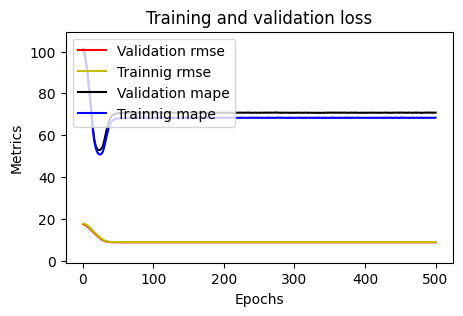

In [37]:
plotme(model2_1)

In [15]:
# inputs: distance + hour
model2_1 = nnmodel(10,10, num_hlayers=1,Epoch=500)
model2_1

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 894526.2500 - distance_layer_loss: 33.9285 - traveltime_layer_loss: 1118149.7500 - distance_layer_mape: 123991.6016 - distance_layer_rmse: 5.8248 - traveltime_layer_mape: 98.5963 - traveltime_layer_rmse: 1057.4260 - val_loss: 818409.9375 - val_distance_layer_loss: 143.3912 - val_traveltime_layer_loss: 1022976.6250 - val_distance_layer_mape: 8856.3418 - val_distance_layer_rmse: 11.9746 - val_traveltime_layer_mape: 94.1320 - val_traveltime_layer_rmse: 1011.4231
Epoch 2/500
353/353 [==============================] - 0s 945us/step - loss: 675941.6875 - distance_layer_loss: 649.0260 - traveltime_layer_loss: 844764.7500 - distance_layer_mape: 2191197.0000 - distance_layer_rmse: 25.4760 - traveltime_layer_mape: 74.8570 - traveltime_layer_rmse: 919.1108 - val_loss: 417631.8750 - val_distance_layer_loss: 1446.0792 - val_traveltime_layer_loss: 521678.1875 - val_distance_layer_mape: 27943.7695 - val_distance_layer_rmse: 38

353/353 [==============================] - 0s 925us/step - loss: 179618.6094 - distance_layer_loss: 2640.8760 - traveltime_layer_loss: 223863.0781 - distance_layer_mape: 4199855.0000 - distance_layer_rmse: 51.3895 - traveltime_layer_mape: 57.6113 - traveltime_layer_rmse: 473.1417 - val_loss: 176708.1719 - val_distance_layer_loss: 2625.6213 - val_traveltime_layer_loss: 220228.7812 - val_distance_layer_mape: 36526.0000 - val_distance_layer_rmse: 51.2408 - val_traveltime_layer_mape: 59.0017 - val_traveltime_layer_rmse: 469.2854
Epoch 32/500
353/353 [==============================] - 0s 896us/step - loss: 179156.5156 - distance_layer_loss: 2603.6594 - traveltime_layer_loss: 223294.5938 - distance_layer_mape: 4127646.5000 - distance_layer_rmse: 51.0261 - traveltime_layer_mape: 57.7535 - traveltime_layer_rmse: 472.5406 - val_loss: 175864.3438 - val_distance_layer_loss: 2527.3418 - val_traveltime_layer_loss: 219198.6719 - val_distance_layer_mape: 35789.5586 - val_distance_layer_rmse: 50.2727 

353/353 [==============================] - 0s 910us/step - loss: 168308.2969 - distance_layer_loss: 1354.0162 - traveltime_layer_loss: 210046.8281 - distance_layer_mape: 2838941.2500 - distance_layer_rmse: 36.7970 - traveltime_layer_mape: 53.0308 - traveltime_layer_rmse: 458.3087 - val_loss: 165386.8438 - val_distance_layer_loss: 1295.9249 - val_traveltime_layer_loss: 206409.6094 - val_distance_layer_mape: 24605.1426 - val_distance_layer_rmse: 35.9990 - val_traveltime_layer_mape: 52.0513 - val_traveltime_layer_rmse: 454.3232
Epoch 62/500
353/353 [==============================] - 0s 933us/step - loss: 167878.0156 - distance_layer_loss: 1310.7577 - traveltime_layer_loss: 209519.8125 - distance_layer_mape: 2796429.5000 - distance_layer_rmse: 36.2044 - traveltime_layer_mape: 52.4499 - traveltime_layer_rmse: 457.7333 - val_loss: 165510.3906 - val_distance_layer_loss: 1302.2352 - val_traveltime_layer_loss: 206562.4688 - val_distance_layer_mape: 24635.0605 - val_distance_layer_rmse: 36.0865 

353/353 [==============================] - 0s 902us/step - loss: 160525.0000 - distance_layer_loss: 728.5416 - traveltime_layer_loss: 200474.0781 - distance_layer_mape: 1963361.5000 - distance_layer_rmse: 26.9915 - traveltime_layer_mape: 48.5429 - traveltime_layer_rmse: 447.7433 - val_loss: 156547.3750 - val_distance_layer_loss: 720.1213 - val_traveltime_layer_loss: 195504.2188 - val_distance_layer_mape: 17411.0781 - val_distance_layer_rmse: 26.8351 - val_traveltime_layer_mape: 49.0820 - val_traveltime_layer_rmse: 442.1586
Epoch 92/500
353/353 [==============================] - 0s 910us/step - loss: 160594.6094 - distance_layer_loss: 722.5124 - traveltime_layer_loss: 200562.6250 - distance_layer_mape: 1965111.5000 - distance_layer_rmse: 26.8796 - traveltime_layer_mape: 48.4620 - traveltime_layer_rmse: 447.8422 - val_loss: 156343.7031 - val_distance_layer_loss: 711.1915 - val_traveltime_layer_loss: 195251.8594 - val_distance_layer_mape: 17285.9043 - val_distance_layer_rmse: 26.6682 - va

353/353 [==============================] - 0s 909us/step - loss: 158939.8125 - distance_layer_loss: 665.3417 - traveltime_layer_loss: 198508.3438 - distance_layer_mape: 1883908.1250 - distance_layer_rmse: 25.7942 - traveltime_layer_mape: 48.1993 - traveltime_layer_rmse: 445.5428 - val_loss: 153833.3438 - val_distance_layer_loss: 646.4716 - val_traveltime_layer_loss: 192130.0938 - val_distance_layer_mape: 16357.3252 - val_distance_layer_rmse: 25.4258 - val_traveltime_layer_mape: 47.6173 - val_traveltime_layer_rmse: 438.3265
Epoch 122/500
353/353 [==============================] - 0s 889us/step - loss: 158914.9531 - distance_layer_loss: 662.6900 - traveltime_layer_loss: 198478.0000 - distance_layer_mape: 1862796.7500 - distance_layer_rmse: 25.7428 - traveltime_layer_mape: 48.1574 - traveltime_layer_rmse: 445.5087 - val_loss: 153840.9844 - val_distance_layer_loss: 651.9739 - val_traveltime_layer_loss: 192138.2344 - val_distance_layer_mape: 16436.6191 - val_distance_layer_rmse: 25.5338 - v

353/353 [==============================] - 0s 872us/step - loss: 156964.3281 - distance_layer_loss: 649.3585 - traveltime_layer_loss: 196043.0312 - distance_layer_mape: 1832001.8750 - distance_layer_rmse: 25.4825 - traveltime_layer_mape: 48.0481 - traveltime_layer_rmse: 442.7675 - val_loss: 151250.6562 - val_distance_layer_loss: 627.2954 - val_traveltime_layer_loss: 188906.4531 - val_distance_layer_mape: 16036.6230 - val_distance_layer_rmse: 25.0459 - val_traveltime_layer_mape: 47.2430 - val_traveltime_layer_rmse: 434.6337
Epoch 152/500
353/353 [==============================] - 0s 881us/step - loss: 156884.6875 - distance_layer_loss: 643.4436 - traveltime_layer_loss: 195944.9531 - distance_layer_mape: 1826611.8750 - distance_layer_rmse: 25.3662 - traveltime_layer_mape: 47.7534 - traveltime_layer_rmse: 442.6567 - val_loss: 151551.0938 - val_distance_layer_loss: 646.1119 - val_traveltime_layer_loss: 189277.3281 - val_distance_layer_mape: 16305.3535 - val_distance_layer_rmse: 25.4187 - v

353/353 [==============================] - 0s 893us/step - loss: 154047.3906 - distance_layer_loss: 643.2562 - traveltime_layer_loss: 192398.5000 - distance_layer_mape: 1815315.2500 - distance_layer_rmse: 25.3625 - traveltime_layer_mape: 47.2076 - traveltime_layer_rmse: 438.6325 - val_loss: 147848.2500 - val_distance_layer_loss: 631.0137 - val_traveltime_layer_loss: 184652.5625 - val_distance_layer_mape: 15961.0986 - val_distance_layer_rmse: 25.1200 - val_traveltime_layer_mape: 47.2090 - val_traveltime_layer_rmse: 429.7122
Epoch 182/500
353/353 [==============================] - 0s 902us/step - loss: 153901.4531 - distance_layer_loss: 640.2064 - traveltime_layer_loss: 192216.7031 - distance_layer_mape: 1782548.1250 - distance_layer_rmse: 25.3023 - traveltime_layer_mape: 47.0069 - traveltime_layer_rmse: 438.4253 - val_loss: 147622.0469 - val_distance_layer_loss: 624.4388 - val_traveltime_layer_loss: 184371.4375 - val_distance_layer_mape: 15854.6455 - val_distance_layer_rmse: 24.9888 - v

353/353 [==============================] - 0s 897us/step - loss: 137292.0625 - distance_layer_loss: 585.3993 - traveltime_layer_loss: 171468.7188 - distance_layer_mape: 1636418.3750 - distance_layer_rmse: 24.1950 - traveltime_layer_mape: 41.0675 - traveltime_layer_rmse: 414.0878 - val_loss: 129876.0078 - val_distance_layer_loss: 571.5236 - val_traveltime_layer_loss: 162202.0312 - val_distance_layer_mape: 14356.3672 - val_distance_layer_rmse: 23.9066 - val_traveltime_layer_mape: 41.1468 - val_traveltime_layer_rmse: 402.7431
Epoch 212/500
353/353 [==============================] - 0s 908us/step - loss: 136308.4531 - distance_layer_loss: 582.0376 - traveltime_layer_loss: 170240.0938 - distance_layer_mape: 1612953.0000 - distance_layer_rmse: 24.1255 - traveltime_layer_mape: 40.9366 - traveltime_layer_rmse: 412.6016 - val_loss: 128812.4922 - val_distance_layer_loss: 564.8775 - val_traveltime_layer_loss: 160874.4062 - val_distance_layer_mape: 14212.0645 - val_distance_layer_rmse: 23.7672 - v

353/353 [==============================] - 0s 886us/step - loss: 115185.1094 - distance_layer_loss: 532.5253 - traveltime_layer_loss: 143848.2031 - distance_layer_mape: 1478780.2500 - distance_layer_rmse: 23.0765 - traveltime_layer_mape: 36.0317 - traveltime_layer_rmse: 379.2733 - val_loss: 107269.9062 - val_distance_layer_loss: 515.5106 - val_traveltime_layer_loss: 133958.4844 - val_distance_layer_mape: 12839.7744 - val_distance_layer_rmse: 22.7049 - val_traveltime_layer_mape: 35.9344 - val_traveltime_layer_rmse: 366.0034
Epoch 242/500
353/353 [==============================] - 0s 897us/step - loss: 115048.2031 - distance_layer_loss: 531.7437 - traveltime_layer_loss: 143677.2969 - distance_layer_mape: 1470142.1250 - distance_layer_rmse: 23.0596 - traveltime_layer_mape: 36.0006 - traveltime_layer_rmse: 379.0479 - val_loss: 107114.3906 - val_distance_layer_loss: 511.3866 - val_traveltime_layer_loss: 133765.1719 - val_distance_layer_mape: 12777.7451 - val_distance_layer_rmse: 22.6139 - v

353/353 [==============================] - 0s 876us/step - loss: 114199.3906 - distance_layer_loss: 538.2656 - traveltime_layer_loss: 142614.6562 - distance_layer_mape: 1519084.6250 - distance_layer_rmse: 23.2006 - traveltime_layer_mape: 36.6603 - traveltime_layer_rmse: 377.6436 - val_loss: 106954.6719 - val_distance_layer_loss: 534.7022 - val_traveltime_layer_loss: 133559.6875 - val_distance_layer_mape: 13245.6689 - val_distance_layer_rmse: 23.1236 - val_traveltime_layer_mape: 37.4166 - val_traveltime_layer_rmse: 365.4582
Epoch 272/500
353/353 [==============================] - 0s 923us/step - loss: 114137.3828 - distance_layer_loss: 539.8435 - traveltime_layer_loss: 142536.8906 - distance_layer_mape: 1505884.0000 - distance_layer_rmse: 23.2345 - traveltime_layer_mape: 36.7743 - traveltime_layer_rmse: 377.5406 - val_loss: 106723.5234 - val_distance_layer_loss: 527.6367 - val_traveltime_layer_loss: 133272.4375 - val_distance_layer_mape: 13134.0518 - val_distance_layer_rmse: 22.9703 - v

353/353 [==============================] - 0s 884us/step - loss: 114214.5938 - distance_layer_loss: 530.7429 - traveltime_layer_loss: 142635.5781 - distance_layer_mape: 1492505.2500 - distance_layer_rmse: 23.0379 - traveltime_layer_mape: 36.8921 - traveltime_layer_rmse: 377.6713 - val_loss: 106614.9297 - val_distance_layer_loss: 509.6254 - val_traveltime_layer_loss: 133141.2969 - val_distance_layer_mape: 12870.8633 - val_distance_layer_rmse: 22.5749 - val_traveltime_layer_mape: 36.8202 - val_traveltime_layer_rmse: 364.8853
Epoch 302/500
353/353 [==============================] - 0s 884us/step - loss: 114150.5703 - distance_layer_loss: 528.4379 - traveltime_layer_loss: 142556.2500 - distance_layer_mape: 1483262.8750 - distance_layer_rmse: 22.9878 - traveltime_layer_mape: 36.9137 - traveltime_layer_rmse: 377.5662 - val_loss: 106607.5312 - val_distance_layer_loss: 510.5905 - val_traveltime_layer_loss: 133131.7188 - val_distance_layer_mape: 12888.4238 - val_distance_layer_rmse: 22.5962 - v

353/353 [==============================] - 0s 905us/step - loss: 114149.6641 - distance_layer_loss: 519.3405 - traveltime_layer_loss: 142557.2500 - distance_layer_mape: 1473165.0000 - distance_layer_rmse: 22.7890 - traveltime_layer_mape: 36.8715 - traveltime_layer_rmse: 377.5675 - val_loss: 106586.0703 - val_distance_layer_loss: 502.8837 - val_traveltime_layer_loss: 133106.8594 - val_distance_layer_mape: 12789.1475 - val_distance_layer_rmse: 22.4251 - val_traveltime_layer_mape: 36.5794 - val_traveltime_layer_rmse: 364.8381
Epoch 332/500
353/353 [==============================] - 0s 909us/step - loss: 114127.4922 - distance_layer_loss: 518.1692 - traveltime_layer_loss: 142529.6875 - distance_layer_mape: 1480030.0000 - distance_layer_rmse: 22.7633 - traveltime_layer_mape: 36.8301 - traveltime_layer_rmse: 377.5310 - val_loss: 106555.3750 - val_distance_layer_loss: 497.8503 - val_traveltime_layer_loss: 133069.7500 - val_distance_layer_mape: 12702.5889 - val_distance_layer_rmse: 22.3126 - v

353/353 [==============================] - 0s 877us/step - loss: 114156.3984 - distance_layer_loss: 509.4062 - traveltime_layer_loss: 142568.0625 - distance_layer_mape: 1449111.3750 - distance_layer_rmse: 22.5700 - traveltime_layer_mape: 36.9644 - traveltime_layer_rmse: 377.5818 - val_loss: 106641.5156 - val_distance_layer_loss: 495.8807 - val_traveltime_layer_loss: 133177.9531 - val_distance_layer_mape: 12687.0615 - val_distance_layer_rmse: 22.2684 - val_traveltime_layer_mape: 37.0365 - val_traveltime_layer_rmse: 364.9355
Epoch 362/500
353/353 [==============================] - 0s 888us/step - loss: 114179.6797 - distance_layer_loss: 508.7125 - traveltime_layer_loss: 142597.4844 - distance_layer_mape: 1439649.8750 - distance_layer_rmse: 22.5547 - traveltime_layer_mape: 36.8125 - traveltime_layer_rmse: 377.6208 - val_loss: 106643.1562 - val_distance_layer_loss: 494.4270 - val_traveltime_layer_loss: 133180.3594 - val_distance_layer_mape: 12660.6367 - val_distance_layer_rmse: 22.2357 - v

353/353 [==============================] - 0s 916us/step - loss: 114121.1016 - distance_layer_loss: 497.9742 - traveltime_layer_loss: 142526.7969 - distance_layer_mape: 1400170.7500 - distance_layer_rmse: 22.3153 - traveltime_layer_mape: 36.8306 - traveltime_layer_rmse: 377.5272 - val_loss: 106686.8125 - val_distance_layer_loss: 486.4870 - val_traveltime_layer_loss: 133236.8906 - val_distance_layer_mape: 12546.4473 - val_distance_layer_rmse: 22.0564 - val_traveltime_layer_mape: 37.3690 - val_traveltime_layer_rmse: 365.0163
Epoch 392/500
353/353 [==============================] - 0s 888us/step - loss: 114099.8828 - distance_layer_loss: 498.3894 - traveltime_layer_loss: 142500.2500 - distance_layer_mape: 1407252.6250 - distance_layer_rmse: 22.3246 - traveltime_layer_mape: 37.0068 - traveltime_layer_rmse: 377.4921 - val_loss: 106551.2812 - val_distance_layer_loss: 476.6673 - val_traveltime_layer_loss: 133069.9531 - val_distance_layer_mape: 12381.3447 - val_distance_layer_rmse: 21.8327 - v

353/353 [==============================] - 0s 857us/step - loss: 114127.9297 - distance_layer_loss: 488.0664 - traveltime_layer_loss: 142538.0000 - distance_layer_mape: 1433889.3750 - distance_layer_rmse: 22.0922 - traveltime_layer_mape: 36.9851 - traveltime_layer_rmse: 377.5421 - val_loss: 106516.8281 - val_distance_layer_loss: 468.2494 - val_traveltime_layer_loss: 133028.9375 - val_distance_layer_mape: 12259.3877 - val_distance_layer_rmse: 21.6391 - val_traveltime_layer_mape: 36.4391 - val_traveltime_layer_rmse: 364.7313
Epoch 422/500
353/353 [==============================] - 0s 906us/step - loss: 114109.2109 - distance_layer_loss: 488.8718 - traveltime_layer_loss: 142514.2812 - distance_layer_mape: 1409352.7500 - distance_layer_rmse: 22.1104 - traveltime_layer_mape: 36.8738 - traveltime_layer_rmse: 377.5107 - val_loss: 106538.1016 - val_distance_layer_loss: 470.6459 - val_traveltime_layer_loss: 133054.9219 - val_distance_layer_mape: 12299.2041 - val_distance_layer_rmse: 21.6944 - v

353/353 [==============================] - 0s 866us/step - loss: 114123.4922 - distance_layer_loss: 481.4989 - traveltime_layer_loss: 142533.9531 - distance_layer_mape: 1413267.2500 - distance_layer_rmse: 21.9431 - traveltime_layer_mape: 37.0869 - traveltime_layer_rmse: 377.5367 - val_loss: 106596.2891 - val_distance_layer_loss: 467.1660 - val_traveltime_layer_loss: 133128.5156 - val_distance_layer_mape: 12256.9512 - val_distance_layer_rmse: 21.6140 - val_traveltime_layer_mape: 37.0317 - val_traveltime_layer_rmse: 364.8678
Epoch 452/500
353/353 [==============================] - 0s 912us/step - loss: 114109.4375 - distance_layer_loss: 478.8887 - traveltime_layer_loss: 142516.9844 - distance_layer_mape: 1403502.8750 - distance_layer_rmse: 21.8835 - traveltime_layer_mape: 36.8650 - traveltime_layer_rmse: 377.5142 - val_loss: 107036.3750 - val_distance_layer_loss: 479.2526 - val_traveltime_layer_loss: 133675.6094 - val_distance_layer_mape: 12466.8281 - val_distance_layer_rmse: 21.8918 - v

353/353 [==============================] - 0s 892us/step - loss: 114066.2578 - distance_layer_loss: 469.5718 - traveltime_layer_loss: 142465.4844 - distance_layer_mape: 1384000.6250 - distance_layer_rmse: 21.6696 - traveltime_layer_mape: 36.7980 - traveltime_layer_rmse: 377.4460 - val_loss: 107103.8047 - val_distance_layer_loss: 471.9648 - val_traveltime_layer_loss: 133761.7812 - val_distance_layer_mape: 12356.0977 - val_distance_layer_rmse: 21.7248 - val_traveltime_layer_mape: 38.1899 - val_traveltime_layer_rmse: 365.7346
Epoch 482/500
353/353 [==============================] - 0s 893us/step - loss: 114050.6172 - distance_layer_loss: 471.7172 - traveltime_layer_loss: 142445.3750 - distance_layer_mape: 1373234.3750 - distance_layer_rmse: 21.7191 - traveltime_layer_mape: 36.9160 - traveltime_layer_rmse: 377.4194 - val_loss: 106914.1406 - val_distance_layer_loss: 466.9375 - val_traveltime_layer_loss: 133526.0156 - val_distance_layer_mape: 12271.7266 - val_distance_layer_rmse: 21.6087 - v

In [16]:
# inputs: distance + hour
model2_1 = nnmodel(20,60, num_hlayers=1,Epoch=500)
model2_1

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 901377.6250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1126722.2500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 99.2265 - traveltime_layer_rmse: 1061.4717 - val_loss: 855393.6250 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1069242.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 97.7740 - val_traveltime_layer_rmse: 1034.0419
Epoch 2/500
353/353 [==============================] - 0s 906us/step - loss: 859975.0000 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1074968.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 94.9272 - traveltime_layer_rmse: 1036.8069 - val_loss: 795569.2500 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 994461.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltim

353/353 [==============================] - 0s 901us/step - loss: 226417.5000 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283021.8438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4393 - traveltime_layer_rmse: 531.9980 - val_loss: 220814.2969 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276017.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0160 - val_traveltime_layer_rmse: 525.3738
Epoch 32/500
353/353 [==============================] - 0s 889us/step - loss: 226422.8906 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283028.6562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2351 - traveltime_layer_rmse: 532.0044 - val_loss: 220817.9062 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276022.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 886us/step - loss: 226421.1875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283026.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3679 - traveltime_layer_rmse: 532.0023 - val_loss: 220759.5938 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275949.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8479 - val_traveltime_layer_rmse: 525.3088
Epoch 62/500
353/353 [==============================] - 0s 885us/step - loss: 226421.7500 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283027.2500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.1530 - traveltime_layer_rmse: 532.0031 - val_loss: 220819.1406 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276023.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 927us/step - loss: 226423.1406 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283028.7188 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4651 - traveltime_layer_rmse: 532.0045 - val_loss: 220803.1719 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276003.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9995 - val_traveltime_layer_rmse: 525.3606
Epoch 92/500
353/353 [==============================] - 0s 927us/step - loss: 226426.2188 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283032.6562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3219 - traveltime_layer_rmse: 532.0081 - val_loss: 220851.8906 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276064.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 910us/step - loss: 226415.6406 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283019.6562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2564 - traveltime_layer_rmse: 531.9959 - val_loss: 220789.3125 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275986.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9362 - val_traveltime_layer_rmse: 525.3442
Epoch 122/500
353/353 [==============================] - 0s 891us/step - loss: 226419.1250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283023.8125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3974 - traveltime_layer_rmse: 531.9998 - val_loss: 220773.5000 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275966.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 913us/step - loss: 226423.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283029.9062 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2790 - traveltime_layer_rmse: 532.0056 - val_loss: 220823.1250 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276028.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0478 - val_traveltime_layer_rmse: 525.3845
Epoch 152/500
353/353 [==============================] - 0s 908us/step - loss: 226418.9219 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283024.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4284 - traveltime_layer_rmse: 532.0000 - val_loss: 220785.7969 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275982.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 936us/step - loss: 226415.3125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283019.2188 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.1871 - traveltime_layer_rmse: 531.9955 - val_loss: 220858.8125 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276073.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.1358 - val_traveltime_layer_rmse: 525.4269
Epoch 182/500
353/353 [==============================] - 0s 926us/step - loss: 226426.0625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283032.5625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.5971 - traveltime_layer_rmse: 532.0081 - val_loss: 220795.6719 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275994.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 873us/step - loss: 226414.2344 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283017.7812 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.1617 - traveltime_layer_rmse: 531.9941 - val_loss: 220836.9844 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276046.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0692 - val_traveltime_layer_rmse: 525.4010
Epoch 212/500
353/353 [==============================] - 0s 901us/step - loss: 226429.1875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283036.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.5229 - traveltime_layer_rmse: 532.0117 - val_loss: 220734.2656 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275917.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 901us/step - loss: 226431.1875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283038.8125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3249 - traveltime_layer_rmse: 532.0139 - val_loss: 220800.4688 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276000.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9863 - val_traveltime_layer_rmse: 525.3575
Epoch 242/500
353/353 [==============================] - 0s 887us/step - loss: 226437.1406 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283046.3125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3501 - traveltime_layer_rmse: 532.0210 - val_loss: 220713.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275891.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 913us/step - loss: 226419.3281 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283024.2188 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3935 - traveltime_layer_rmse: 532.0002 - val_loss: 220812.6562 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276015.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9937 - val_traveltime_layer_rmse: 525.3720
Epoch 272/500
353/353 [==============================] - 0s 881us/step - loss: 226415.8438 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283019.5938 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4193 - traveltime_layer_rmse: 531.9958 - val_loss: 220740.7188 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275925.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 929us/step - loss: 226420.1875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283025.1875 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2344 - traveltime_layer_rmse: 532.0011 - val_loss: 220834.7812 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276043.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0749 - val_traveltime_layer_rmse: 525.3984
Epoch 302/500
353/353 [==============================] - 0s 908us/step - loss: 226418.8594 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283023.5312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2693 - traveltime_layer_rmse: 531.9996 - val_loss: 220844.0469 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276055.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 890us/step - loss: 226414.7812 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283018.5938 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2253 - traveltime_layer_rmse: 531.9949 - val_loss: 220854.9531 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276068.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.1219 - val_traveltime_layer_rmse: 525.4225
Epoch 332/500
353/353 [==============================] - 0s 919us/step - loss: 226415.1406 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283018.9375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.6117 - traveltime_layer_rmse: 531.9952 - val_loss: 220752.0781 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275940.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 971us/step - loss: 226418.5312 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283023.2500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3622 - traveltime_layer_rmse: 531.9993 - val_loss: 220840.8594 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276051.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0905 - val_traveltime_layer_rmse: 525.4056
Epoch 362/500
353/353 [==============================] - 0s 907us/step - loss: 226416.6094 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283020.5312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3533 - traveltime_layer_rmse: 531.9968 - val_loss: 220830.4688 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276037.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 925us/step - loss: 226428.5781 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283035.8125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3351 - traveltime_layer_rmse: 532.0111 - val_loss: 220897.2500 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276121.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.2350 - val_traveltime_layer_rmse: 525.4727
Epoch 392/500
353/353 [==============================] - 0s 921us/step - loss: 226428.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283036.0625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2817 - traveltime_layer_rmse: 532.0114 - val_loss: 220844.7188 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276055.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 942us/step - loss: 226426.3594 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283033.0625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4735 - traveltime_layer_rmse: 532.0085 - val_loss: 220755.3750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275944.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8220 - val_traveltime_layer_rmse: 525.3039
Epoch 422/500
353/353 [==============================] - 0s 926us/step - loss: 226418.7500 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283023.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.1703 - traveltime_layer_rmse: 531.9994 - val_loss: 220832.5625 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276040.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 882us/step - loss: 226416.3906 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283020.4688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3535 - traveltime_layer_rmse: 531.9967 - val_loss: 220821.2969 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276026.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0332 - val_traveltime_layer_rmse: 525.3823
Epoch 452/500
353/353 [==============================] - 0s 893us/step - loss: 226409.6562 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283012.0312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3807 - traveltime_layer_rmse: 531.9888 - val_loss: 220752.2969 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275940.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 924us/step - loss: 226418.9219 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283023.7188 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4441 - traveltime_layer_rmse: 531.9998 - val_loss: 220700.3750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275875.4375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.6533 - val_traveltime_layer_rmse: 525.2385
Epoch 482/500
353/353 [==============================] - 0s 893us/step - loss: 226424.2031 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283030.1250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2112 - traveltime_layer_rmse: 532.0057 - val_loss: 220763.0000 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275953.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

In [38]:
# inputs: distance + hour
model2_2 = nnmodel(5,10, num_hlayers=1,Epoch=1000)
model2_2

Epoch 1/1000
353/353 [==============================] - 1s 1ms/step - loss: 906777.0000 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1133470.8750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 99.7645 - traveltime_layer_rmse: 1064.6459 - val_loss: 871110.6875 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1088887.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 99.4508 - val_traveltime_layer_rmse: 1043.4979
Epoch 2/1000
353/353 [==============================] - 0s 949us/step - loss: 898284.1250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1122855.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 98.8871 - traveltime_layer_rmse: 1059.6486 - val_loss: 858963.2500 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1073704.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_travel

353/353 [==============================] - 0s 1ms/step - loss: 230942.1875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 288677.7500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 65.3616 - traveltime_layer_rmse: 537.2874 - val_loss: 224429.9219 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 280537.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 66.3808 - val_traveltime_layer_rmse: 529.6578
Epoch 32/1000
353/353 [==============================] - 0s 971us/step - loss: 229615.7969 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 287019.9062 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 66.0948 - traveltime_layer_rmse: 535.7424 - val_loss: 223440.8906 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 279301.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 67

353/353 [==============================] - 0s 952us/step - loss: 226396.3438 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282995.4375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3829 - traveltime_layer_rmse: 531.9731 - val_loss: 220796.5781 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275995.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9547 - val_traveltime_layer_rmse: 525.3530
Epoch 62/1000
353/353 [==============================] - 0s 957us/step - loss: 226401.9531 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283002.5625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3540 - traveltime_layer_rmse: 531.9799 - val_loss: 220782.3750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275978.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 913us/step - loss: 226404.9844 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283006.3125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3813 - traveltime_layer_rmse: 531.9834 - val_loss: 220764.3125 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275955.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8617 - val_traveltime_layer_rmse: 525.3145
Epoch 92/1000
353/353 [==============================] - 0s 970us/step - loss: 226400.9062 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283001.0312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2825 - traveltime_layer_rmse: 531.9784 - val_loss: 220771.2969 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275964.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 

353/353 [==============================] - 0s 954us/step - loss: 226404.5625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283005.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2825 - traveltime_layer_rmse: 531.9827 - val_loss: 220821.4844 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276026.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0340 - val_traveltime_layer_rmse: 525.3826
Epoch 122/1000
353/353 [==============================] - 0s 961us/step - loss: 226398.2500 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282997.7188 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.5281 - traveltime_layer_rmse: 531.9753 - val_loss: 220794.3594 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275992.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 1ms/step - loss: 226398.7500 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282998.4062 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2988 - traveltime_layer_rmse: 531.9760 - val_loss: 220803.3906 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276004.2500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9820 - val_traveltime_layer_rmse: 525.3611
Epoch 152/1000
353/353 [==============================] - 0s 1ms/step - loss: 226402.9688 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283003.5938 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2861 - traveltime_layer_rmse: 531.9808 - val_loss: 220814.2812 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276018.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.

353/353 [==============================] - 0s 1ms/step - loss: 226401.9219 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283002.5625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2601 - traveltime_layer_rmse: 531.9799 - val_loss: 220798.7969 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275998.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9642 - val_traveltime_layer_rmse: 525.3555
Epoch 182/1000
353/353 [==============================] - 0s 1ms/step - loss: 226406.8438 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283008.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3692 - traveltime_layer_rmse: 531.9853 - val_loss: 220808.7969 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276010.9688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.

353/353 [==============================] - 0s 990us/step - loss: 226403.7812 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283004.6562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2485 - traveltime_layer_rmse: 531.9818 - val_loss: 220790.3438 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275987.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9434 - val_traveltime_layer_rmse: 525.3455
Epoch 212/1000
353/353 [==============================] - 0s 959us/step - loss: 226402.4062 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283002.9375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3738 - traveltime_layer_rmse: 531.9802 - val_loss: 220795.8750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275994.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 967us/step - loss: 226402.9844 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283003.6562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.1969 - traveltime_layer_rmse: 531.9809 - val_loss: 220797.0938 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275996.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9676 - val_traveltime_layer_rmse: 525.3535
Epoch 242/1000
353/353 [==============================] - 0s 969us/step - loss: 226408.3125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283010.1875 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2972 - traveltime_layer_rmse: 531.9870 - val_loss: 220804.5469 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276005.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 972us/step - loss: 226398.5000 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282998.1875 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3163 - traveltime_layer_rmse: 531.9758 - val_loss: 220817.5625 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276021.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0258 - val_traveltime_layer_rmse: 525.3779
Epoch 272/1000
353/353 [==============================] - 0s 960us/step - loss: 226396.7969 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282996.0312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3409 - traveltime_layer_rmse: 531.9737 - val_loss: 220799.2188 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275999.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 1ms/step - loss: 226403.2812 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283003.8438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2875 - traveltime_layer_rmse: 531.9811 - val_loss: 220796.7812 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275995.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9576 - val_traveltime_layer_rmse: 525.3531
Epoch 302/1000
353/353 [==============================] - 0s 1ms/step - loss: 226399.9531 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282999.9062 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3988 - traveltime_layer_rmse: 531.9774 - val_loss: 220788.8438 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275986.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.

353/353 [==============================] - 0s 968us/step - loss: 226401.5156 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283002.0312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3737 - traveltime_layer_rmse: 531.9794 - val_loss: 220826.7344 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276033.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0491 - val_traveltime_layer_rmse: 525.3887
Epoch 332/1000
353/353 [==============================] - 0s 989us/step - loss: 226402.8125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283003.3438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2931 - traveltime_layer_rmse: 531.9806 - val_loss: 220824.8594 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276031.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 965us/step - loss: 226397.8438 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282997.2500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4395 - traveltime_layer_rmse: 531.9749 - val_loss: 220781.7656 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275977.2500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9166 - val_traveltime_layer_rmse: 525.3354
Epoch 362/1000
353/353 [==============================] - 0s 1ms/step - loss: 226399.8438 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282999.4688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4395 - traveltime_layer_rmse: 531.9769 - val_loss: 220752.5156 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275940.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 958us/step - loss: 226402.2812 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283002.8125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2769 - traveltime_layer_rmse: 531.9801 - val_loss: 220824.3438 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276030.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0402 - val_traveltime_layer_rmse: 525.3859
Epoch 392/1000
353/353 [==============================] - 0s 991us/step - loss: 226398.4375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282997.9375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4425 - traveltime_layer_rmse: 531.9755 - val_loss: 220777.5000 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275971.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 951us/step - loss: 226400.2656 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283000.2812 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4153 - traveltime_layer_rmse: 531.9777 - val_loss: 220787.6562 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275984.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9344 - val_traveltime_layer_rmse: 525.3423
Epoch 422/1000
353/353 [==============================] - 0s 995us/step - loss: 226403.5625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283004.5625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2283 - traveltime_layer_rmse: 531.9818 - val_loss: 220798.6875 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275998.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 971us/step - loss: 226403.9219 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283004.9688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3206 - traveltime_layer_rmse: 531.9821 - val_loss: 220781.5625 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275976.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9172 - val_traveltime_layer_rmse: 525.3350
Epoch 452/1000
353/353 [==============================] - 0s 926us/step - loss: 226401.5469 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283001.8438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2368 - traveltime_layer_rmse: 531.9792 - val_loss: 220790.0000 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275987.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 990us/step - loss: 226401.1719 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283001.5312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4358 - traveltime_layer_rmse: 531.9789 - val_loss: 220819.7344 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276024.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0324 - val_traveltime_layer_rmse: 525.3804
Epoch 482/1000
353/353 [==============================] - 0s 983us/step - loss: 226401.5938 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283001.9375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4628 - traveltime_layer_rmse: 531.9792 - val_loss: 220781.9688 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275977.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 1ms/step - loss: 226407.3438 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283009.3125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2835 - traveltime_layer_rmse: 531.9862 - val_loss: 220812.1719 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276015.1562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0073 - val_traveltime_layer_rmse: 525.3715
Epoch 512/1000
353/353 [==============================] - 0s 961us/step - loss: 226408.9219 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283011.0938 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3342 - traveltime_layer_rmse: 531.9879 - val_loss: 220814.9062 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276018.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 1ms/step - loss: 226402.9844 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283003.6562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3587 - traveltime_layer_rmse: 531.9809 - val_loss: 220782.3281 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275977.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9132 - val_traveltime_layer_rmse: 525.3360
Epoch 542/1000
353/353 [==============================] - 0s 988us/step - loss: 226399.2969 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282999.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2773 - traveltime_layer_rmse: 531.9765 - val_loss: 220790.4219 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275988.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 955us/step - loss: 226399.5625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282999.3438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2052 - traveltime_layer_rmse: 531.9768 - val_loss: 220784.0625 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275980.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9247 - val_traveltime_layer_rmse: 525.3380
Epoch 572/1000
353/353 [==============================] - 0s 957us/step - loss: 226399.5938 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282999.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2810 - traveltime_layer_rmse: 531.9769 - val_loss: 220798.9219 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275998.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 1ms/step - loss: 226399.4375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282998.9688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3034 - traveltime_layer_rmse: 531.9765 - val_loss: 220776.1562 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275970.2812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8924 - val_traveltime_layer_rmse: 525.3287
Epoch 602/1000
353/353 [==============================] - 0s 975us/step - loss: 226405.2969 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283006.6875 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4513 - traveltime_layer_rmse: 531.9837 - val_loss: 220782.7188 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275978.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 983us/step - loss: 226400.9531 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283001.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3224 - traveltime_layer_rmse: 531.9784 - val_loss: 220788.2969 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275985.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9371 - val_traveltime_layer_rmse: 525.3430
Epoch 632/1000
353/353 [==============================] - 0s 1ms/step - loss: 226402.4531 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283003.1250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3105 - traveltime_layer_rmse: 531.9804 - val_loss: 220818.8281 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276023.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 975us/step - loss: 226398.0469 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282997.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4023 - traveltime_layer_rmse: 531.9751 - val_loss: 220803.1719 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276003.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9785 - val_traveltime_layer_rmse: 525.3608
Epoch 662/1000
353/353 [==============================] - 0s 1ms/step - loss: 226396.7812 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282995.8125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4512 - traveltime_layer_rmse: 531.9735 - val_loss: 220779.2969 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275974.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 958us/step - loss: 226398.3906 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282997.6875 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4141 - traveltime_layer_rmse: 531.9753 - val_loss: 220812.6562 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276015.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0117 - val_traveltime_layer_rmse: 525.3721
Epoch 692/1000
353/353 [==============================] - 0s 954us/step - loss: 226403.5156 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283004.3438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2262 - traveltime_layer_rmse: 531.9815 - val_loss: 220816.6719 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276020.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 955us/step - loss: 226399.1406 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282998.9688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3187 - traveltime_layer_rmse: 531.9765 - val_loss: 220784.1562 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275980.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9162 - val_traveltime_layer_rmse: 525.3381
Epoch 722/1000
353/353 [==============================] - 0s 952us/step - loss: 226398.5312 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282998.3125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4416 - traveltime_layer_rmse: 531.9758 - val_loss: 220777.2656 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275971.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 963us/step - loss: 226401.9219 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283002.4375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3190 - traveltime_layer_rmse: 531.9797 - val_loss: 220805.2656 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276006.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9848 - val_traveltime_layer_rmse: 525.3632
Epoch 752/1000
353/353 [==============================] - 0s 943us/step - loss: 226401.0156 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283000.9375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4603 - traveltime_layer_rmse: 531.9783 - val_loss: 220782.3750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275978.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 1ms/step - loss: 226398.0312 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282997.4062 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3519 - traveltime_layer_rmse: 531.9750 - val_loss: 220781.1406 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275976.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9188 - val_traveltime_layer_rmse: 525.3345
Epoch 782/1000
353/353 [==============================] - 0s 955us/step - loss: 226407.6875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283009.6875 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2650 - traveltime_layer_rmse: 531.9866 - val_loss: 220766.4062 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275958.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 988us/step - loss: 226403.5625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283004.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2135 - traveltime_layer_rmse: 531.9816 - val_loss: 220802.2188 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276002.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9749 - val_traveltime_layer_rmse: 525.3597
Epoch 812/1000
353/353 [==============================] - 0s 993us/step - loss: 226401.1094 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283001.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4133 - traveltime_layer_rmse: 531.9788 - val_loss: 220799.0312 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275998.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 974us/step - loss: 226397.2188 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282996.4688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4531 - traveltime_layer_rmse: 531.9741 - val_loss: 220758.1719 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275947.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8392 - val_traveltime_layer_rmse: 525.3071
Epoch 842/1000
353/353 [==============================] - 0s 946us/step - loss: 226402.0000 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283002.3438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2019 - traveltime_layer_rmse: 531.9797 - val_loss: 220786.9219 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275983.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 952us/step - loss: 226401.5625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283002.0312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2002 - traveltime_layer_rmse: 531.9794 - val_loss: 220833.2656 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276041.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0763 - val_traveltime_layer_rmse: 525.3966
Epoch 872/1000
353/353 [==============================] - 0s 985us/step - loss: 226398.6562 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282998.3125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3392 - traveltime_layer_rmse: 531.9758 - val_loss: 220823.0312 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276028.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape:

353/353 [==============================] - 0s 968us/step - loss: 226400.1875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283000.4688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3069 - traveltime_layer_rmse: 531.9779 - val_loss: 220813.9688 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276017.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0163 - val_traveltime_layer_rmse: 525.3736
Epoch 902/1000
353/353 [==============================] - 0s 1ms/step - loss: 226410.0469 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283012.4688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2040 - traveltime_layer_rmse: 531.9891 - val_loss: 220854.5938 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276068.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 6

353/353 [==============================] - 0s 1ms/step - loss: 226397.8281 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282997.1250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3896 - traveltime_layer_rmse: 531.9747 - val_loss: 220774.9844 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275968.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8930 - val_traveltime_layer_rmse: 525.3273
Epoch 932/1000
353/353 [==============================] - 0s 1ms/step - loss: 226402.4219 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283002.9688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4176 - traveltime_layer_rmse: 531.9802 - val_loss: 220750.1250 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275937.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.

353/353 [==============================] - 0s 1ms/step - loss: 226397.8281 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282997.2500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3255 - traveltime_layer_rmse: 531.9749 - val_loss: 220806.1094 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276007.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9889 - val_traveltime_layer_rmse: 525.3643
Epoch 962/1000
353/353 [==============================] - 0s 1ms/step - loss: 226399.9844 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282999.8438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2882 - traveltime_layer_rmse: 531.9773 - val_loss: 220809.7500 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276012.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.

353/353 [==============================] - 0s 1ms/step - loss: 226406.0312 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283007.4375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2740 - traveltime_layer_rmse: 531.9844 - val_loss: 220809.0938 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276011.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9907 - val_traveltime_layer_rmse: 525.3679
Epoch 992/1000
353/353 [==============================] - 0s 1ms/step - loss: 226400.1562 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 283000.3125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3175 - traveltime_layer_rmse: 531.9777 - val_loss: 220799.8438 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275999.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.

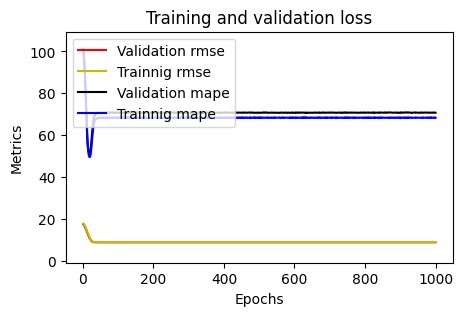

In [39]:
plotme(model2_2)

In [40]:
# # inputs: distance + hour
# model2_3 = nnmodel(10,15, num_hlayers=1,Epoch=500)
# model2_3

In [41]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,5, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 904450.7500 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1130563.8750 - distance_layer_mape: 99.9910 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 99.5366 - traveltime_layer_rmse: 1063.2798 - val_loss: 862420.3750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 1078026.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 98.5429 - val_traveltime_layer_rmse: 1038.2803
Epoch 2/500
353/353 [==============================] - 0s 1ms/step - loss: 867460.3750 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 1084325.7500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 95.7471 - traveltime_layer_rmse: 1041.3097 - val_loss: 796060.9375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 995076.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_

Epoch 17/500
353/353 [==============================] - 0s 1ms/step - loss: 226356.0625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282945.2188 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3248 - traveltime_layer_rmse: 531.9260 - val_loss: 220748.2344 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275935.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.7839 - val_traveltime_layer_rmse: 525.2955
Epoch 18/500
353/353 [==============================] - 0s 1ms/step - loss: 226346.7188 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282933.3125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.1297 - traveltime_layer_rmse: 531.9147 - val_loss: 220890.8750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276113.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

Epoch 33/500
353/353 [==============================] - 0s 994us/step - loss: 226310.5000 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282887.9375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.6724 - traveltime_layer_rmse: 531.8721 - val_loss: 220640.4688 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275800.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.4719 - val_traveltime_layer_rmse: 525.1672
Epoch 34/500
353/353 [==============================] - 0s 1ms/step - loss: 226332.8906 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282916.1562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.0437 - traveltime_layer_rmse: 531.8986 - val_loss: 220805.7969 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276007.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_la

Epoch 64/500
353/353 [==============================] - 0s 1ms/step - loss: 226282.0625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282852.5312 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3864 - traveltime_layer_rmse: 531.8388 - val_loss: 220728.9062 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275911.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9163 - val_traveltime_layer_rmse: 525.2724
Epoch 65/500
353/353 [==============================] - 0s 1ms/step - loss: 226292.4844 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282865.7812 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3007 - traveltime_layer_rmse: 531.8513 - val_loss: 220737.0781 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275921.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

Epoch 80/500
353/353 [==============================] - 0s 1ms/step - loss: 226278.2812 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282847.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.7071 - traveltime_layer_rmse: 531.8342 - val_loss: 220671.9062 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275839.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.7577 - val_traveltime_layer_rmse: 525.2045
Epoch 81/500
353/353 [==============================] - 0s 1ms/step - loss: 226280.7500 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282851.0000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2279 - traveltime_layer_rmse: 531.8374 - val_loss: 220691.7500 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275864.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

Epoch 96/500
353/353 [==============================] - 0s 1ms/step - loss: 226294.0312 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282867.5000 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3269 - traveltime_layer_rmse: 531.8529 - val_loss: 220722.2500 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275902.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9256 - val_traveltime_layer_rmse: 525.2645
Epoch 97/500
353/353 [==============================] - 0s 1ms/step - loss: 226302.5469 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282878.1250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2214 - traveltime_layer_rmse: 531.8629 - val_loss: 220745.3125 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275931.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_laye

Epoch 127/500
353/353 [==============================] - 0s 1ms/step - loss: 226278.4375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282848.1250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4968 - traveltime_layer_rmse: 531.8347 - val_loss: 220698.9844 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275873.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8745 - val_traveltime_layer_rmse: 525.2367
Epoch 128/500
353/353 [==============================] - 0s 1ms/step - loss: 226282.2031 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282852.7188 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2706 - traveltime_layer_rmse: 531.8390 - val_loss: 220726.3125 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275907.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_la

Epoch 158/500
353/353 [==============================] - 0s 1ms/step - loss: 226283.4688 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282854.2812 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2324 - traveltime_layer_rmse: 531.8405 - val_loss: 220693.8594 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275867.2500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8869 - val_traveltime_layer_rmse: 525.2307
Epoch 159/500
353/353 [==============================] - 0s 1ms/step - loss: 226284.2344 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282855.2812 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4291 - traveltime_layer_rmse: 531.8414 - val_loss: 220679.0312 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275848.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_la

Epoch 189/500
353/353 [==============================] - 0s 1ms/step - loss: 226280.8906 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282851.1562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2002 - traveltime_layer_rmse: 531.8375 - val_loss: 220758.6094 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275948.1562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0871 - val_traveltime_layer_rmse: 525.3077
Epoch 190/500
353/353 [==============================] - 0s 1ms/step - loss: 226272.3125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282840.4688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2026 - traveltime_layer_rmse: 531.8275 - val_loss: 220845.0000 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276056.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_la

353/353 [==============================] - 0s 1ms/step - loss: 226278.0000 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282847.6250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2387 - traveltime_layer_rmse: 531.8342 - val_loss: 220718.6250 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275898.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.9500 - val_traveltime_layer_rmse: 525.2601
Epoch 220/500
353/353 [==============================] - 0s 995us/step - loss: 226284.0312 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282855.0625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.1986 - traveltime_layer_rmse: 531.8412 - val_loss: 220709.8281 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275887.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68

Epoch 250/500
353/353 [==============================] - 0s 1ms/step - loss: 226271.7969 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282839.7188 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.5919 - traveltime_layer_rmse: 531.8268 - val_loss: 220570.3281 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275712.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.4252 - val_traveltime_layer_rmse: 525.0837
Epoch 251/500
353/353 [==============================] - 0s 1ms/step - loss: 226274.9844 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282843.7500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2150 - traveltime_layer_rmse: 531.8306 - val_loss: 220631.9062 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275789.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_la

Epoch 281/500
353/353 [==============================] - 0s 1ms/step - loss: 226267.9375 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282834.8438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2922 - traveltime_layer_rmse: 531.8222 - val_loss: 220774.4375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275968.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.1140 - val_traveltime_layer_rmse: 525.3265
Epoch 282/500
353/353 [==============================] - 0s 1ms/step - loss: 226266.5000 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282832.9375 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2595 - traveltime_layer_rmse: 531.8204 - val_loss: 220826.1094 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276032.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_la

353/353 [==============================] - 0s 1ms/step - loss: 226263.7344 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282829.5938 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.1958 - traveltime_layer_rmse: 531.8173 - val_loss: 220847.3594 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276059.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.3231 - val_traveltime_layer_rmse: 525.4133
Epoch 312/500
353/353 [==============================] - 0s 1ms/step - loss: 226281.0469 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282851.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4308 - traveltime_layer_rmse: 531.8377 - val_loss: 220762.9062 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275953.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.1

353/353 [==============================] - 0s 1ms/step - loss: 226255.1875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282818.8750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.0046 - traveltime_layer_rmse: 531.8072 - val_loss: 220810.3125 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276012.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.2667 - val_traveltime_layer_rmse: 525.3693
Epoch 342/500
353/353 [==============================] - 0s 1ms/step - loss: 226287.8125 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282859.6562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4995 - traveltime_layer_rmse: 531.8455 - val_loss: 220677.4531 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275846.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8

Epoch 357/500
353/353 [==============================] - 0s 1ms/step - loss: 226259.8750 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282824.7812 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.1612 - traveltime_layer_rmse: 531.8127 - val_loss: 220748.1094 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275935.1562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.0452 - val_traveltime_layer_rmse: 525.2953
Epoch 358/500
353/353 [==============================] - 0s 1ms/step - loss: 226265.9688 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282832.4688 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2925 - traveltime_layer_rmse: 531.8199 - val_loss: 220850.1094 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276062.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_la

Epoch 388/500
353/353 [==============================] - 0s 1ms/step - loss: 226260.6250 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282825.3750 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.7863 - traveltime_layer_rmse: 531.8133 - val_loss: 220645.8750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275807.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.7226 - val_traveltime_layer_rmse: 525.1736
Epoch 389/500
353/353 [==============================] - 0s 992us/step - loss: 226293.7344 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282867.1250 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.1745 - traveltime_layer_rmse: 531.8525 - val_loss: 220716.3906 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275895.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_

Epoch 419/500
353/353 [==============================] - 0s 985us/step - loss: 226261.2812 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282826.7500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4348 - traveltime_layer_rmse: 531.8146 - val_loss: 220681.1875 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275851.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.8829 - val_traveltime_layer_rmse: 525.2156
Epoch 420/500
353/353 [==============================] - 0s 1ms/step - loss: 226256.5625 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282820.5625 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2236 - traveltime_layer_rmse: 531.8088 - val_loss: 220745.8281 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275932.2188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_

353/353 [==============================] - 0s 1ms/step - loss: 226257.5000 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282821.8438 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.5477 - traveltime_layer_rmse: 531.8100 - val_loss: 220650.6875 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275813.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.7709 - val_traveltime_layer_rmse: 525.1792
Epoch 450/500
353/353 [==============================] - 0s 1ms/step - loss: 226261.6875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282827.0938 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.3202 - traveltime_layer_rmse: 531.8149 - val_loss: 220559.8750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275699.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 68.4

Epoch 465/500
353/353 [==============================] - 0s 1ms/step - loss: 226256.3438 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282820.3125 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.2083 - traveltime_layer_rmse: 531.8085 - val_loss: 220767.9375 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275959.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.1709 - val_traveltime_layer_rmse: 525.3187
Epoch 466/500
353/353 [==============================] - 0s 987us/step - loss: 226244.9688 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282806.1562 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.4095 - traveltime_layer_rmse: 531.7952 - val_loss: 220630.3750 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275787.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_

Epoch 496/500
353/353 [==============================] - 0s 1ms/step - loss: 226229.1875 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282786.4062 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.0647 - traveltime_layer_rmse: 531.7767 - val_loss: 220943.6562 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 276179.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_layer_mape: 69.5999 - val_traveltime_layer_rmse: 525.5278
Epoch 497/500
353/353 [==============================] - 0s 1ms/step - loss: 226249.4531 - distance_layer_loss: 0.1322 - traveltime_layer_loss: 282811.7500 - distance_layer_mape: 99.9911 - distance_layer_rmse: 0.3636 - traveltime_layer_mape: 68.5775 - traveltime_layer_rmse: 531.8005 - val_loss: 220654.0938 - val_distance_layer_loss: 0.1248 - val_traveltime_layer_loss: 275817.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3533 - val_traveltime_la

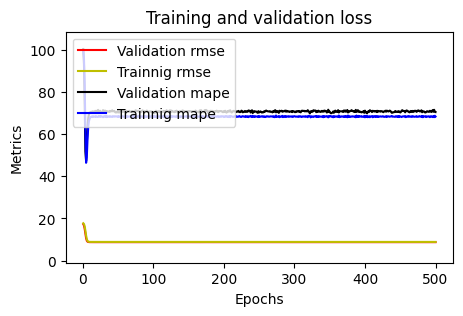

In [42]:
plotme(model2_4)

In [17]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,20, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 754988.0625 - distance_layer_loss: 95.0866 - traveltime_layer_loss: 943711.0625 - distance_layer_mape: 237083.3125 - distance_layer_rmse: 9.7512 - traveltime_layer_mape: 84.5448 - traveltime_layer_rmse: 971.4479 - val_loss: 203834.9375 - val_distance_layer_loss: 522.8349 - val_traveltime_layer_loss: 254662.9844 - val_distance_layer_mape: 16993.2734 - val_distance_layer_rmse: 22.8656 - val_traveltime_layer_mape: 50.4894 - val_traveltime_layer_rmse: 504.6414
Epoch 2/500
353/353 [==============================] - 0s 939us/step - loss: 193258.5000 - distance_layer_loss: 613.6371 - traveltime_layer_loss: 241419.5625 - distance_layer_mape: 2134436.2500 - distance_layer_rmse: 24.7717 - traveltime_layer_mape: 61.5975 - traveltime_layer_rmse: 491.3446 - val_loss: 189620.4219 - val_distance_layer_loss: 634.4894 - val_traveltime_layer_loss: 236866.9375 - val_distance_layer_mape: 18652.9492 - val_distance_layer_rmse: 25.189

353/353 [==============================] - 0s 939us/step - loss: 161519.8906 - distance_layer_loss: 150.2890 - traveltime_layer_loss: 201862.1875 - distance_layer_mape: 918122.8125 - distance_layer_rmse: 12.2592 - traveltime_layer_mape: 48.5981 - traveltime_layer_rmse: 449.2908 - val_loss: 157741.7656 - val_distance_layer_loss: 147.4967 - val_traveltime_layer_loss: 197140.2188 - val_distance_layer_mape: 8008.6929 - val_distance_layer_rmse: 12.1448 - val_traveltime_layer_mape: 49.5999 - val_traveltime_layer_rmse: 444.0048
Epoch 32/500
353/353 [==============================] - 0s 965us/step - loss: 161246.0000 - distance_layer_loss: 145.1551 - traveltime_layer_loss: 201521.0156 - distance_layer_mape: 872839.3125 - distance_layer_rmse: 12.0480 - traveltime_layer_mape: 48.5747 - traveltime_layer_rmse: 448.9109 - val_loss: 157270.7500 - val_distance_layer_loss: 143.5508 - val_traveltime_layer_loss: 196552.6250 - val_distance_layer_mape: 7886.0068 - val_distance_layer_rmse: 11.9813 - val_tr

353/353 [==============================] - 0s 972us/step - loss: 154531.8125 - distance_layer_loss: 104.8112 - traveltime_layer_loss: 193138.6094 - distance_layer_mape: 753031.1875 - distance_layer_rmse: 10.2377 - traveltime_layer_mape: 47.5469 - traveltime_layer_rmse: 439.4754 - val_loss: 147697.6094 - val_distance_layer_loss: 100.2525 - val_traveltime_layer_loss: 184596.9531 - val_distance_layer_mape: 6410.4463 - val_distance_layer_rmse: 10.0126 - val_traveltime_layer_mape: 47.3759 - val_traveltime_layer_rmse: 429.6475
Epoch 62/500
353/353 [==============================] - 0s 911us/step - loss: 154191.9062 - distance_layer_loss: 103.5288 - traveltime_layer_loss: 192713.9219 - distance_layer_mape: 750866.9375 - distance_layer_rmse: 10.1749 - traveltime_layer_mape: 47.5271 - traveltime_layer_rmse: 438.9919 - val_loss: 147225.1562 - val_distance_layer_loss: 98.3812 - val_traveltime_layer_loss: 184006.8281 - val_distance_layer_mape: 6340.0776 - val_distance_layer_rmse: 9.9187 - val_trav

353/353 [==============================] - 0s 959us/step - loss: 114308.9844 - distance_layer_loss: 74.8959 - traveltime_layer_loss: 142867.5781 - distance_layer_mape: 544408.3125 - distance_layer_rmse: 8.6542 - traveltime_layer_mape: 37.0976 - traveltime_layer_rmse: 377.9783 - val_loss: 106295.4531 - val_distance_layer_loss: 71.1828 - val_traveltime_layer_loss: 132851.5156 - val_distance_layer_mape: 4689.7432 - val_distance_layer_rmse: 8.4370 - val_traveltime_layer_mape: 35.6450 - val_traveltime_layer_rmse: 364.4880
Epoch 92/500
353/353 [==============================] - 0s 927us/step - loss: 114222.1406 - distance_layer_loss: 74.0594 - traveltime_layer_loss: 142759.1562 - distance_layer_mape: 547904.5625 - distance_layer_rmse: 8.6058 - traveltime_layer_mape: 36.8393 - traveltime_layer_rmse: 377.8348 - val_loss: 107306.2031 - val_distance_layer_loss: 76.3929 - val_traveltime_layer_loss: 134113.6406 - val_distance_layer_mape: 4912.9634 - val_distance_layer_rmse: 8.7403 - val_traveltime

353/353 [==============================] - 0s 938us/step - loss: 114379.1172 - distance_layer_loss: 74.1557 - traveltime_layer_loss: 142955.4062 - distance_layer_mape: 525479.3125 - distance_layer_rmse: 8.6114 - traveltime_layer_mape: 37.3031 - traveltime_layer_rmse: 378.0945 - val_loss: 106346.1875 - val_distance_layer_loss: 70.8731 - val_traveltime_layer_loss: 132915.0625 - val_distance_layer_mape: 4660.1401 - val_distance_layer_rmse: 8.4186 - val_traveltime_layer_mape: 37.1046 - val_traveltime_layer_rmse: 364.5752
Epoch 122/500
353/353 [==============================] - 0s 950us/step - loss: 114195.1172 - distance_layer_loss: 74.6192 - traveltime_layer_loss: 142725.1719 - distance_layer_mape: 533684.7500 - distance_layer_rmse: 8.6382 - traveltime_layer_mape: 37.1363 - traveltime_layer_rmse: 377.7899 - val_loss: 106979.6562 - val_distance_layer_loss: 73.6305 - val_traveltime_layer_loss: 133706.1719 - val_distance_layer_mape: 4779.0439 - val_distance_layer_rmse: 8.5808 - val_traveltim

353/353 [==============================] - 0s 946us/step - loss: 114220.5312 - distance_layer_loss: 73.9735 - traveltime_layer_loss: 142757.1875 - distance_layer_mape: 556950.1875 - distance_layer_rmse: 8.6008 - traveltime_layer_mape: 37.4623 - traveltime_layer_rmse: 377.8322 - val_loss: 106541.1875 - val_distance_layer_loss: 71.8115 - val_traveltime_layer_loss: 133158.4844 - val_distance_layer_mape: 4707.0518 - val_distance_layer_rmse: 8.4742 - val_traveltime_layer_mape: 36.0860 - val_traveltime_layer_rmse: 364.9089
Epoch 152/500
353/353 [==============================] - 0s 921us/step - loss: 114304.8828 - distance_layer_loss: 74.2348 - traveltime_layer_loss: 142862.5625 - distance_layer_mape: 535897.1250 - distance_layer_rmse: 8.6160 - traveltime_layer_mape: 37.1331 - traveltime_layer_rmse: 377.9716 - val_loss: 106865.0312 - val_distance_layer_loss: 72.5901 - val_traveltime_layer_loss: 133563.0938 - val_distance_layer_mape: 4727.7212 - val_distance_layer_rmse: 8.5200 - val_traveltim

353/353 [==============================] - 0s 972us/step - loss: 114250.6719 - distance_layer_loss: 74.2818 - traveltime_layer_loss: 142794.7188 - distance_layer_mape: 547710.0000 - distance_layer_rmse: 8.6187 - traveltime_layer_mape: 37.3335 - traveltime_layer_rmse: 377.8819 - val_loss: 106334.8438 - val_distance_layer_loss: 68.8888 - val_traveltime_layer_loss: 132901.3594 - val_distance_layer_mape: 4557.2920 - val_distance_layer_rmse: 8.2999 - val_traveltime_layer_mape: 36.8135 - val_traveltime_layer_rmse: 364.5564
Epoch 182/500
353/353 [==============================] - 0s 955us/step - loss: 114101.9453 - distance_layer_loss: 73.1653 - traveltime_layer_loss: 142609.0312 - distance_layer_mape: 541041.7500 - distance_layer_rmse: 8.5537 - traveltime_layer_mape: 37.2850 - traveltime_layer_rmse: 377.6361 - val_loss: 106310.0859 - val_distance_layer_loss: 69.5260 - val_traveltime_layer_loss: 132870.1406 - val_distance_layer_mape: 4584.7974 - val_distance_layer_rmse: 8.3382 - val_traveltim

353/353 [==============================] - 0s 944us/step - loss: 114217.1250 - distance_layer_loss: 72.5745 - traveltime_layer_loss: 142753.2812 - distance_layer_mape: 543752.4375 - distance_layer_rmse: 8.5191 - traveltime_layer_mape: 37.0643 - traveltime_layer_rmse: 377.8271 - val_loss: 106766.5469 - val_distance_layer_loss: 71.2400 - val_traveltime_layer_loss: 133440.3125 - val_distance_layer_mape: 4660.8926 - val_distance_layer_rmse: 8.4404 - val_traveltime_layer_mape: 38.2812 - val_traveltime_layer_rmse: 365.2948
Epoch 212/500
353/353 [==============================] - 0s 976us/step - loss: 114169.9922 - distance_layer_loss: 72.3961 - traveltime_layer_loss: 142694.3750 - distance_layer_mape: 541881.9375 - distance_layer_rmse: 8.5086 - traveltime_layer_mape: 37.3932 - traveltime_layer_rmse: 377.7491 - val_loss: 106954.3984 - val_distance_layer_loss: 67.0393 - val_traveltime_layer_loss: 133676.2344 - val_distance_layer_mape: 4481.0845 - val_distance_layer_rmse: 8.1878 - val_traveltim

353/353 [==============================] - 0s 945us/step - loss: 114124.7031 - distance_layer_loss: 72.0183 - traveltime_layer_loss: 142637.8438 - distance_layer_mape: 535132.1875 - distance_layer_rmse: 8.4864 - traveltime_layer_mape: 37.2912 - traveltime_layer_rmse: 377.6743 - val_loss: 106918.5312 - val_distance_layer_loss: 71.1920 - val_traveltime_layer_loss: 133630.3438 - val_distance_layer_mape: 4648.5688 - val_distance_layer_rmse: 8.4375 - val_traveltime_layer_mape: 38.4385 - val_traveltime_layer_rmse: 365.5548
Epoch 242/500
353/353 [==============================] - 0s 958us/step - loss: 114114.8906 - distance_layer_loss: 71.4607 - traveltime_layer_loss: 142625.7344 - distance_layer_mape: 516712.9375 - distance_layer_rmse: 8.4534 - traveltime_layer_mape: 37.2382 - traveltime_layer_rmse: 377.6582 - val_loss: 106511.6328 - val_distance_layer_loss: 69.9258 - val_traveltime_layer_loss: 133122.0781 - val_distance_layer_mape: 4594.4028 - val_distance_layer_rmse: 8.3622 - val_traveltim

353/353 [==============================] - 0s 954us/step - loss: 114316.1016 - distance_layer_loss: 71.3913 - traveltime_layer_loss: 142877.1562 - distance_layer_mape: 522473.5625 - distance_layer_rmse: 8.4493 - traveltime_layer_mape: 37.3680 - traveltime_layer_rmse: 377.9909 - val_loss: 106770.9375 - val_distance_layer_loss: 70.5003 - val_traveltime_layer_loss: 133446.0625 - val_distance_layer_mape: 4617.1982 - val_distance_layer_rmse: 8.3964 - val_traveltime_layer_mape: 38.1593 - val_traveltime_layer_rmse: 365.3027
Epoch 272/500
353/353 [==============================] - 0s 967us/step - loss: 114245.4062 - distance_layer_loss: 71.2315 - traveltime_layer_loss: 142788.9688 - distance_layer_mape: 533607.3125 - distance_layer_rmse: 8.4399 - traveltime_layer_mape: 37.3444 - traveltime_layer_rmse: 377.8743 - val_loss: 106470.4922 - val_distance_layer_loss: 69.4804 - val_traveltime_layer_loss: 133070.7656 - val_distance_layer_mape: 4571.1382 - val_distance_layer_rmse: 8.3355 - val_traveltim

353/353 [==============================] - 0s 946us/step - loss: 114165.4062 - distance_layer_loss: 71.2725 - traveltime_layer_loss: 142688.9688 - distance_layer_mape: 536600.6875 - distance_layer_rmse: 8.4423 - traveltime_layer_mape: 37.2911 - traveltime_layer_rmse: 377.7419 - val_loss: 106991.5000 - val_distance_layer_loss: 69.4561 - val_traveltime_layer_loss: 133721.9531 - val_distance_layer_mape: 4561.2173 - val_distance_layer_rmse: 8.3340 - val_traveltime_layer_mape: 38.7292 - val_traveltime_layer_rmse: 365.6801
Epoch 302/500
353/353 [==============================] - 0s 945us/step - loss: 114124.1484 - distance_layer_loss: 70.2721 - traveltime_layer_loss: 142637.6250 - distance_layer_mape: 501665.7188 - distance_layer_rmse: 8.3828 - traveltime_layer_mape: 37.4308 - traveltime_layer_rmse: 377.6740 - val_loss: 106541.2734 - val_distance_layer_loss: 69.8823 - val_traveltime_layer_loss: 133159.0938 - val_distance_layer_mape: 4586.9185 - val_distance_layer_rmse: 8.3596 - val_traveltim

353/353 [==============================] - 0s 899us/step - loss: 114139.4531 - distance_layer_loss: 69.8110 - traveltime_layer_loss: 142656.8438 - distance_layer_mape: 526480.2500 - distance_layer_rmse: 8.3553 - traveltime_layer_mape: 37.2455 - traveltime_layer_rmse: 377.6994 - val_loss: 106482.3672 - val_distance_layer_loss: 69.0042 - val_traveltime_layer_loss: 133085.7344 - val_distance_layer_mape: 4552.7427 - val_distance_layer_rmse: 8.3069 - val_traveltime_layer_mape: 36.8438 - val_traveltime_layer_rmse: 364.8092
Epoch 332/500
353/353 [==============================] - 0s 934us/step - loss: 114073.6172 - distance_layer_loss: 70.5079 - traveltime_layer_loss: 142574.3750 - distance_layer_mape: 520347.6875 - distance_layer_rmse: 8.3969 - traveltime_layer_mape: 37.1556 - traveltime_layer_rmse: 377.5902 - val_loss: 107377.1875 - val_distance_layer_loss: 70.3641 - val_traveltime_layer_loss: 134203.9219 - val_distance_layer_mape: 4605.0591 - val_distance_layer_rmse: 8.3883 - val_traveltim

353/353 [==============================] - 0s 914us/step - loss: 114184.3750 - distance_layer_loss: 69.2865 - traveltime_layer_loss: 142713.1406 - distance_layer_mape: 523454.2188 - distance_layer_rmse: 8.3239 - traveltime_layer_mape: 37.1324 - traveltime_layer_rmse: 377.7739 - val_loss: 106335.9219 - val_distance_layer_loss: 65.6424 - val_traveltime_layer_loss: 132903.4688 - val_distance_layer_mape: 4390.0688 - val_distance_layer_rmse: 8.1020 - val_traveltime_layer_mape: 36.6865 - val_traveltime_layer_rmse: 364.5593
Epoch 362/500
353/353 [==============================] - 0s 954us/step - loss: 114120.4219 - distance_layer_loss: 69.3915 - traveltime_layer_loss: 142633.1875 - distance_layer_mape: 518516.0938 - distance_layer_rmse: 8.3302 - traveltime_layer_mape: 37.3136 - traveltime_layer_rmse: 377.6681 - val_loss: 106485.9297 - val_distance_layer_loss: 68.5558 - val_traveltime_layer_loss: 133090.2812 - val_distance_layer_mape: 4524.4263 - val_distance_layer_rmse: 8.2798 - val_traveltim

353/353 [==============================] - 0s 967us/step - loss: 114304.8281 - distance_layer_loss: 69.4817 - traveltime_layer_loss: 142863.5625 - distance_layer_mape: 520663.0312 - distance_layer_rmse: 8.3356 - traveltime_layer_mape: 37.2229 - traveltime_layer_rmse: 377.9730 - val_loss: 106783.2578 - val_distance_layer_loss: 69.0462 - val_traveltime_layer_loss: 133461.7969 - val_distance_layer_mape: 4534.8008 - val_distance_layer_rmse: 8.3094 - val_traveltime_layer_mape: 38.0947 - val_traveltime_layer_rmse: 365.3242
Epoch 392/500
353/353 [==============================] - 0s 931us/step - loss: 114167.8203 - distance_layer_loss: 68.9162 - traveltime_layer_loss: 142692.5625 - distance_layer_mape: 514156.4062 - distance_layer_rmse: 8.3016 - traveltime_layer_mape: 37.2111 - traveltime_layer_rmse: 377.7467 - val_loss: 106344.1719 - val_distance_layer_loss: 66.9459 - val_traveltime_layer_loss: 132913.4531 - val_distance_layer_mape: 4444.6265 - val_distance_layer_rmse: 8.1820 - val_traveltim

353/353 [==============================] - 0s 965us/step - loss: 114174.4219 - distance_layer_loss: 68.4996 - traveltime_layer_loss: 142700.9375 - distance_layer_mape: 489883.4375 - distance_layer_rmse: 8.2764 - traveltime_layer_mape: 37.2837 - traveltime_layer_rmse: 377.7578 - val_loss: 106531.3984 - val_distance_layer_loss: 67.3318 - val_traveltime_layer_loss: 133147.4219 - val_distance_layer_mape: 4457.0713 - val_distance_layer_rmse: 8.2056 - val_traveltime_layer_mape: 37.7213 - val_traveltime_layer_rmse: 364.8937
Epoch 422/500
353/353 [==============================] - 0s 933us/step - loss: 114271.8047 - distance_layer_loss: 69.5054 - traveltime_layer_loss: 142822.3125 - distance_layer_mape: 504013.0000 - distance_layer_rmse: 8.3370 - traveltime_layer_mape: 37.4525 - traveltime_layer_rmse: 377.9184 - val_loss: 106636.3047 - val_distance_layer_loss: 67.8013 - val_traveltime_layer_loss: 133278.4062 - val_distance_layer_mape: 4480.5737 - val_distance_layer_rmse: 8.2342 - val_traveltim

353/353 [==============================] - 0s 942us/step - loss: 114162.6250 - distance_layer_loss: 68.1957 - traveltime_layer_loss: 142686.2812 - distance_layer_mape: 497857.1250 - distance_layer_rmse: 8.2581 - traveltime_layer_mape: 37.1877 - traveltime_layer_rmse: 377.7384 - val_loss: 106965.1719 - val_distance_layer_loss: 68.2078 - val_traveltime_layer_loss: 133689.3750 - val_distance_layer_mape: 4493.6699 - val_distance_layer_rmse: 8.2588 - val_traveltime_layer_mape: 38.5946 - val_traveltime_layer_rmse: 365.6356
Epoch 452/500
353/353 [==============================] - 0s 951us/step - loss: 114204.8828 - distance_layer_loss: 68.5822 - traveltime_layer_loss: 142738.9531 - distance_layer_mape: 511372.4688 - distance_layer_rmse: 8.2814 - traveltime_layer_mape: 37.3180 - traveltime_layer_rmse: 377.8081 - val_loss: 106482.7188 - val_distance_layer_loss: 67.3258 - val_traveltime_layer_loss: 133086.6406 - val_distance_layer_mape: 4457.1025 - val_distance_layer_rmse: 8.2052 - val_traveltim

353/353 [==============================] - 0s 939us/step - loss: 114245.4297 - distance_layer_loss: 68.1165 - traveltime_layer_loss: 142789.6875 - distance_layer_mape: 500588.8750 - distance_layer_rmse: 8.2533 - traveltime_layer_mape: 37.2176 - traveltime_layer_rmse: 377.8752 - val_loss: 107013.0312 - val_distance_layer_loss: 67.5203 - val_traveltime_layer_loss: 133749.4062 - val_distance_layer_mape: 4459.8745 - val_distance_layer_rmse: 8.2171 - val_traveltime_layer_mape: 38.7575 - val_traveltime_layer_rmse: 365.7177
Epoch 482/500
353/353 [==============================] - 0s 963us/step - loss: 114041.3594 - distance_layer_loss: 68.0072 - traveltime_layer_loss: 142534.5781 - distance_layer_mape: 518366.8125 - distance_layer_rmse: 8.2466 - traveltime_layer_mape: 37.2552 - traveltime_layer_rmse: 377.5375 - val_loss: 106604.0547 - val_distance_layer_loss: 66.4900 - val_traveltime_layer_loss: 133238.4219 - val_distance_layer_mape: 4410.7354 - val_distance_layer_rmse: 8.1541 - val_traveltim

In [18]:
# inputs: distance + hour
model2_4 = nnmodel(5,6,2,5,10,5, num_hlayers=3,Epoch=500)
model2_4

Epoch 1/500
353/353 [==============================] - 1s 1ms/step - loss: 909042.2500 - distance_layer_loss: 0.0268 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 20868.1797 - distance_layer_rmse: 0.1636 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0081 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 45.2557 - val_distance_layer_rmse: 0.0901 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 2/500
353/353 [==============================] - 0s 963us/step - loss: 909041.9375 - distance_layer_loss: 0.0070 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 10998.2656 - distance_layer_rmse: 0.0838 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 0.0056 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 33.5705 - val_distance_layer_rmse: 0.0749 - val_t

353/353 [==============================] - 0s 975us/step - loss: 909042.3750 - distance_layer_loss: 5.1503e-04 - traveltime_layer_loss: 1136302.8750 - distance_layer_mape: 6759.0439 - distance_layer_rmse: 0.0227 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 5.4881e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.0778 - val_distance_layer_rmse: 0.0234 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 32/500
353/353 [==============================] - 0s 976us/step - loss: 909041.9375 - distance_layer_loss: 5.1342e-04 - traveltime_layer_loss: 1136301.8750 - distance_layer_mape: 6640.0977 - distance_layer_rmse: 0.0227 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9746 - val_loss: 876251.4375 - val_distance_layer_loss: 5.3478e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 13.1708 - val_distance_layer_rmse: 0.0231 - 

353/353 [==============================] - 0s 974us/step - loss: 909042.3125 - distance_layer_loss: 5.0590e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6760.6680 - distance_layer_rmse: 0.0225 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 5.5535e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 13.8813 - val_distance_layer_rmse: 0.0236 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 62/500
353/353 [==============================] - 0s 973us/step - loss: 909041.6875 - distance_layer_loss: 5.0768e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6444.5830 - distance_layer_rmse: 0.0225 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 5.3618e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.4510 - val_distance_layer_rmse: 0.0232 - 

353/353 [==============================] - 0s 961us/step - loss: 909041.6875 - distance_layer_loss: 4.7071e-04 - traveltime_layer_loss: 1136302.7500 - distance_layer_mape: 6000.8394 - distance_layer_rmse: 0.0217 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.8206e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.2440 - val_distance_layer_rmse: 0.0220 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 92/500
353/353 [==============================] - 0s 971us/step - loss: 909042.1250 - distance_layer_loss: 4.7612e-04 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 6414.8926 - distance_layer_rmse: 0.0218 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 5.9701e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 13.7472 - val_distance_layer_rmse: 0.0244 - 

353/353 [==============================] - 0s 978us/step - loss: 909042.1250 - distance_layer_loss: 4.5297e-04 - traveltime_layer_loss: 1136302.8750 - distance_layer_mape: 6375.3242 - distance_layer_rmse: 0.0213 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 4.8133e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.1798 - val_distance_layer_rmse: 0.0219 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 122/500
353/353 [==============================] - 0s 972us/step - loss: 909041.6875 - distance_layer_loss: 4.5612e-04 - traveltime_layer_loss: 1136302.7500 - distance_layer_mape: 6549.3457 - distance_layer_rmse: 0.0214 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.7005e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.9687 - val_distance_layer_rmse: 0.0217 -

353/353 [==============================] - 0s 1ms/step - loss: 909041.7500 - distance_layer_loss: 4.4443e-04 - traveltime_layer_loss: 1136302.8750 - distance_layer_mape: 6295.1787 - distance_layer_rmse: 0.0211 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 4.7652e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.8729 - val_distance_layer_rmse: 0.0218 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 152/500
353/353 [==============================] - 0s 998us/step - loss: 909041.8750 - distance_layer_loss: 4.4374e-04 - traveltime_layer_loss: 1136302.8750 - distance_layer_mape: 6666.2988 - distance_layer_rmse: 0.0211 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 4.7433e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.9535 - val_distance_layer_rmse: 0.0218 - v

353/353 [==============================] - 0s 971us/step - loss: 909042.2500 - distance_layer_loss: 4.3366e-04 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 6108.0093 - distance_layer_rmse: 0.0208 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 5.2350e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.9878 - val_distance_layer_rmse: 0.0229 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 182/500
353/353 [==============================] - 0s 992us/step - loss: 909042.1250 - distance_layer_loss: 4.3866e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6182.0225 - distance_layer_rmse: 0.0209 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.7231e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 13.3635 - val_distance_layer_rmse: 0.0217 -

353/353 [==============================] - 0s 1ms/step - loss: 909042.0625 - distance_layer_loss: 4.3741e-04 - traveltime_layer_loss: 1136302.8750 - distance_layer_mape: 6507.0986 - distance_layer_rmse: 0.0209 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9751 - val_loss: 876251.4375 - val_distance_layer_loss: 4.2834e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.2071 - val_distance_layer_rmse: 0.0207 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 212/500
353/353 [==============================] - 0s 994us/step - loss: 909042.1250 - distance_layer_loss: 4.3242e-04 - traveltime_layer_loss: 1136302.2500 - distance_layer_mape: 6271.5552 - distance_layer_rmse: 0.0208 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.5700e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.7509 - val_distance_layer_rmse: 0.0214 - v

353/353 [==============================] - 0s 1ms/step - loss: 909042.1250 - distance_layer_loss: 4.2613e-04 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 6727.3398 - distance_layer_rmse: 0.0206 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.5173e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.6417 - val_distance_layer_rmse: 0.0213 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 242/500
353/353 [==============================] - 0s 986us/step - loss: 909041.7500 - distance_layer_loss: 4.2506e-04 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 6308.5757 - distance_layer_rmse: 0.0206 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.1276e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.6622 - val_distance_layer_rmse: 0.0203 - v

353/353 [==============================] - 0s 967us/step - loss: 909041.8750 - distance_layer_loss: 4.1147e-04 - traveltime_layer_loss: 1136302.7500 - distance_layer_mape: 6512.6758 - distance_layer_rmse: 0.0203 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.1271e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.8247 - val_distance_layer_rmse: 0.0203 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 272/500
353/353 [==============================] - 0s 973us/step - loss: 909042.2500 - distance_layer_loss: 4.1554e-04 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 6077.3345 - distance_layer_rmse: 0.0204 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 4.0989e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.4139 - val_distance_layer_rmse: 0.0202 -

353/353 [==============================] - 0s 1ms/step - loss: 909041.6875 - distance_layer_loss: 4.0381e-04 - traveltime_layer_loss: 1136302.5000 - distance_layer_mape: 6089.6953 - distance_layer_rmse: 0.0201 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 4.2002e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.4603 - val_distance_layer_rmse: 0.0205 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 302/500
353/353 [==============================] - 0s 1ms/step - loss: 909042.0625 - distance_layer_loss: 3.9879e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6359.7739 - distance_layer_rmse: 0.0200 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.0736e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.5376 - val_distance_layer_rmse: 0.0202 - val

353/353 [==============================] - 0s 971us/step - loss: 909042.3750 - distance_layer_loss: 3.9757e-04 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 6833.8550 - distance_layer_rmse: 0.0199 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.0182e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 12.0788 - val_distance_layer_rmse: 0.0200 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 332/500
353/353 [==============================] - 0s 955us/step - loss: 909042.3750 - distance_layer_loss: 3.9576e-04 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 6388.7720 - distance_layer_rmse: 0.0199 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.9631e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 9.9716 - val_distance_layer_rmse: 0.0199 - 

353/353 [==============================] - 0s 974us/step - loss: 909041.8750 - distance_layer_loss: 3.9367e-04 - traveltime_layer_loss: 1136302.6250 - distance_layer_mape: 6418.0063 - distance_layer_rmse: 0.0198 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 4.1130e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.0623 - val_distance_layer_rmse: 0.0203 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 362/500
353/353 [==============================] - 0s 973us/step - loss: 909042.2500 - distance_layer_loss: 3.9185e-04 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 6345.3369 - distance_layer_rmse: 0.0198 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 4.3883e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.3096 - val_distance_layer_rmse: 0.0209 -

353/353 [==============================] - 0s 987us/step - loss: 909042.1250 - distance_layer_loss: 3.8271e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6334.5571 - distance_layer_rmse: 0.0196 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.7778e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.4545 - val_distance_layer_rmse: 0.0194 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 392/500
353/353 [==============================] - 0s 1ms/step - loss: 909042.2500 - distance_layer_loss: 3.8859e-04 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 6355.0430 - distance_layer_rmse: 0.0197 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.8922e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.3145 - val_distance_layer_rmse: 0.0197 - v

353/353 [==============================] - 0s 984us/step - loss: 909041.6875 - distance_layer_loss: 3.7429e-04 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 6580.5757 - distance_layer_rmse: 0.0193 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.7752e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.2193 - val_distance_layer_rmse: 0.0194 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 422/500
353/353 [==============================] - 0s 958us/step - loss: 909042.0625 - distance_layer_loss: 3.8087e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6189.4795 - distance_layer_rmse: 0.0195 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.4682e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.0601 - val_distance_layer_rmse: 0.0186 -

353/353 [==============================] - 0s 977us/step - loss: 909041.7500 - distance_layer_loss: 3.6462e-04 - traveltime_layer_loss: 1136302.1250 - distance_layer_mape: 6106.3223 - distance_layer_rmse: 0.0191 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.3440e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.0452 - val_distance_layer_rmse: 0.0183 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 452/500
353/353 [==============================] - 0s 1ms/step - loss: 909042.0625 - distance_layer_loss: 3.6872e-04 - traveltime_layer_loss: 1136302.7500 - distance_layer_mape: 6296.0815 - distance_layer_rmse: 0.0192 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9750 - val_loss: 876251.4375 - val_distance_layer_loss: 3.3111e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 10.6277 - val_distance_layer_rmse: 0.0182 - v

353/353 [==============================] - 0s 1ms/step - loss: 909041.7500 - distance_layer_loss: 3.5760e-04 - traveltime_layer_loss: 1136302.3750 - distance_layer_mape: 6015.4941 - distance_layer_rmse: 0.0189 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9749 - val_loss: 876251.4375 - val_distance_layer_loss: 3.1434e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 9.7210 - val_distance_layer_rmse: 0.0177 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1046.5726
Epoch 482/500
353/353 [==============================] - 0s 973us/step - loss: 909041.7500 - distance_layer_loss: 3.5700e-04 - traveltime_layer_loss: 1136302.0000 - distance_layer_mape: 6221.9580 - distance_layer_rmse: 0.0189 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1065.9747 - val_loss: 876251.4375 - val_distance_layer_loss: 3.4248e-04 - val_traveltime_layer_loss: 1095314.2500 - val_distance_layer_mape: 11.3074 - val_distance_layer_rmse: 0.0185 - va